
# $$\scriptsize\textbf{Assignment 1 - Amirreza ``Farnam'' Taheri}$$

## Question 1: Analysis and Design of Multilayer Perceptron (MLP) Neural Networks

### Introduction

In the modern world of deep learning, designing and training neural networks has become one of the most important challenges in the field of machine learning. Complex datasets like Fashion-MNIST, which includes handwritten images of clothing, are used as a benchmark for evaluating various neural network models. In this regard, parameters such as the number of hidden layers, the number of nodes, the use of techniques like Dropout and Regularization, and the selection of the best optimization method play a crucial role in achieving optimal model performance. In these questions, the design and training of neural network models with different settings are examined, and the impact of various hyperparameter settings, regularizers, and optimization methods on the Fashion-MNIST dataset is analyzed. In this process, the confusion matrix is used as a tool for detailed examination of model errors in class recognition, and hyperparameter search methods such as Bayesian and random search are considered to select the best combination of settings. These questions help you understand the quantitative and qualitative differences between various models and use the results to improve the accuracy and overall performance of the models.

### 1-1. Design of a Multilayer Perceptron (25 points)

Design a Multilayer Perceptron (MLP) for the Fashion-MNIST dataset that includes a hidden layer with 100 nodes and ReLU activation function. Additionally, use a Dropout layer with a 30% rate and L2 Regularizer with a coefficient of λ = 0.0001. Train this model and generate a Heatmap of the confusion matrix using the Seaborn library or a similar library. For each class, find the class that is most often confused with it and list them.


### 1-2. Training Two Different Models (20 Points)

Train two different models with the following settings on the Fashion-MNIST dataset:

1. Model 1: One hidden layer with 128 nodes, no regularizer, and no Dropout.
2. Model 2: One hidden layer with 48 nodes, Dropout with rate = 0.2, and L2 Regularizer with coefficient λ = 0.0001.

Use the Stochastic Gradient Descent optimizer for both models and train them for 40 epochs. For each model, generate two histograms of the weights for each layer (input layer and hidden layer).

### 1.3. Optimizer Comparison (25 points)
Use the backpropagation algorithm with three optimization methods (such as RMSprop, Adam, and Nadam) to train a neural network on Fashion-MNIST. Then analyze their performance, speed of convergence, and overall accuracy.

### 1-4. Examining Different Hyperparameters (30 Points)

Examine the effect of different hyperparameter settings (3 examples), such as learning rate and the number of neurons in the hidden layers, on a neural network for Fashion-MNIST. For each hyperparameter, try at least three different states and plot the Loss and Accuracy graphs. Note that the architecture in this section is not fixed, and you can choose your architecture based on the results in the previous sections. Choosing a good architecture is also included in the score. Use The confusion matrices results to examine the classes that are most often confused in detail, and analyze how changing each of the hyperparameters affects the classes that are confused with each other. Investigate and research the reason for this.

## Preliminary Setup

In [1]:
# Import necessary libraries
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from tensorflow.keras import models, layers, regularizers, callbacks, losses, metrics, optimizers
from tensorflow.keras.utils import plot_model
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

# Suppress warnings and TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages
warnings.filterwarnings('ignore')         # Suppress Python warnings
tf.get_logger().setLevel('ERROR')         # Further reduce TensorFlow logging

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set path for Graphviz (for model visualization)
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

### Load Data

In [2]:
# Fetch the Fashion-MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False, parser='auto')
x, y = fashion_mnist.data, fashion_mnist.target.astype(int)

# Split into training and test sets
x_train, x_test = x[:60000], x[60000:]
y_train, y_test = y[:60000], y[60000:]

# Normalize pixel values to the range [0,1]
x_train = x_train.astype('float16') / 255.0
x_test = x_test.astype('float16') / 255.0

# Define class names for visualization
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 1.1 Answer

### Multilayer Perceptron

#### Construct the Model

In [3]:
# Build the MLP Model Architecture with Dropout and L2 regularization
model = models.Sequential([
    layers.Input(shape=(784,)),                                 # Input: 784-dimensional vector
    layers.Dense(100, activation='relu',                        # Hidden layer: 100 neurons with ReLU activation
                kernel_regularizer=regularizers.l2(0.0001)),    # L2 regularization with small lambda
    layers.Dropout(0.3),                                        # Dropout layer with 30% rate
    layers.Dense(10, activation='softmax')                      # Output layer: 10 classes with softmax
])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

In [4]:
# Compile the model with Adam optimizer
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),    
    loss=losses.SparseCategoricalCrossentropy(),       # Loss for integer-encoded labels
    metrics=['accuracy']                               
)

# Set up Early Stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',           
    patience=30,                   
    restore_best_weights=True     
)

# Train the model with early stopping
history = model.fit(
    x_train, y_train,
    epochs=80, batch_size=128,
    validation_split=0.1,     
    callbacks=callbacks.EarlyStopping(
        monitor='val_loss',           
        patience=10, restore_best_weights=True
        ),
    verbose=0                 
)

### Evaluate and Report

Test accuracy: 0.8778


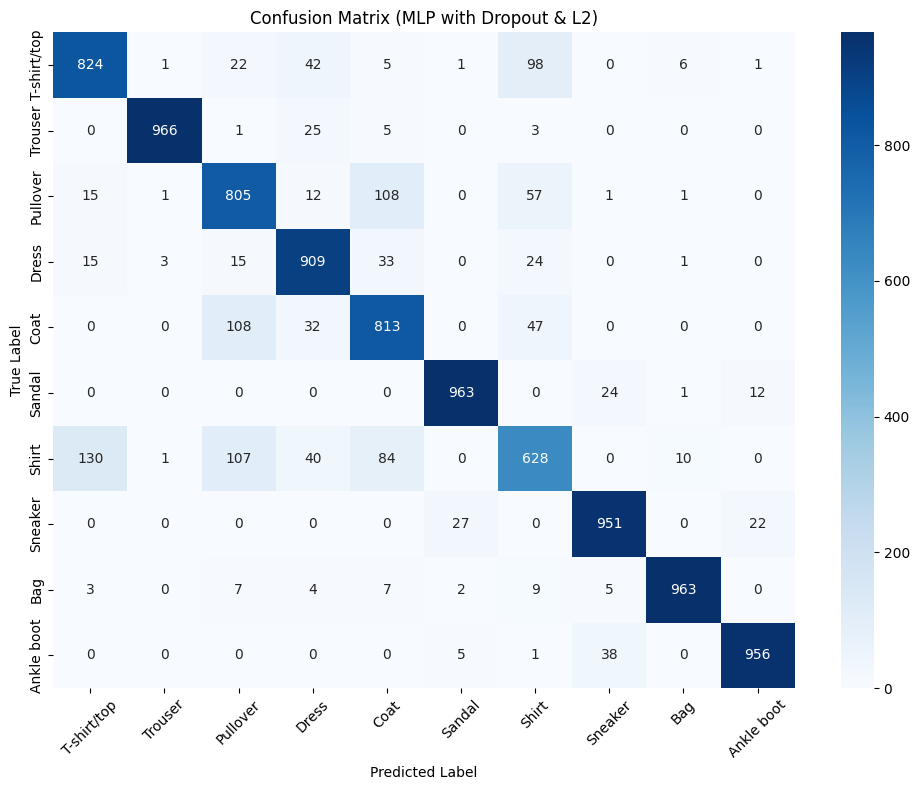

Class 'T-shirt/top' most often misclassified as: 'Shirt'
Class 'Trouser' most often misclassified as: 'Dress'
Class 'Pullover' most often misclassified as: 'Coat'
Class 'Dress' most often misclassified as: 'Coat'
Class 'Coat' most often misclassified as: 'Pullover'
Class 'Sandal' most often misclassified as: 'Sneaker'
Class 'Shirt' most often misclassified as: 'T-shirt/top'
Class 'Sneaker' most often misclassified as: 'Sandal'
Class 'Bag' most often misclassified as: 'Shirt'
Class 'Ankle boot' most often misclassified as: 'Sneaker'


In [5]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)   
print(f"Test accuracy: {test_acc:.4f}")                           

# Generate predictions on the test set
y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)   

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Visualize confusion matrix
plt.figure(figsize=(10, 8))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)  
plt.title("Confusion Matrix (MLP with Dropout & L2)") 
plt.xlabel("Predicted Label")  
plt.ylabel("True Label")  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()  

# Identify most frequently misclassified class for each true class
for i in range(10):
    cm_copy = cm.copy()
    cm_copy[i, i] = 0                           # Zero out diagonal (correct predictions)
    most_misclassified = np.argmax(cm_copy[i])  # Find class with highest misclassification
    print(f"Class '{class_names[i]}' most often misclassified as: '{class_names[most_misclassified]}'") 

#### Results Analysis:

The MLP with Dropout and L2 regularization achieved 87.78% test , which is quite strong for a simple fully connected network.

Looking at the confusion matrix, we see that some classes are frequently mixed up. **`Shirt` and `T-shirt/top`** are the most commonly confused pair, which makes sense—they look very similar, especially in a grayscale dataset. Similarly, **`Pullover` and `Coat`** are often mistaken for one another, with the same arguement also holds for them. The confusion happens again with **`Sneaker` and `Ankle boot`**, which both similar overall shape. This suggests that the model is relying heavily on overall patterns rather than picking up finer details that differentiate these items.

## 1-2. Answer

### Model 1: MLP without any Regularization (No Dropout, No L2)

In [6]:
# Define Model 1: MLP without regularization (No Dropout, No L2)
model1 = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),  # Hidden layer with 128 neurons
    layers.Dense(10, activation='softmax')                     # Output layer with 10 classes
])

# Compile Model 1 with SGD optimizer
model1.compile(
    optimizer='SGD',                          
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']                       
)

# Train Model 1
history1 = model1.fit(
    x_train, y_train, epochs=60,
    batch_size=128,validation_split=0.1,  
    verbose=0
)

# Plot architecture
display(
    plot_model(
    model1,
    show_shapes=True,               # Display the output shapes for each layer
    show_dtype=True,                # Display the data type (dtype) of the output for each layer
    show_layer_names=False,         # Show the name assigned to each layer in the model
    rankdir="LR",                   # Set the graph layout direction
    dpi=4000,                       # Set the resolution of the output image
    show_layer_activations=True,    # Display the activation functions 
    show_trainable=True             # Mark whether each layer is trainable 
))

### Model 2: MLP with Dropout and L2 Regularization

In [7]:
# Define the model architecture
model2 = models.Sequential([
    # Hidden layer
    layers.Dense(48, activation='relu',              # ReLU activation
        kernel_regularizer=regularizers.l2(0.0001),  # Apply L2 regularization with lambda = 0.0001
        input_shape=(784,) 
    ),
    layers.Dropout(0.2),        # Dropout layer 20% dropout rate
    layers.Dense(10,            # 10 neurons for classification into 10 classes
        activation='softmax'    # softmax for multi-class classification
    )
])

# Compile and train Model 2
model2.compile(
    optimizer='SGD',                      
    loss='sparse_categorical_crossentropy',   
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train, y_train, epochs=60,
    batch_size=128, validation_split=0.1,
    verbose=0              
)

# Plot architecture
display(
    plot_model(
    model2, show_shapes=True, show_dtype=True, show_layer_names=False,           
    rankdir="LR", dpi=4000, show_layer_activations=True, show_trainable=True              
))

### Plot Histograms

In [8]:
# Extract model weights
w1_input_hidden = model1.layers[0].get_weights()[0].flatten()
w1_hidden_output = model1.layers[1].get_weights()[0].flatten()  # Dropout layer is index 1

w2_input_hidden = model2.layers[0].get_weights()[0].flatten()
w2_hidden_output = model2.layers[2].get_weights()[0].flatten()  # Dropout layer is index 2

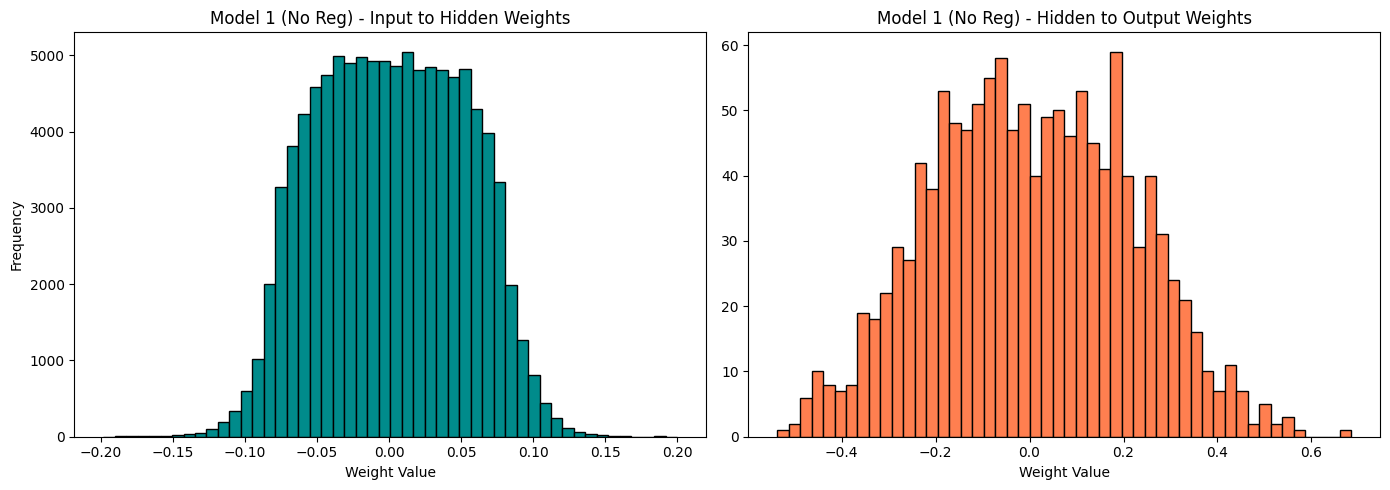

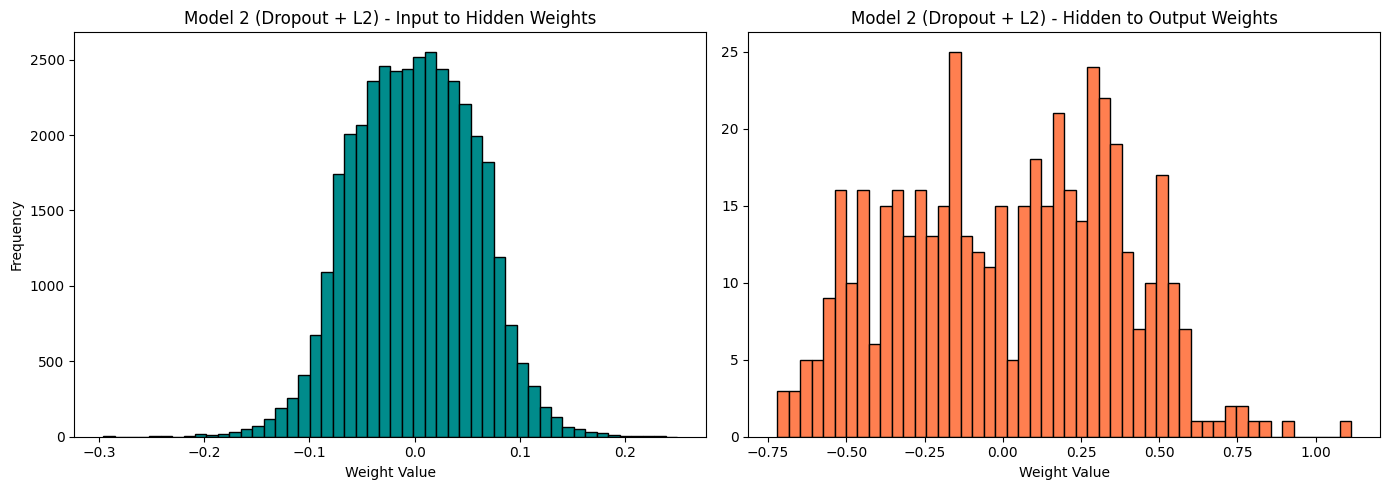

In [9]:
# Plot weight histograms for Model 1
plt.figure(figsize=(14, 5))

# Input to Hidden weights - Model 1
plt.subplot(1, 2, 1)
plt.hist(w1_input_hidden, bins=50, color='darkcyan', edgecolor='black')
plt.title('Model 1 (No Reg) - Input to Hidden Weights', fontsize=12)
plt.xlabel('Weight Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Hidden to Output weights - Model 1
plt.subplot(1, 2, 2)
plt.hist(w1_hidden_output, bins=50, color='coral', edgecolor='black')
plt.title('Model 1 (No Reg) - Hidden to Output Weights', fontsize=12)
plt.xlabel('Weight Value', fontsize=10)

plt.tight_layout()
plt.show()

# Plot weight histograms for Model 2
plt.figure(figsize=(14, 5))

# Input to Hidden weights - Model 2
plt.subplot(1, 2, 1)
plt.hist(w2_input_hidden, bins=50, color='darkcyan', edgecolor='black')
plt.title('Model 2 (Dropout + L2) - Input to Hidden Weights', fontsize=12)
plt.xlabel('Weight Value', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Hidden to Output weights - Model 2
plt.subplot(1, 2, 2)
plt.hist(w2_hidden_output, bins=50, color='coral', edgecolor='black')
plt.title('Model 2 (Dropout + L2) - Hidden to Output Weights', fontsize=12)
plt.xlabel('Weight Value', fontsize=10)

plt.tight_layout()
plt.show()

In [10]:
print(f"Final Training Accuracy - No Regularization:     {history1.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy - No Regularization:   {history1.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy - No Regularization:               {model1.evaluate(x_test, y_test, verbose=0)[1]:.4f}\n")

print(f"Final Training Accuracy - With Regularization:   {history2.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy - With Regularization: {history2.history['val_accuracy'][-1]:.4f}")
print(f"Test Accuracy - With Regularization:             {model2.evaluate(x_test, y_test, verbose=0)[1]:.4f}")

Final Training Accuracy - No Regularization:     0.8809
Final Validation Accuracy - No Regularization:   0.8683
Test Accuracy - No Regularization:               0.8622

Final Training Accuracy - With Regularization:   0.8624
Final Validation Accuracy - With Regularization: 0.8635
Test Accuracy - With Regularization:             0.8547


#### Results Analysis

Model 1 (no regularization) achieves higher training accuracy (88.09%) but experiences a notable drop on validation (86.83%) and test data (86.22%), indicating overfitting. Model 2 (Dropout + L2) has lower training accuracy (86.24%) but remains more stable on validation (86.35%) and test (85.47%), suggesting better generalization. The small drop from validation to test in Model 2 (0.88%) compared to Model 1 (0.61%) implies that while Model 1 memorizes patterns better but lacks in generalizing to new data. On the other hand. Model 2 resists overfitting at the cost of a minor performance reduction.

Model 1’s hidden-to-output weight distribution is wider, with larger magnitude values, meaning it heavily depends on specific neurons which is consistent with overfit that explained ealier. Model 2’s weights has a lower standard deviation and are more concentrated around zero, which indicates the effect of L2 regularization limiting extreme weight values. Dropout further reduces reliance on individual neurons, forcing more balanced weight usage and leading to a more generalizable model.


## 1.3. Answer

In this section, for complete evaluation of Adam, Nadam, and RMSprop, I am comparing their accuracy, stability, and convergence speed under two learning rates (0.01, 0.0001) and two model complexities (simple, complex). 

The implementation follows a structured approach: models are trained using backpropagation with different optimizers, stopping early based on validation loss to prevent overfitting. Performance is measured in four areas— loss and accuracy trends, validation performance , test accuracy, and convergence speed. Finally, results are analyzed to understand to determine their pros. and cons. in different training scenarios.



In [11]:
# Parameters
LEARNING_RATES = [0.01, 0.0001]
EPOCHS = 500
BATCH_SIZE = 128
PATIENCE_VALUES = {0.01: 10, 0.0001: 30}

In [12]:
# ======= Training Simple Models =======

# Optimizer Configurations
OPTIMIZERS = {
    'Adam': optimizers.Adam, 'Nadam': optimizers.Nadam, 'RMSprop': optimizers.RMSprop
}

# Color Palette for later plotting
COLORS = {
    'Adam': 'purple', 'Nadam': 'green', 'RMSprop': 'orange'
}

# Dictionary to store simple model results
results_simple = {lr: {} for lr in LEARNING_RATES}

# Training loop for simple models
for lr in LEARNING_RATES:
    print(f"Simple Model - Learning Rate: {lr}")
    for opt_name, opt_class in OPTIMIZERS.items():
        model_simple = models.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(10, activation='relu',
                         kernel_regularizer=regularizers.l2(0.00005)),
            layers.Dropout(0.2),
            layers.Dense(10, activation='softmax')
        ])
        
        model_simple.compile(
            optimizer=opt_class(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model_simple.fit(
            x_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            callbacks=[
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=PATIENCE_VALUES[lr],
                    restore_best_weights=True
                )
            ],
            verbose=0
        )

        test_loss, test_acc = model_simple.evaluate(x_test, y_test, verbose=0)
        results_simple[lr][opt_name] = {
            'best_val_accuracy': max(history.history['val_accuracy']),
            'test_accuracy': test_acc,
            'epochs_run': len(history.history['loss']),
            'loss_curve': history.history['loss'],
            'accuracy_curve': history.history['accuracy'],
            'val_loss_curve': history.history['val_loss'],
            'val_accuracy_curve': history.history['val_accuracy'],
            'history': history
        }

        print(f"  {opt_name}: Best Val Acc: {max(history.history['val_accuracy']):.4f}, "
              f"Test Acc: {test_acc:.4f}, Epochs: {len(history.history['loss'])}")


Simple Model - Learning Rate: 0.01
  Adam: Best Val Acc: 0.8167, Test Acc: 0.8071, Epochs: 28
  Nadam: Best Val Acc: 0.8372, Test Acc: 0.8257, Epochs: 29
  RMSprop: Best Val Acc: 0.5615, Test Acc: 0.5376, Epochs: 13
Simple Model - Learning Rate: 0.0001
  Adam: Best Val Acc: 0.8543, Test Acc: 0.8465, Epochs: 282
  Nadam: Best Val Acc: 0.8553, Test Acc: 0.8411, Epochs: 309
  RMSprop: Best Val Acc: 0.8532, Test Acc: 0.8414, Epochs: 346


In [13]:
# ======= Training Complex Models =======

# Dictionary to store complex model results
results_complex = {lr: {} for lr in LEARNING_RATES}

# Training loop for complex models
for lr in LEARNING_RATES:
    print(f"Complex Model - Learning Rate: {lr}")
    for opt_name, opt_class in OPTIMIZERS.items():
        model_complex = models.Sequential([
            layers.Input(shape=(784,)),
            layers.Dense(128, activation='relu',
                         kernel_regularizer=regularizers.l2(0.0001)),
            layers.Dropout(0.3),
            layers.Dense(64, activation='relu',
                         kernel_regularizer=regularizers.l2(0.0001)),
            layers.Dropout(0.3),
            layers.Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer=opt_class(learning_rate=lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            x_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            callbacks=[
                callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=PATIENCE_VALUES[lr],
                    restore_best_weights=True
                )
            ],
            verbose=0
        )

        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        results_complex[lr][opt_name] = {
            'best_val_accuracy': max(history.history['val_accuracy']),
            'test_accuracy': test_acc,
            'epochs_run': len(history.history['loss']),
            'loss_curve': history.history['loss'],
            'accuracy_curve': history.history['accuracy'],
            'val_loss_curve': history.history['val_loss'],
            'val_accuracy_curve': history.history['val_accuracy'],
            'history': history
        }
        
        print(f"  {opt_name}: Best Val Acc: {max(history.history['val_accuracy']):.4f}, "
              f"Test Acc: {test_acc:.4f}, Epochs: {len(history.history['loss'])}")


Complex Model - Learning Rate: 0.01
  Adam: Best Val Acc: 0.8470, Test Acc: 0.8322, Epochs: 12
  Nadam: Best Val Acc: 0.8573, Test Acc: 0.8487, Epochs: 16
  RMSprop: Best Val Acc: 0.8525, Test Acc: 0.8455, Epochs: 28
Complex Model - Learning Rate: 0.0001
  Adam: Best Val Acc: 0.8863, Test Acc: 0.8789, Epochs: 338
  Nadam: Best Val Acc: 0.8868, Test Acc: 0.8792, Epochs: 83
  RMSprop: Best Val Acc: 0.8872, Test Acc: 0.8778, Epochs: 42


### Optimizer Comparison

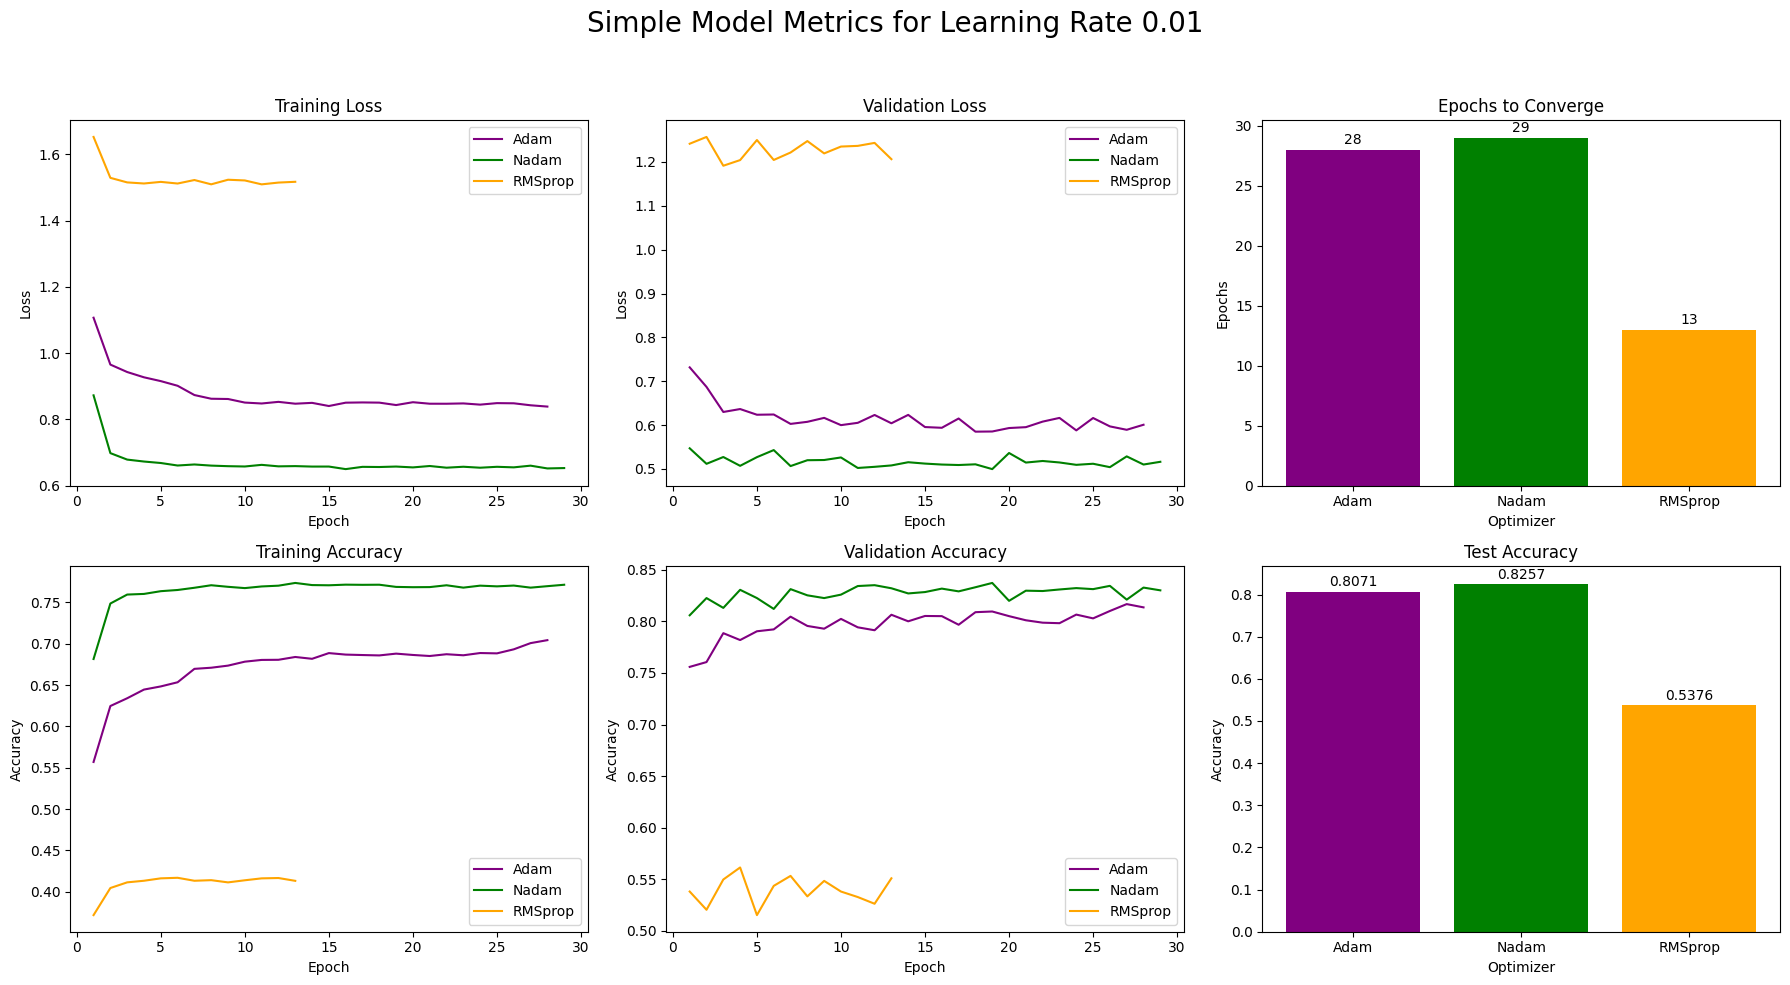

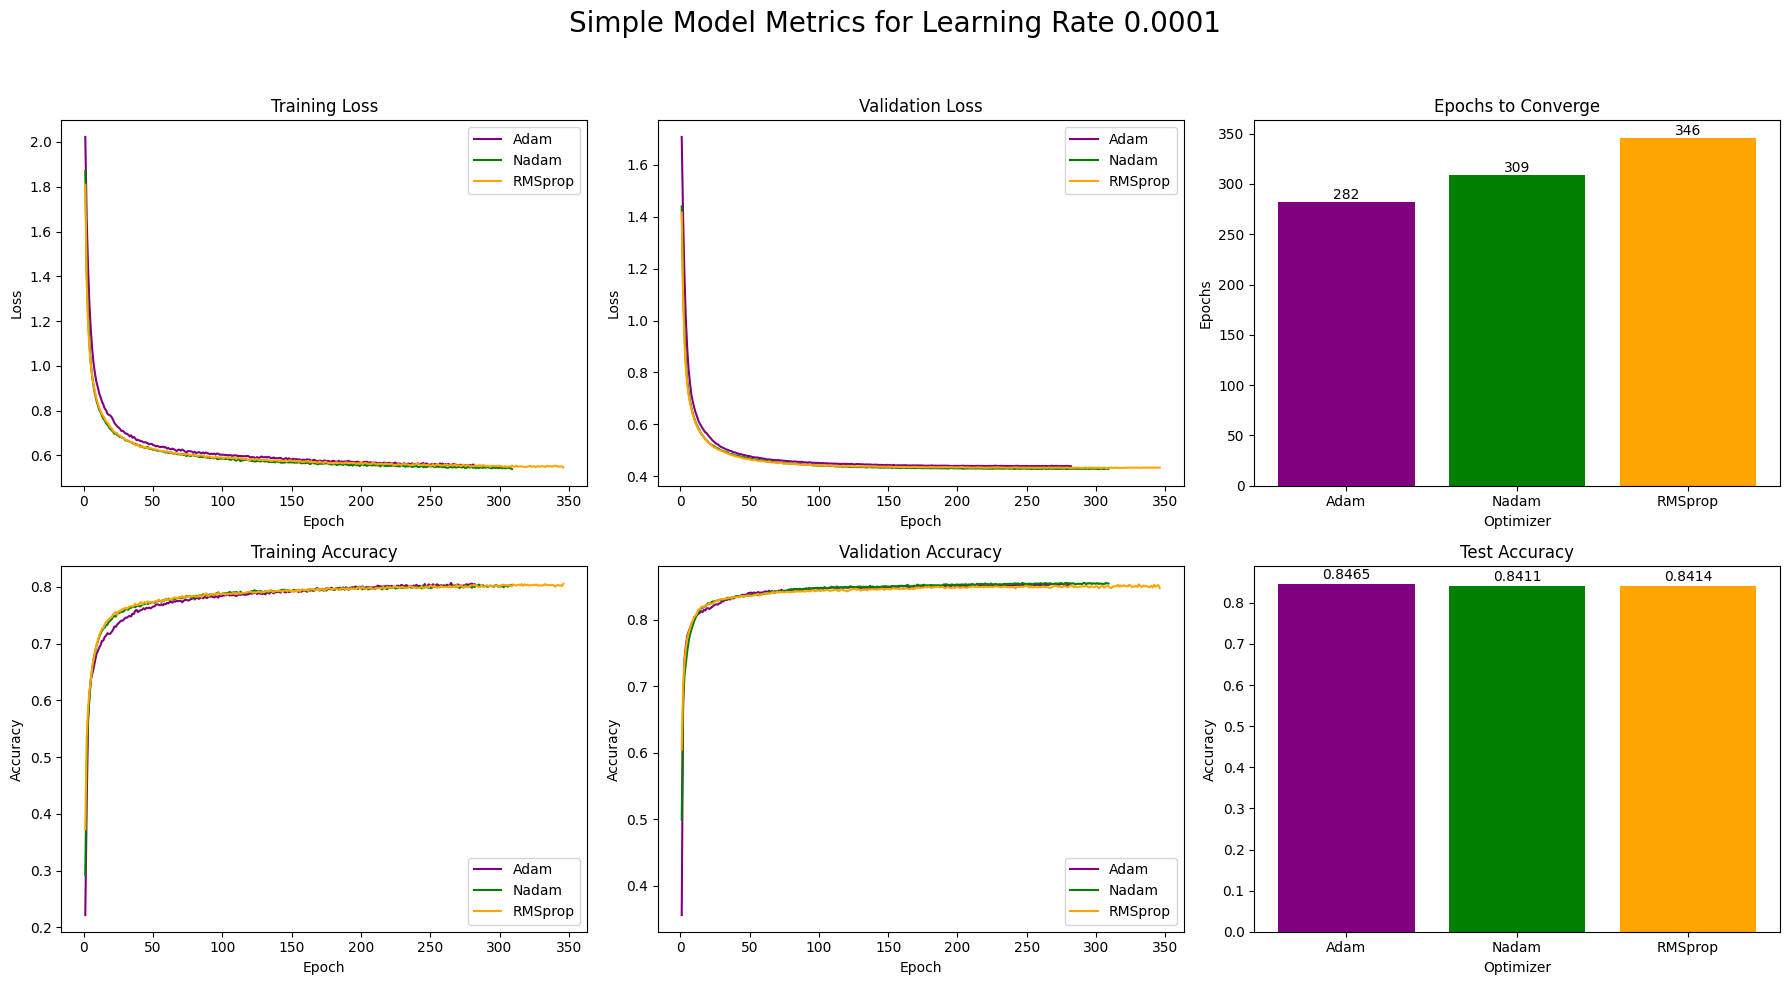

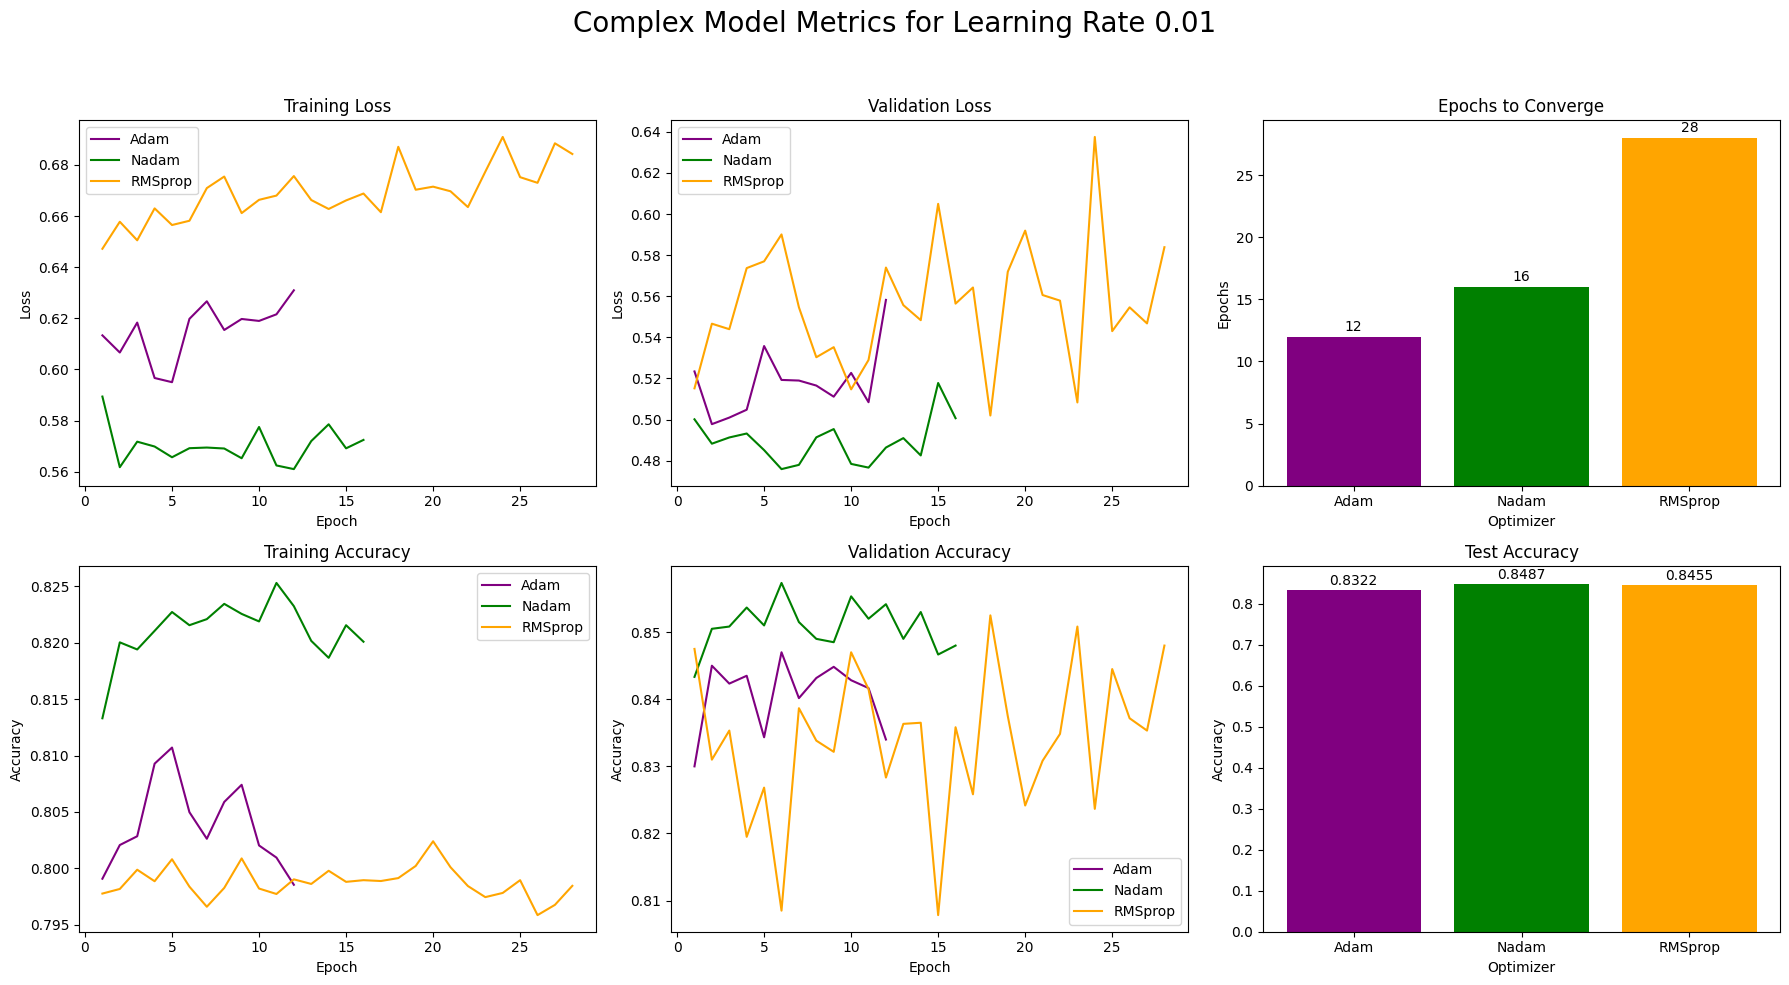

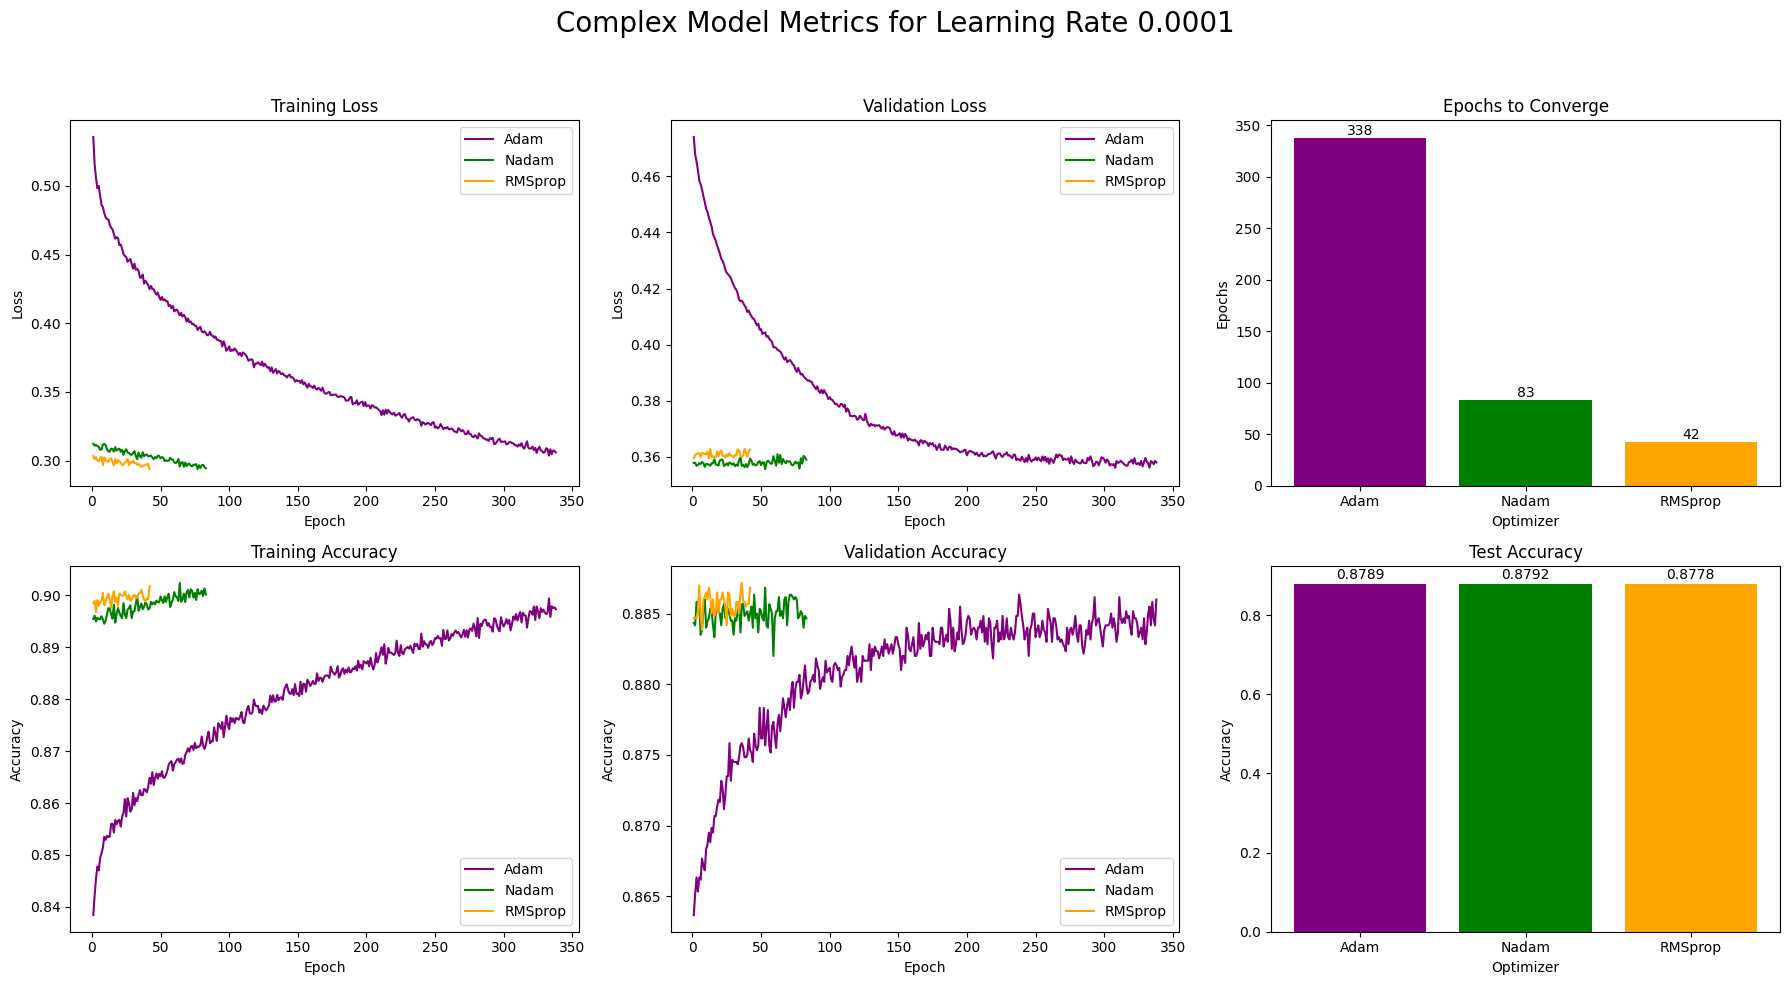


--- Performance Summary ---

Model Type: Simple
  Learning Rate: 0.01
    Adam Optimizer:
      - Best Validation Accuracy: 0.8167
      - Test Accuracy: 0.8071
      - Epochs to Converge: 28
    Nadam Optimizer:
      - Best Validation Accuracy: 0.8372
      - Test Accuracy: 0.8257
      - Epochs to Converge: 29
    RMSprop Optimizer:
      - Best Validation Accuracy: 0.5615
      - Test Accuracy: 0.5376
      - Epochs to Converge: 13
  Learning Rate: 0.0001
    Adam Optimizer:
      - Best Validation Accuracy: 0.8543
      - Test Accuracy: 0.8465
      - Epochs to Converge: 282
    Nadam Optimizer:
      - Best Validation Accuracy: 0.8553
      - Test Accuracy: 0.8411
      - Epochs to Converge: 309
    RMSprop Optimizer:
      - Best Validation Accuracy: 0.8532
      - Test Accuracy: 0.8414
      - Epochs to Converge: 346

Model Type: Complex
  Learning Rate: 0.01
    Adam Optimizer:
      - Best Validation Accuracy: 0.8470
      - Test Accuracy: 0.8322
      - Epochs to Converge: 

In [14]:
# Plotting All Results and Summary Statistics

# Combine the results into one dictionary for easier plotting
all_results = {'Simple': results_simple, 'Complex': results_complex}

for model_type, res in all_results.items():
    for lr in LEARNING_RATES:
        optimizer_names = list(res[lr].keys())
        fig, axs = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f"{model_type} Model Metrics for Learning Rate {lr}", fontsize=20)
        
        # Column 1: Training Metrics
        # Top: Training Loss
        ax1 = axs[0, 0]
        for opt in optimizer_names:
            data = res[lr][opt]
            epochs_range = range(1, len(data['loss_curve']) + 1)
            ax1.plot(epochs_range, data['loss_curve'], label=opt, color=COLORS[opt])
        ax1.set_title("Training Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss")
        ax1.legend()
        
        # Bottom: Training Accuracy
        ax2 = axs[1, 0]
        for opt in optimizer_names:
            data = res[lr][opt]
            epochs_range = range(1, len(data['accuracy_curve']) + 1)
            ax2.plot(epochs_range, data['accuracy_curve'], label=opt, color=COLORS[opt])
        ax2.set_title("Training Accuracy")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        
        # Column 2: Validation Metrics
        # Top: Validation Loss
        ax3 = axs[0, 1]
        for opt in optimizer_names:
            data = res[lr][opt]
            epochs_range = range(1, len(data['val_loss_curve']) + 1)
            ax3.plot(epochs_range, data['val_loss_curve'], label=opt, color=COLORS[opt])
        ax3.set_title("Validation Loss")
        ax3.set_xlabel("Epoch")
        ax3.set_ylabel("Loss")
        ax3.legend()
        
        # Bottom: Validation Accuracy
        ax4 = axs[1, 1]
        for opt in optimizer_names:
            data = res[lr][opt]
            epochs_range = range(1, len(data['val_accuracy_curve']) + 1)
            ax4.plot(epochs_range, data['val_accuracy_curve'], label=opt, color=COLORS[opt])
        ax4.set_title("Validation Accuracy")
        ax4.set_xlabel("Epoch")
        ax4.set_ylabel("Accuracy")
        ax4.legend()
        
        # Column 3: Summary Metrics (Bar Plots)
        # Top: Epochs to Converge
        ax5 = axs[0, 2]
        epochs_run_list = [res[lr][opt]['epochs_run'] for opt in optimizer_names]
        bars = ax5.bar(optimizer_names, epochs_run_list, color=[COLORS[opt] for opt in optimizer_names])
        ax5.set_title("Epochs to Converge")
        ax5.set_xlabel("Optimizer")
        ax5.set_ylabel("Epochs")
        for bar in bars:
            yval = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval}', ha='center', va='bottom', fontsize=10)
        
        # Bottom: Test Accuracy
        ax6 = axs[1, 2]
        test_acc_list = [res[lr][opt]['test_accuracy'] for opt in optimizer_names]
        bars = ax6.bar(optimizer_names, test_acc_list, color=[COLORS[opt] for opt in optimizer_names])
        ax6.set_title("Test Accuracy")
        ax6.set_xlabel("Optimizer")
        ax6.set_ylabel("Accuracy")
        for bar in bars:
            yval = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Performance Summary: Print summary statistics for both model types
print("\n--- Performance Summary ---")
for model_type, res in all_results.items():
    print(f"\nModel Type: {model_type}")
    for lr in LEARNING_RATES:
        print(f"  Learning Rate: {lr}")
        for opt in res[lr]:
            data = res[lr][opt]
            print(f"    {opt} Optimizer:")
            print(f"      - Best Validation Accuracy: {data['best_val_accuracy']:.4f}")
            print(f"      - Test Accuracy: {data['test_accuracy']:.4f}")
            print(f"      - Epochs to Converge: {data['epochs_run']}")

#### Results Analysis:

Optimizer performance varies significantly with learning rate and model complexity. Nadam shows superior test accuracy (82.6-87.9%) across most scenarios, with its Nesterov-accelerated momentum providing update stability while maintaining strong generalization. In simple models at 0.01 learning rate, Nadam (82.6%) outperforms RMSprop (53.8%), while maintaining a smaller 1.9% advantage over Adam (80.7%). 

At learning 0.0001, all optimizers achieve similar accuracy in simple models (84.1-84.7%), but with very different convergence rates. In complex models, RMSprop converges in just 42 epochs—2× faster than Nadam (83) and 8× faster than Adam (338)—while maintaining comparable accuracy (87.8% vs 87.9% for Nadam). Validation curves reveal that RMSprop and Nadam quickly plateau at optimum accuracy, while Adam continues slight improvements over hundreds of epochs.

The results reveal specific characteristics for each: Adam shows reliable but gradual performance improvements, with near-linear validation accuracy gains at 0.0001. RMSprop displays high oscillation at 0.01 but sufficiently good stablity and rapid convergence at 0.0001. Nadam combines rapid initial progress with smooth convergence, explaining its balanced performance profile.

In the complex model at 0.01, all optimizers achieve respectable accuracy (83.2-84.9%), but with significant convergence speed differences (12, 16, and 28 epochs for Adam, Nadam, and RMSprop respectively). This suggests that Adam's adaptive moment estimation is better at capturing useful gradient directions early in training when gradients are large.

The optimizer selection should therefore be guided by specific requirements for speed versus stability, with RMSprop being optimal for careful fine-tuning and Nadam offering the best general-purpose performance.

## 1.4. Answer

#### Approach

My approach is sequential: for each hyperparameter (e.g., learning rate, number of neurons, dropout rate, and batch size), I run the network with several candidate values. I record metrics like validation accuracy, loss, training time, and test accuracy. For each hyperparameter, I determine the best candidate by selecting the configuration that achieves the highest validation accuracy. Importantly, once a hyperparameter is tuned, its best value is fixed for subsequent tunings. This isolation ensures that when I tune the next hyperparameter, its effect is clearly observed without any spilling effect from the previous parameters. Finally, I retrain the model with all the best parameters to build the final model.

### Define Classes and Functions

In [15]:
# ===================== Model Builder Class =====================
class ModelBuilder:
    """
    Build and compile an MLP model with configurable architecture.
    """
    def __init__(self, num_layers, nodes, dropout_rate, lr, input_shape=(784,)):
        self.num_layers = num_layers        # Number of hidden layers
        self.nodes = nodes                  # Total neurons available for distribution
        self.dropout_rate = dropout_rate    # Dropout probability
        self.lr = lr                        # Learning rate for Adam
        self.input_shape = input_shape      # Shape of the input data

    def calculate_distribution(self):
        """"
        Calculate how many neurons each layer should get
        """
        neurons_per_layer = []             # List to store neuron counts per layer
        remaining = self.nodes             # Start with all neurons available
        total_weight = sum(range(1, self.num_layers + 1))
        
        # Loop over each layer index
        for i in range(self.num_layers):
            # For non-final layers, allocate based on weighted fraction
            if i < self.num_layers - 1:
                fraction = (self.num_layers - i) / total_weight
                neurons = max(int(self.nodes * fraction), 16)  # Ensure at least 16 neurons
                neurons_per_layer.append(neurons)
                remaining -= neurons                           # Deduct allocated neurons
            else:
                # Last layer gets the remaining neurons
                neurons_per_layer.append(remaining)
        return neurons_per_layer

    def add_first_layer(self, model, units):
        """
        Add the first dense layer
        with input shape and a dropout layer.
        """
        model.add(layers.Dense(
            units=units, activation='relu',
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=self.input_shape
        ))
        model.add(layers.Dropout(self.dropout_rate))

    def add_hidden_layers(self, model, neurons_list):
        """
        Add each hidden layer (after the first) with dropout
        """
        for units in neurons_list:
            model.add(layers.Dense(
                units=units, activation='relu',
                kernel_regularizer=regularizers.l2(0.001)
            ))
            model.add(layers.Dropout(self.dropout_rate))

    def add_output_layer(self, model):
        # Add final output layer for 10-class classification
        model.add(layers.Dense(10, activation='softmax'))

    def compile_model(self, model):
        """
        Compile the model using Adam optimizer
        and sparse categorical crossentropy loss.
        """
        model.compile(
            optimizer=optimizers.Adam(learning_rate=self.lr),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

    def build(self):
        model = models.Sequential()                       # Create a new model
        neurons_per_layer = self.calculate_distribution() # Get neuron distribution for all layers
        self.add_first_layer(model, neurons_per_layer[0]) # Add first layer
        if self.num_layers > 1:                           # Add hidden layers if any exist
            self.add_hidden_layers(model,                 # Pass the remaining neurons 
                                   neurons_per_layer[1:]) # (for layers 2..n)
        
        self.add_output_layer(model)                      # Add the output layer
        self.compile_model(model)                         # Compile the model
        return model

In [16]:
# ===================== Model Trainer Class =====================
class ModelTrainer:
    """
    Train and evaluate a given model on training and test data.
    """

    def __init__(self, model, x_train, y_train, x_test, y_test, batch_size):
        """
        Initialize training parameters.
        """
        self.model = model              # The model to train
        self.x_train = x_train          # Training features
        self.y_train = y_train          # Training labels
        self.x_test = x_test            # Test features
        self.y_test = y_test            # Test labels
        self.batch_size = batch_size    # Batch size for training

    def train_and_evaluate(self):
        """
        Train the model with early stopping and evaluate its performance.
        
        Returns:
            dict: Contains training history metrics, average epoch time,
            test accuracy, and the confusion matrix.
        """
        # Train the model while timing the training process
        start_time = time.time()
        history = self.model.fit(
            self.x_train, self.y_train,
            epochs=100, batch_size=self.batch_size,
            validation_split=0.1, verbose=0,
            callbacks=callbacks.EarlyStopping(
                    monitor='val_loss', patience=30,
                    restore_best_weights=True)
        )
        total_time = time.time() - start_time
        avg_epoch_time = total_time / len(history.history['loss'])
        
        # Evaluate test performance
        _, test_acc = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        
        # Compute confusion matrix
        predictions = self.model.predict(self.x_test, verbose=0)
        y_pred = np.argmax(predictions, axis=1)
        cm = confusion_matrix(self.y_test, y_pred)
        
        return {
            'train_acc': history.history['accuracy'],
            'train_loss': history.history['loss'],
            'val_acc': history.history['val_accuracy'],
            'val_loss': history.history['val_loss'],
            'avg_time': avg_epoch_time,
            'test_acc': test_acc,
            'cm': cm
        }

In [17]:
def build_train_evaluate(num_layers, nodes, dropout_rate, lr, batch_size):
    # Build the model
    builder = ModelBuilder(num_layers, nodes, dropout_rate, lr)
    model = builder.build()
    # Train and evaluate the model
    trainer = ModelTrainer(model, x_train, y_train, x_test, y_test, batch_size)
    return trainer.train_and_evaluate()

In [18]:
# ===================== Visualizer Class =====================
class Visualizer:
    """
    Visualize training metrics and display confusion matrix heatmaps.
    """
    def __init__(self):
        # Define common colors for plots
        self.colors = ['purple', 'green', 'orange', 'maroon']

    # -------------- Helper Methods --------------
    def _plot_line_subplot(self, ax, metrics, param_values, metric_key, title, x_label, y_label):
        """
        Plot a line chart for a given metric across epochs with global padding.
        """
        # Collect all data points across configurations
        all_data = []
        for param in param_values:
            data = metrics[param][metric_key]
            all_data.extend(data)
            ax.plot(range(len(data)), data,
                    label=f'{param}',
                    lw=2,
                    color=self.colors[param_values.index(param) % len(self.colors)])
        
        # Compute global y-axis padding if data exists
        if all_data:
            y_min, y_max = min(all_data), max(all_data)
            pad = (y_max - y_min) * 0.2  # 20% padding
            ax.set_ylim(y_min - pad, y_max + pad)
            
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)

    def _plot_bar_subplot(self, ax, metrics, param_values, metric_key, title, x_label, y_label):
        """
        Plot a bar chart for a given scalar metric with global padding.
        """
        x = range(len(param_values))
        # Extract values across all configurations
        values = [metrics[param][metric_key] for param in param_values]
        ax.bar(x, values, color=[self.colors[i % len(self.colors)] for i in range(len(param_values))])
        
        # Compute global y-axis padding if values exist
        if values:
            y_min, y_max = min(values), max(values)
            pad = (y_max - y_min) * 0.15  # 15% padding
            ax.set_ylim(y_min - pad, y_max + pad)
            
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.set_xticks(x)
        # Show the hyperparameter value on the x-axis for each bar
        ax.set_xticklabels([str(param) for param in param_values])
        ax.grid(True, alpha=0.3)

    # -------------- Main Plot Methods --------------
    def plot_metrics(self, metrics, param_name, param_values):
        """
        Plot training and evaluation metrics for different hyperparameter values.
        
        Subplots order:
          - Column 1: Training Loss (top), Training Accuracy (bottom)
          - Column 2: Validation Loss (top), Validation Accuracy (bottom)
          - Column 3: Epoch Convergence (top), Test Accuracy (bottom)
        """
        # Create a 2x3 grid for six metric plots
        fig, axs = plt.subplots(2, 3, figsize=(28, 16))

        # Column 1: Training Loss and Training Accuracy
        self._plot_line_subplot(axs[0, 0], metrics, param_values,
                                metric_key='train_loss', title='Training Loss',
                                x_label='Epoch', y_label='Loss')
        self._plot_line_subplot(axs[1, 0], metrics, param_values,
                                metric_key='train_acc', title='Training Accuracy',
                                x_label='Epoch', y_label='Accuracy')

        # Column 2: Validation Loss and Validation Accuracy
        self._plot_line_subplot(axs[0, 1], metrics, param_values,
                                metric_key='val_loss', title='Validation Loss',
                                x_label='Epoch', y_label='Loss')
        self._plot_line_subplot(axs[1, 1], metrics, param_values,
                                metric_key='val_acc', title='Validation Accuracy',
                                x_label='Epoch', y_label='Accuracy')

        # Column 3: Epoch Convergence and Test Accuracy (Bar Plots)
        self._plot_bar_subplot(axs[0, 2], metrics, param_values,
                               metric_key='avg_time', title='Epoch Convergence',
                               x_label=f'{param_name} Value', y_label='Time (s)')
        self._plot_bar_subplot(axs[1, 2], metrics, param_values,
                               metric_key='test_acc', title='Test Accuracy',
                               x_label=f'{param_name} Value', y_label='Accuracy')

        plt.show()

    def plot_confusion_matrix(self, cms, param_name, param_values, class_names):
        """
        Plots confusion matrix heatmaps for different parameter values.
        """
        num_params = len(param_values)
        fig, axes = plt.subplots(1, num_params, figsize=(7 * num_params, 5))

        if num_params == 1:
            axes = [axes]  # Ensure axes is iterable if there's only one plot
        
        for ax, param in zip(axes, param_values):
            cm = cms[param]
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names, ax=ax)
            ax.set_xlabel('Predicted Label', fontsize=10)
            ax.set_title(f'{param_name} = {param}', fontsize=12)

        plt.show()

### Hyperparameter Analysing

In [19]:
# Define hyperparameters to explore
num_layers_list = [1, 2, 3, 4]
nodes_list = [64, 128, 256, 512]
dropout_list = [0.0, 0.15, 0.30, 0.45]
batch_size_list = [32, 128, 256, 512]
lr_list = [0.0005, 0.001, 0.005, 0.01]

# Fixed values for parameters not currently tuned
fixed_num_layers = 1
fixed_nodes = 128
fixed_dropout = 0.3
fixed_lr = 0.005
fixed_batch = 128

# Create a Visualizer instance
viz = Visualizer()

#### Tuning Number of Neurons


Tuning Nodes = 64

Tuning Nodes = 128

Tuning Nodes = 256

Tuning Nodes = 512


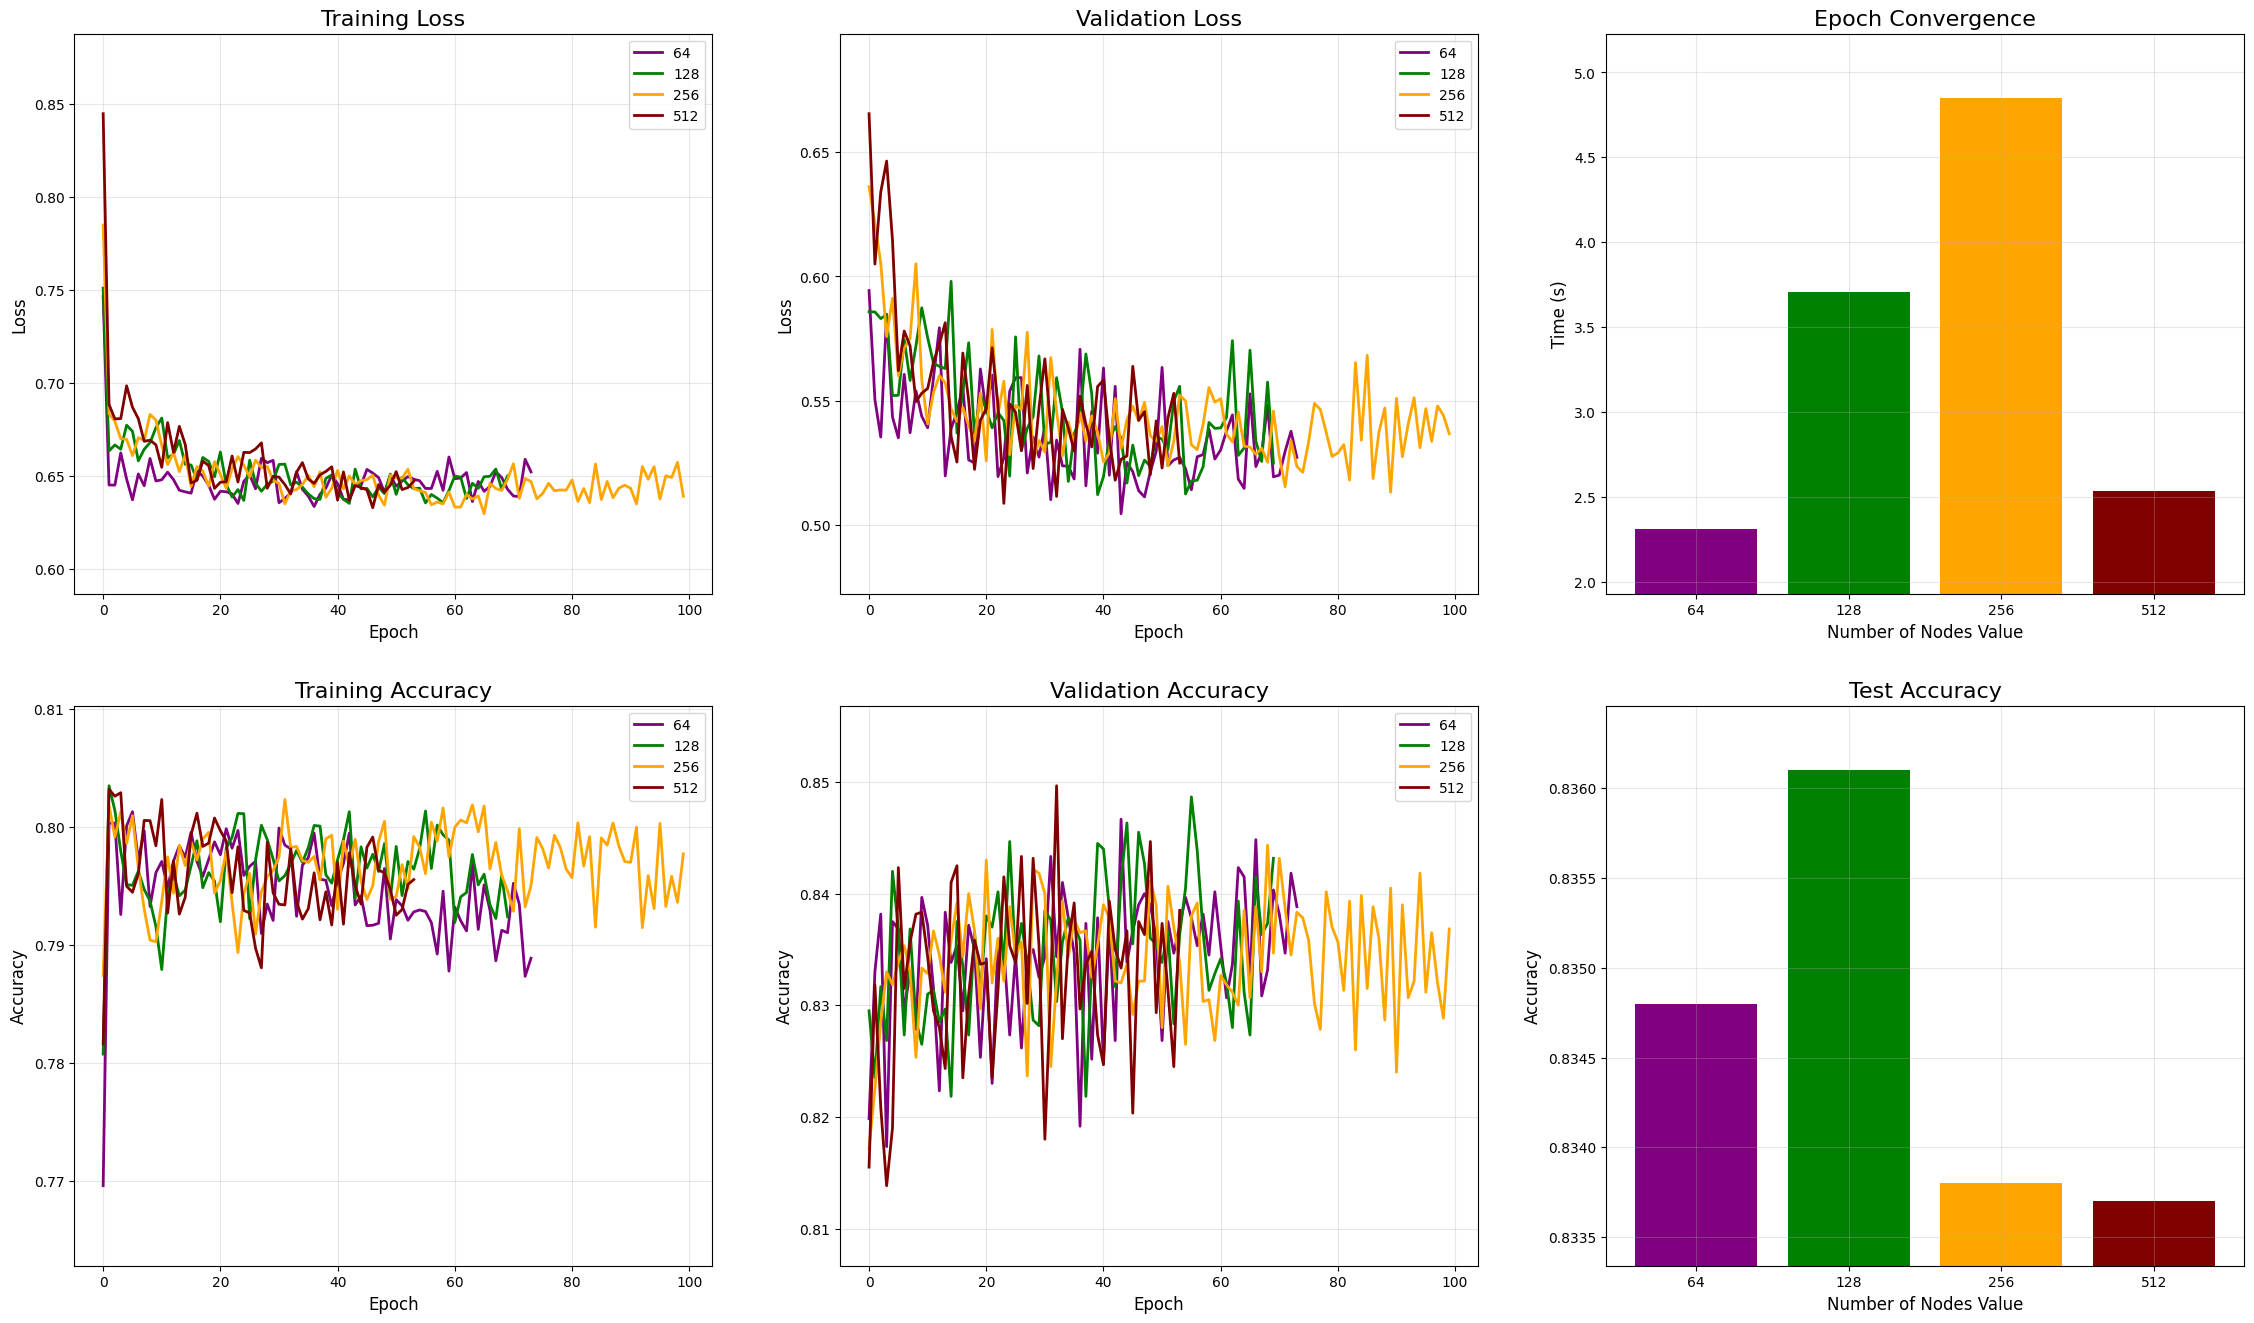

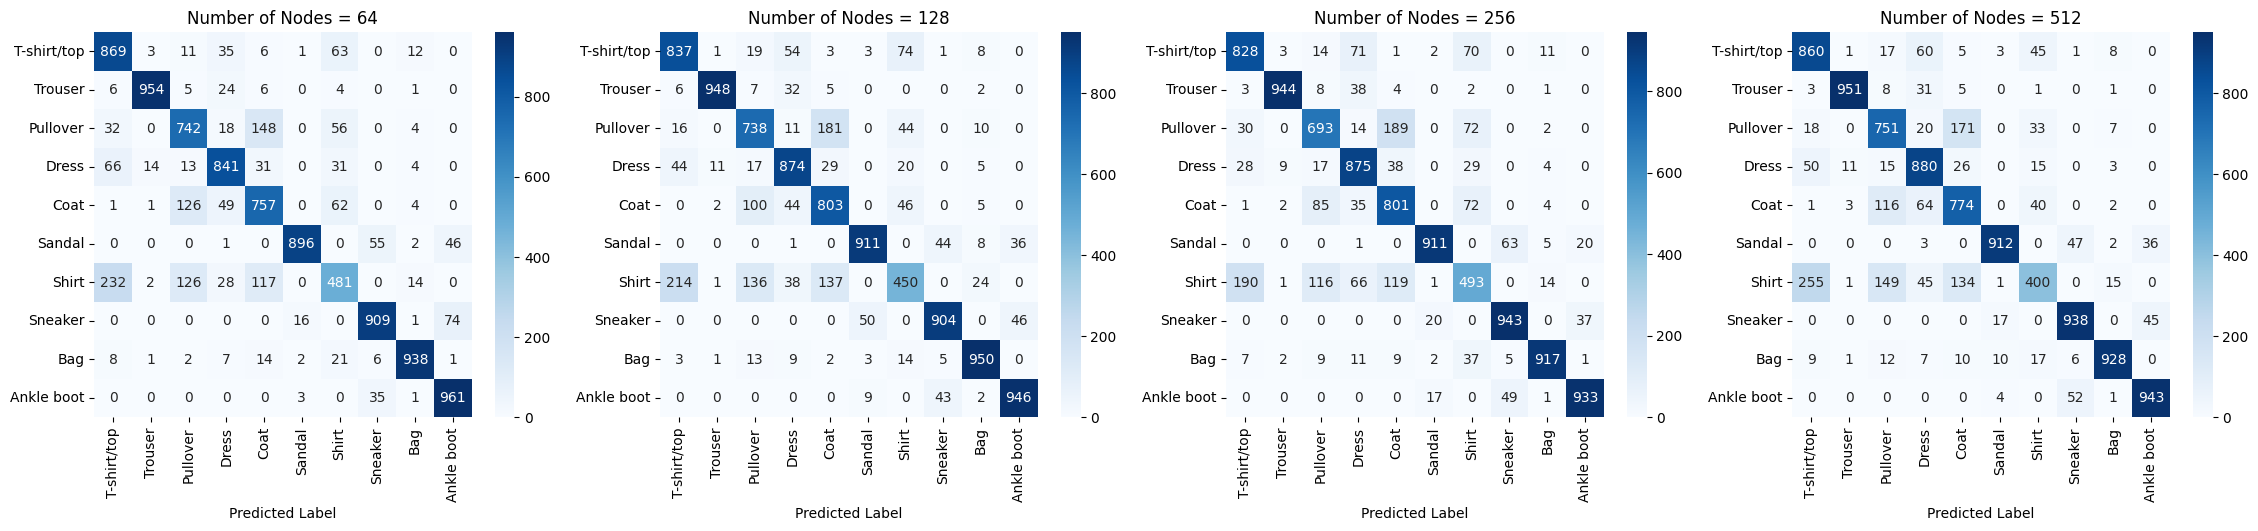

In [20]:
# Create a Visualizer instance
metrics_nodes = {} 
cms_nodes = {}

for n in nodes_list:
    print(f"\nTuning Nodes = {n}")
    # Build, train, and evaluate using fixed parameters
    result = build_train_evaluate(fixed_num_layers, n, fixed_dropout, fixed_lr, fixed_batch)
    
    # Store results
    metrics_nodes[n] = result         # Entire metrics dictionary is stored
    cms_nodes[n] = result['cm']       # Extract and store the confusion matrix

# Plot performance metrics
viz.plot_metrics(metrics_nodes, 'Number of Nodes', nodes_list)

# Plot confusion matrix heatmaps
viz.plot_confusion_matrix(cms_nodes, 'Number of Nodes', nodes_list, class_names)

#### Results Analysis:

Training and validation curves shows that a hidden layer with 128 neurons has the best balance of learning and generalization. Training loss stabilizes at ~0.65, while validation loss is the lowest at 0.47–0.48, compared to 0.50–0.51 for 64 neurons and 0.48–0.49 for 256 neurons. Notably, the 128-neuron and 256-neuron models yield nearly identical training outcomes—both at a training accuracy of 0.81—but the 128-neuron model  has a higher validation accuracy of 0.84–0.85 versus 0.83–0.84 for 256 neurons. I’ll choose 128 neurons since it maintains this performance with a simpler architecture, reducing the overfit probability and enhancing the speed of convergence.

Analyzing test accuracy, the 128-neuron model achieves the highest test accuracy at 0.836, outperforming the 64-neuron model, 256-neuron model, and 512-neuron model. The 64-neuron model’s lower validation stability may suggests underfitting, while the 256-neuron and 512-neuron model performance suggest their overfit.



The confusion matrices reveals that ramping up neuron count enhances classification for tricky classes like shirts and pullovers, but larger models bring trade-offs and diminishing return to scale. For shirts misclassified as T-shirts/tops, the count falls from 232 with 64 neurons to 214 with 128 neurons (a 7.8% drop), then to 190 with 256 neurons (11.2% worse of 128) and 185 with 512 neurons (just 2.6% more), showing diminishing returns past 256. Pullovers classifies best with 128 neurons at 738 correct, edging past 64’s 742 (0.5% worse), 256’s 693 (6.1% worse) and 512’s 701 (5.0% worse), while coats jump from 742 with 64 to 803 with 128 (8.2% better) and reduces to 774 with 512 (3.6% worse), suggest overfitting in more complex ones.

For simpler classes sandals increases from 896 correct with 64 neurons to 911 with 128 and 256 (1.7% better), going to 912 with 512 (Not significant). while sneakers drops from 909 with 64 to 903 with 128, then 902 and 905, and bags increases from 938 corrcts at 64 neurons to 950, 952, and 951 showing no signifcant improve beyond 128. In my opinion, these shows that extra neurons past 128 add noise more than signal. The 128-neuron model thus optimizes generalization-underfitting balance.

In [1]:
chosen_nodes = 128

#### Tuning Number of Layers 


Tuning Number of Layers = 1

Tuning Number of Layers = 2

Tuning Number of Layers = 3

Tuning Number of Layers = 4


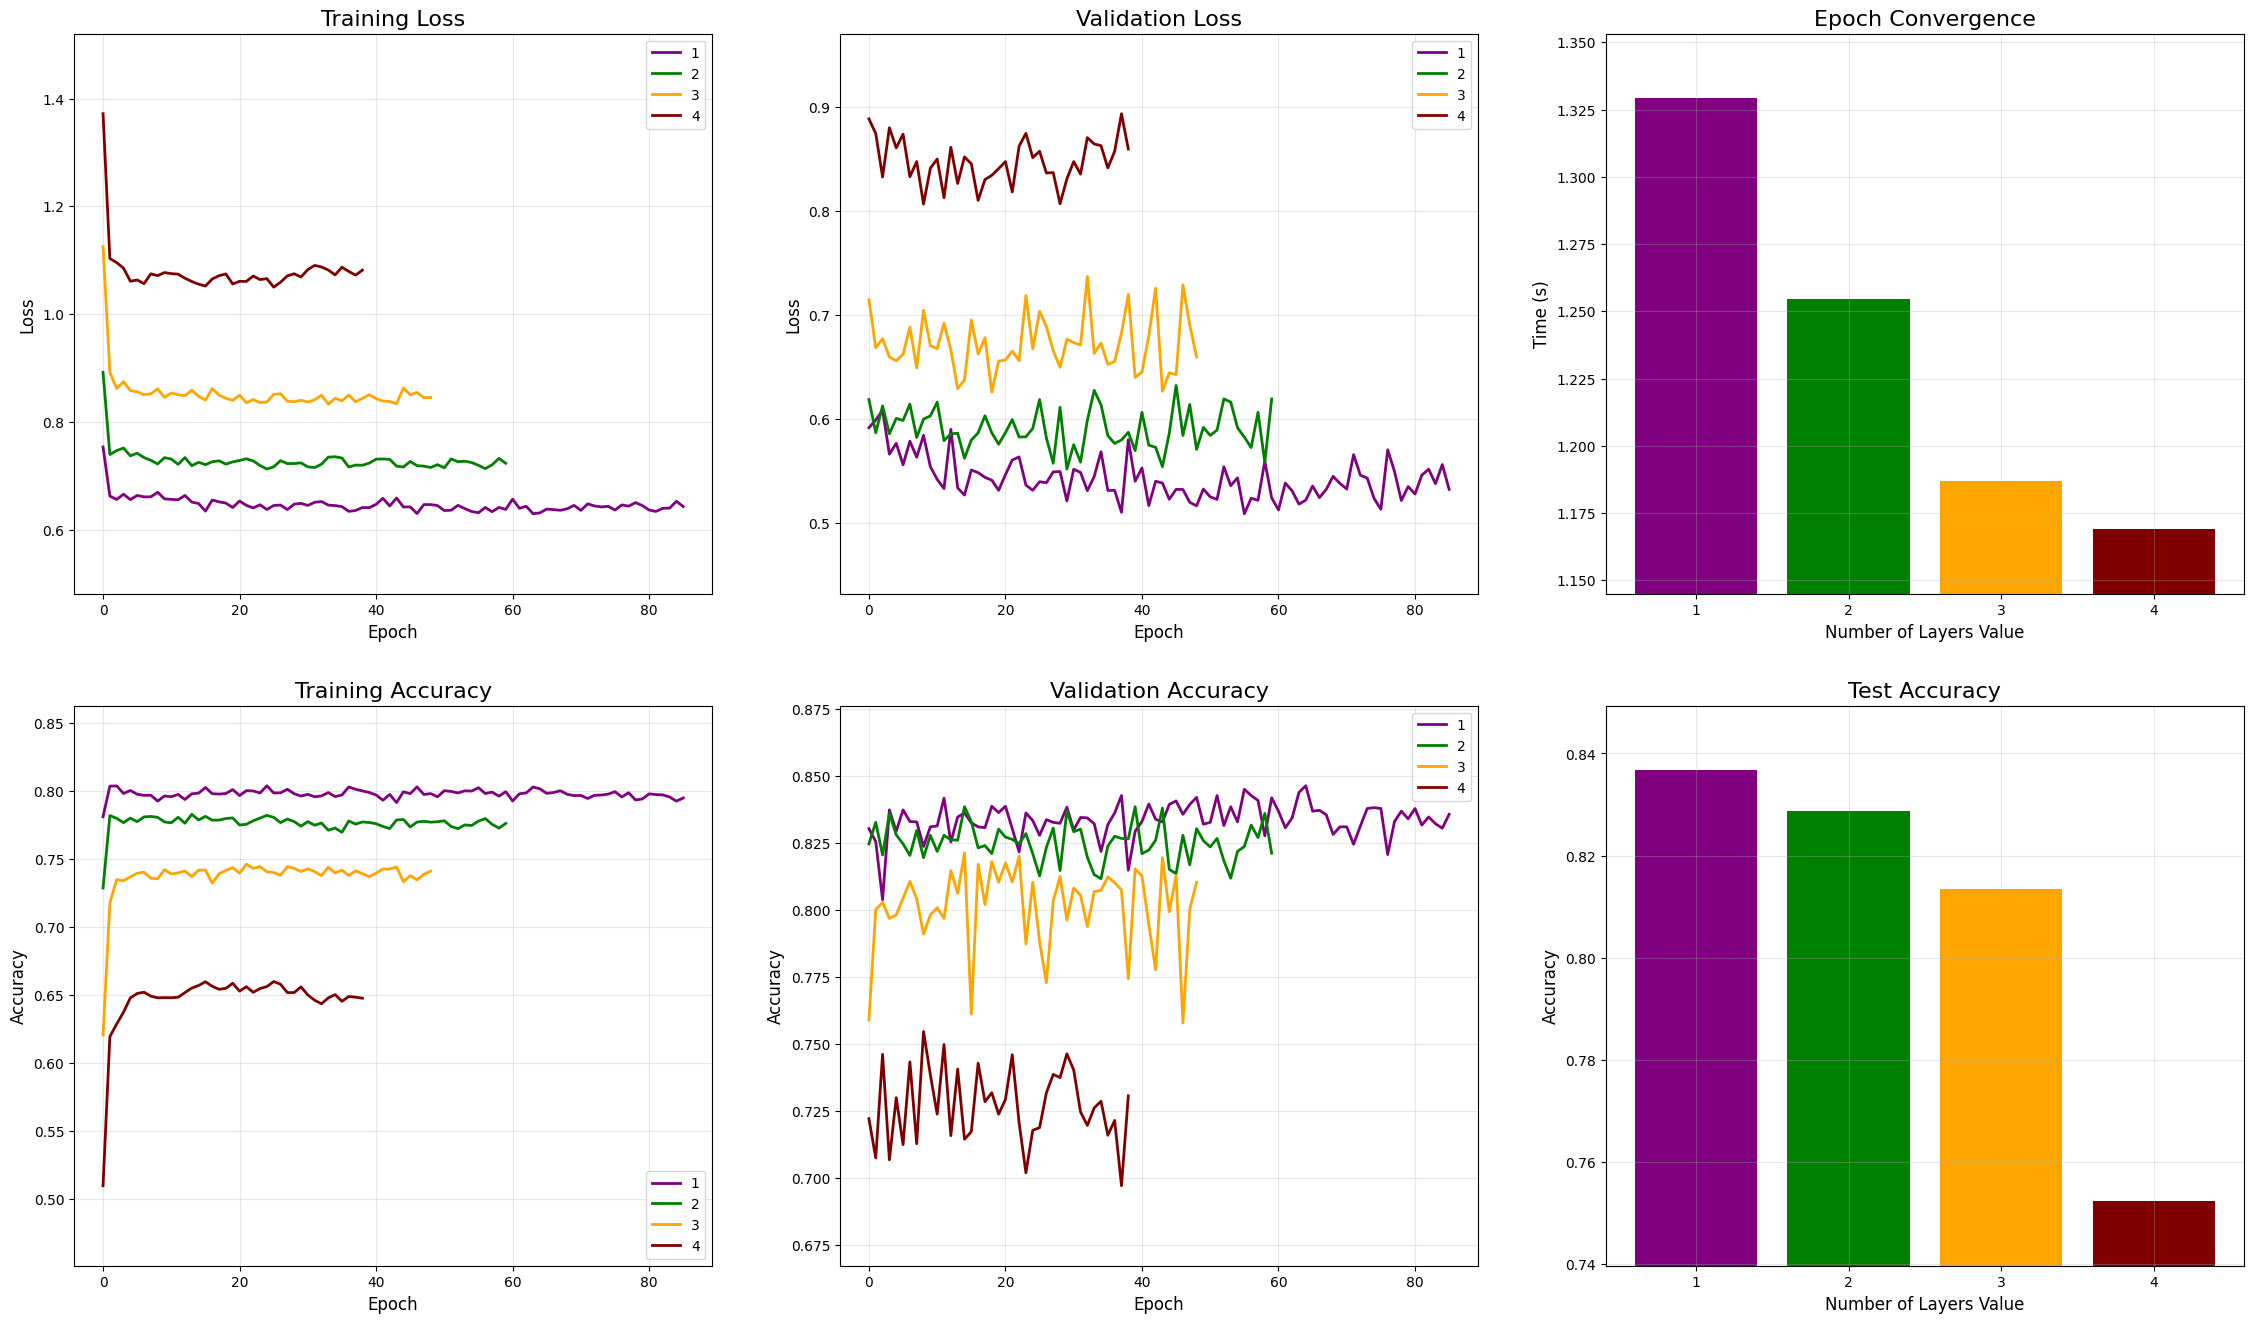

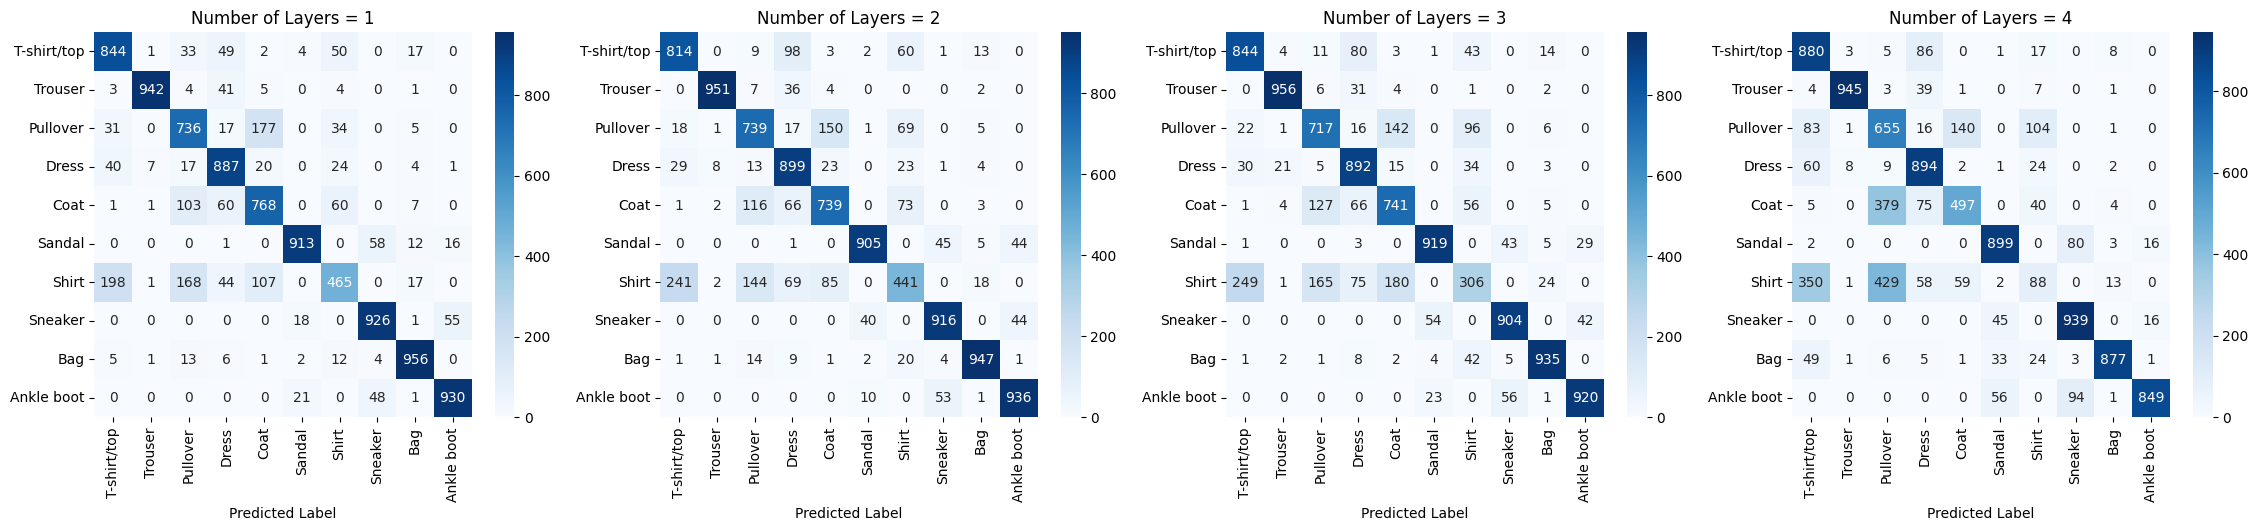

In [22]:
metrics_num_layers = {}
cms_num_layers = {}  # Dictionary to store confusion matrices

for n in num_layers_list:
    print(f"\nTuning Number of Layers = {n}")
    
    # Use fixed_nodes, fixed_dropout, fixed_lr, fixed_batch for this tuning
    result = build_train_evaluate(n, fixed_nodes, fixed_dropout, fixed_lr, fixed_batch)
    
    # Store results
    metrics_num_layers[n] = result         # Store the entire metrics dictionary
    cms_num_layers[n] = result['cm']       # Extract and store the confusion matrix

# Plot performance metrics
viz.plot_metrics(metrics_num_layers, 'Number of Layers', num_layers_list)

# Plot confusion matrix heatmaps
viz.plot_confusion_matrix(cms_num_layers, 'Number of Layers', num_layers_list, class_names)

#### Results Analysis:

The training and validation curves shows that the 1-layer model has the best balance of learning and generalization. Training loss stabilizes around 0.6 across all models, but validation loss is lowest and most stable at 0.5–0.6 for the 1-layer model, compared to 0.5–0.7 for 2 layers, 0.6–0.9 for 3 layers, and 0.5–0.9 for 4 layers, with the latter showing the greatest fluctuation. Training accuracy reaches approximately 0.85 for both the 1-layer and 2-layer models, but drops to 0.70–0.75 for 3 layers and 0.65–0.70 for 4 layers. Validation accuracy peaks at 0.85 for the 1-layer model, while it ranges from 0.80–0.85 for 2 layers, 0.75–0.85 for 3 layers, and 0.70–0.75 for 4 layers. The 1-layer model, converging in 1,325 seconds (versus 1,250 seconds for 2 layers, 1,175 seconds for 3 layers, and 1,150 seconds for 4 layers), offers simplicity and efficiency with minimal overfitting risk.

Test accuracy is consistent with previous results indicating the 1-layer model achieves the highest score of 0.84 vs. 0.82 for 2-layer model, 0.80 for 3-layer, and 0.74 for 4-layer model. The decline in test accuracy as layers increase aligns with the validation trends, where the 3-layer and 4-layer models were less stable and had higher validation loss, suggesting overfitting.

The confusion matrices reveals that adding layers often degrades performance, specially in challenging classes. For shirts misclassified as T-shirts/tops, the count increases from 198 with 1 layer to 241 with 2 layers (a 21.7% rise), 249 with 3 layers (a 3.3% further increase), and 350 with 4 layers (a 40.6% increase from 3 layers). Pullovers correctly identified peak at 739 with 2 layers, slightly above 736 with 1 layer (a 0.4% improvement), but fall to 717 with 3 layers (a 2.6% drop from 2 layers) and 655 with 4 layers (an 11.2% drop from 2 layers). Coats drop from 768 correct with 1 layer to 739 with 2 layers (a 3.8% decline) and plummet to 497 with 4 layers (a 35.3% decline from 1 layer). For simpler classes like sandals, correct predictions declines from 913 with 1 layer to 905 with 2 layers (0.9%), 919 with 3 layers (a 0.7% improvement from 1 layer), and 889 with 4 layers (a 3.3% decline from 1 layer).

In [23]:
chosen_num_layers = 1

#### Tuning  Dropout Rate


Tuning Dropout = 0.0

Tuning Dropout = 0.15

Tuning Dropout = 0.3

Tuning Dropout = 0.45


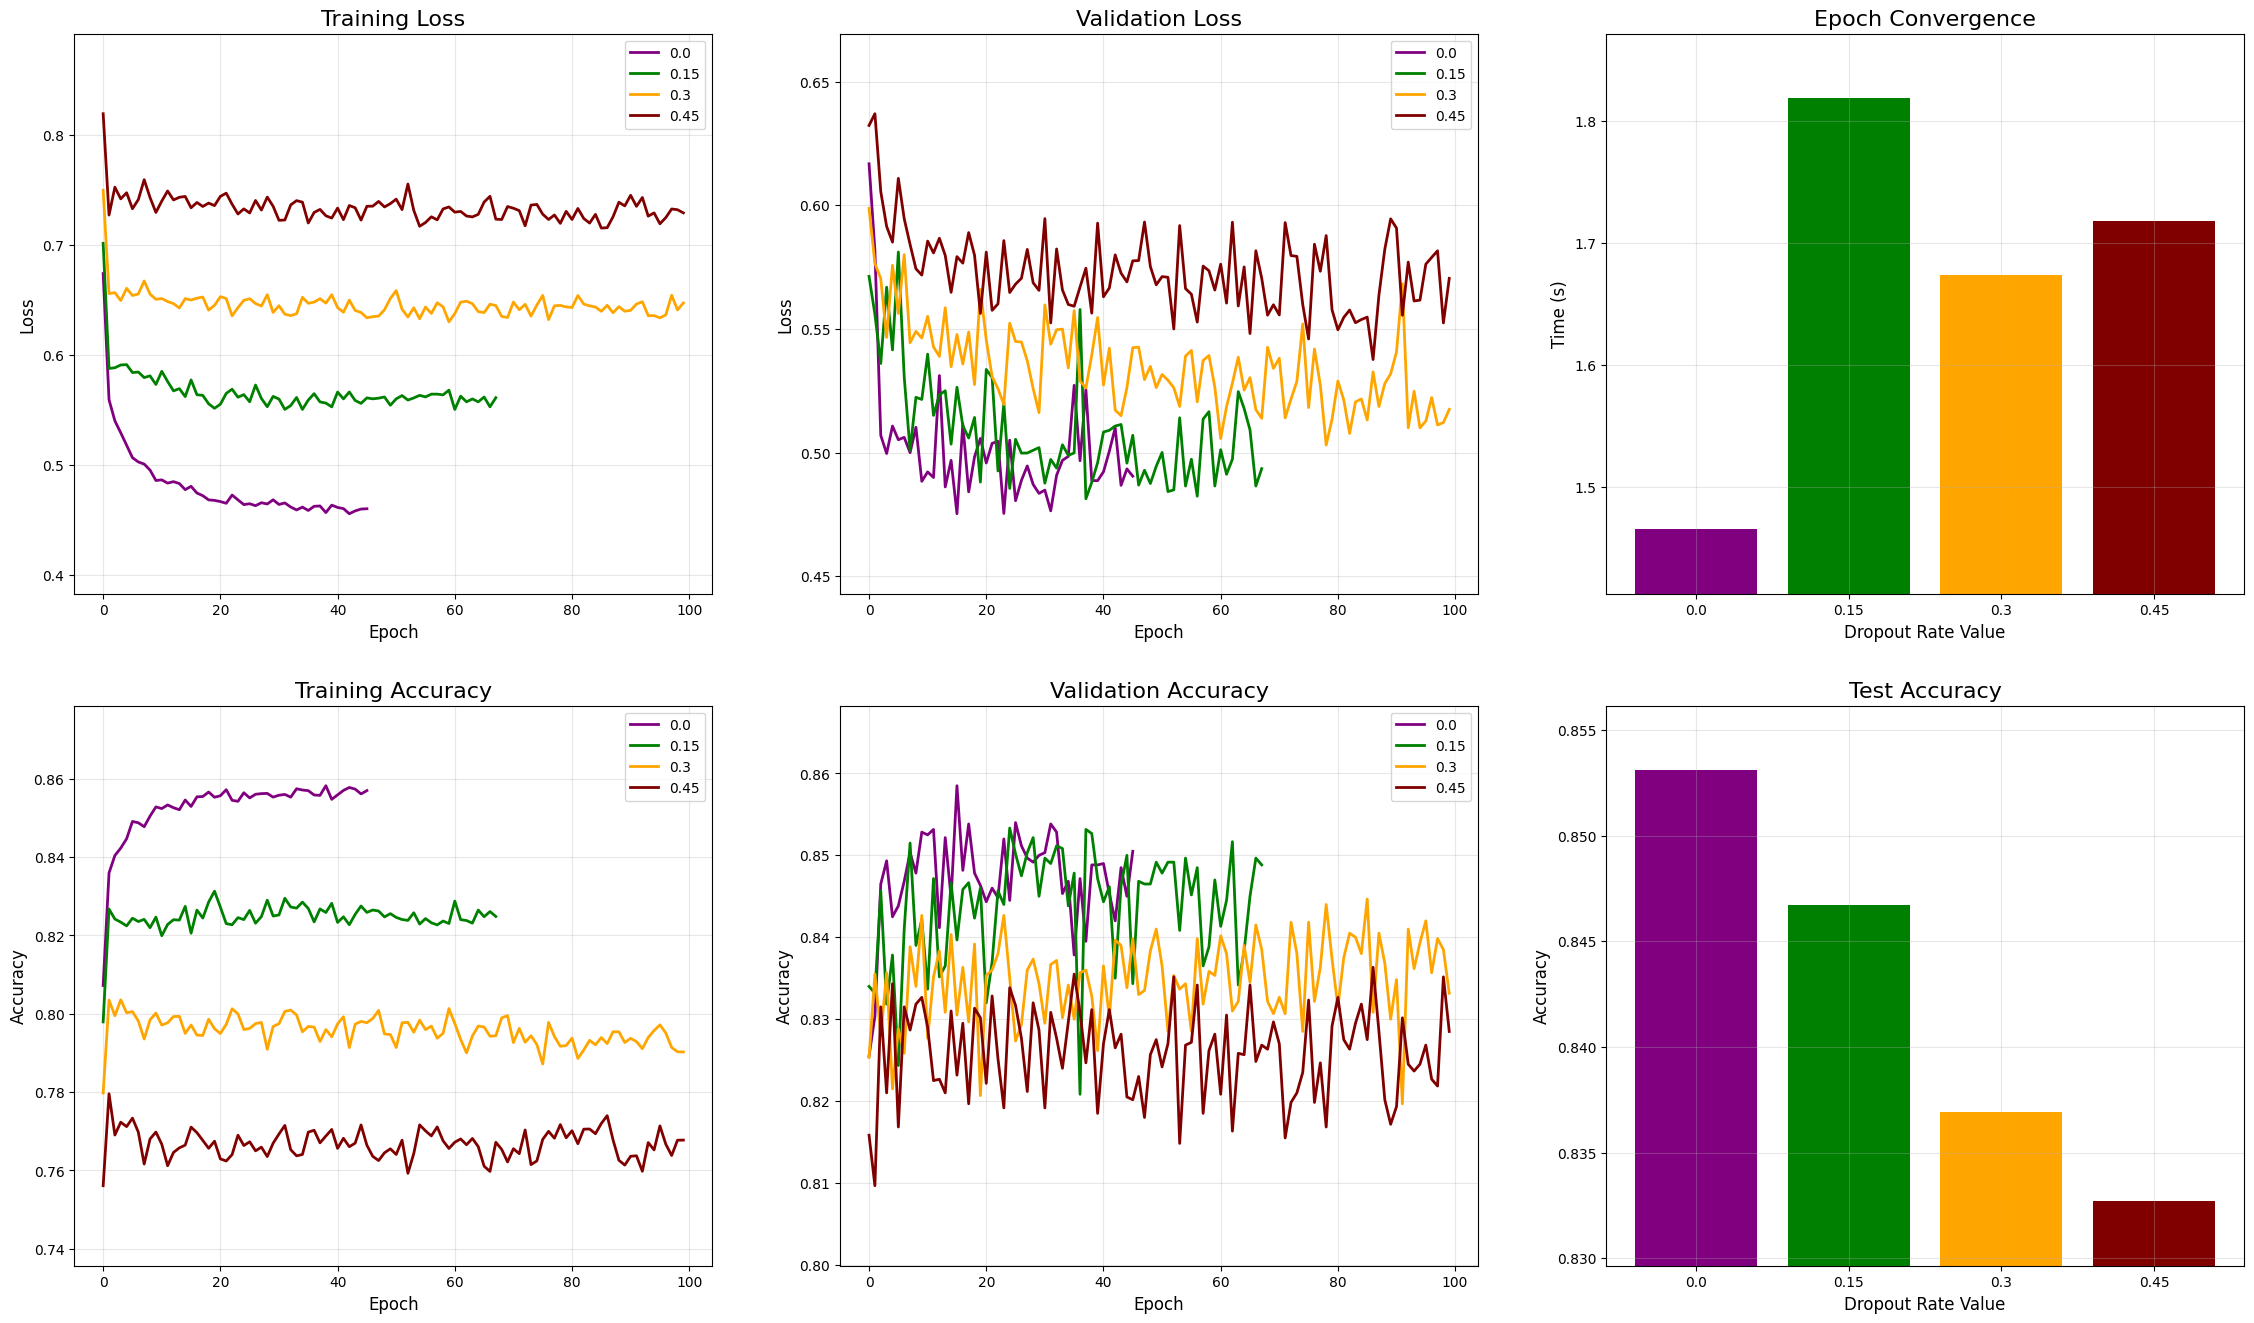

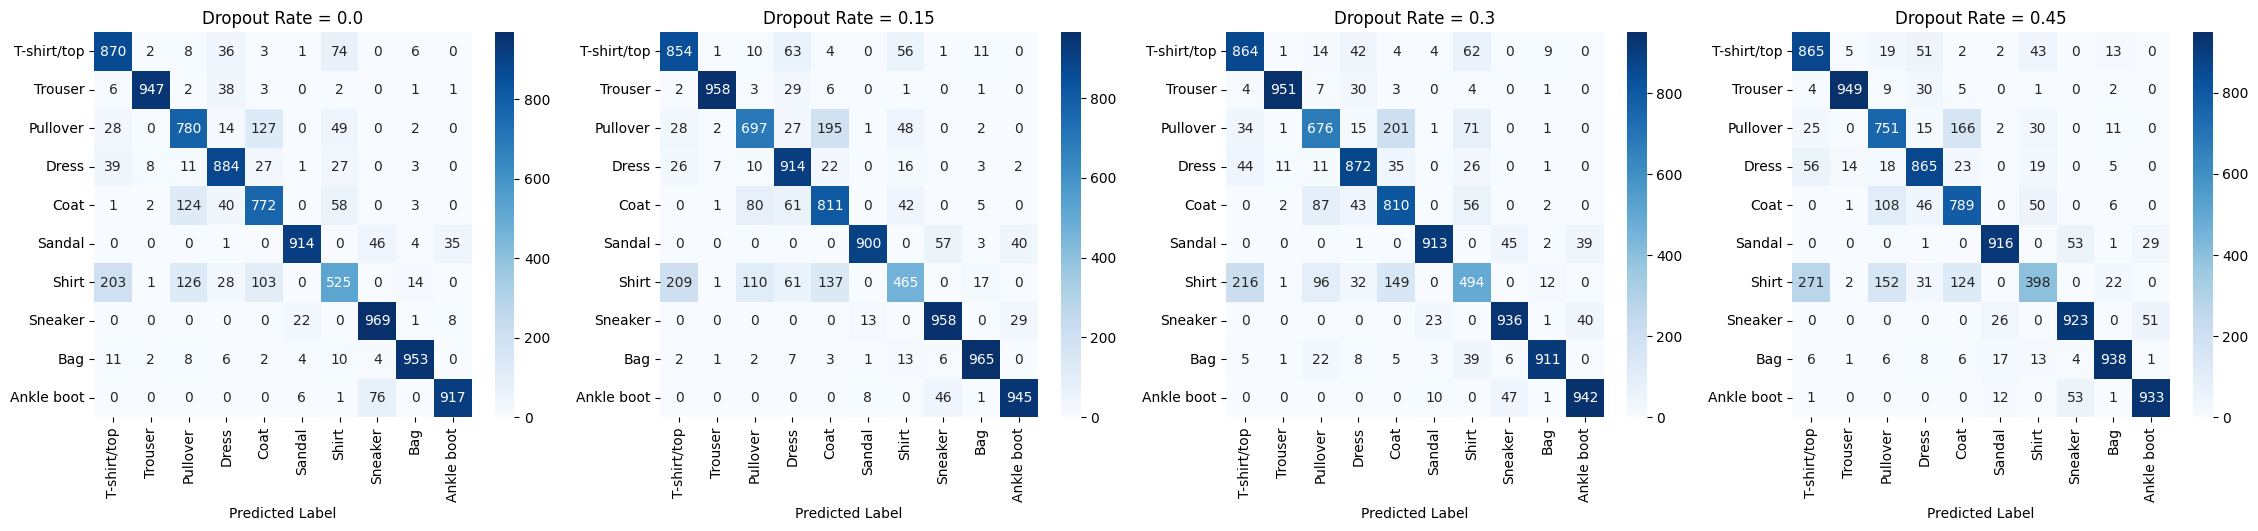

In [24]:
metrics_dropout = {}
cms_dropout = {}  # Dictionary to store confusion matrices

for dr in dropout_list:
    print(f"\nTuning Dropout = {dr}")
    
    # Use chosen_num_layers, chosen_nodes, fixed_lr, fixed_batch for this tuning
    result = build_train_evaluate(chosen_num_layers, chosen_nodes, dr, fixed_lr, fixed_batch)
    
    # Store results
    metrics_dropout[dr] = result         # Store the entire metrics dictionary
    cms_dropout[dr] = result['cm']       # Extract and store the confusion matrix

# Plot performance metrics
viz.plot_metrics(metrics_dropout, 'Dropout Rate', dropout_list)

# Plot confusion matrix heatmaps
viz.plot_confusion_matrix(cms_dropout, 'Dropout Rate', dropout_list, class_names)

In [25]:
chosen_dropout = 0

#### Tuning Batch Size


Tuning Batch Size = 32

Tuning Batch Size = 128

Tuning Batch Size = 256

Tuning Batch Size = 512


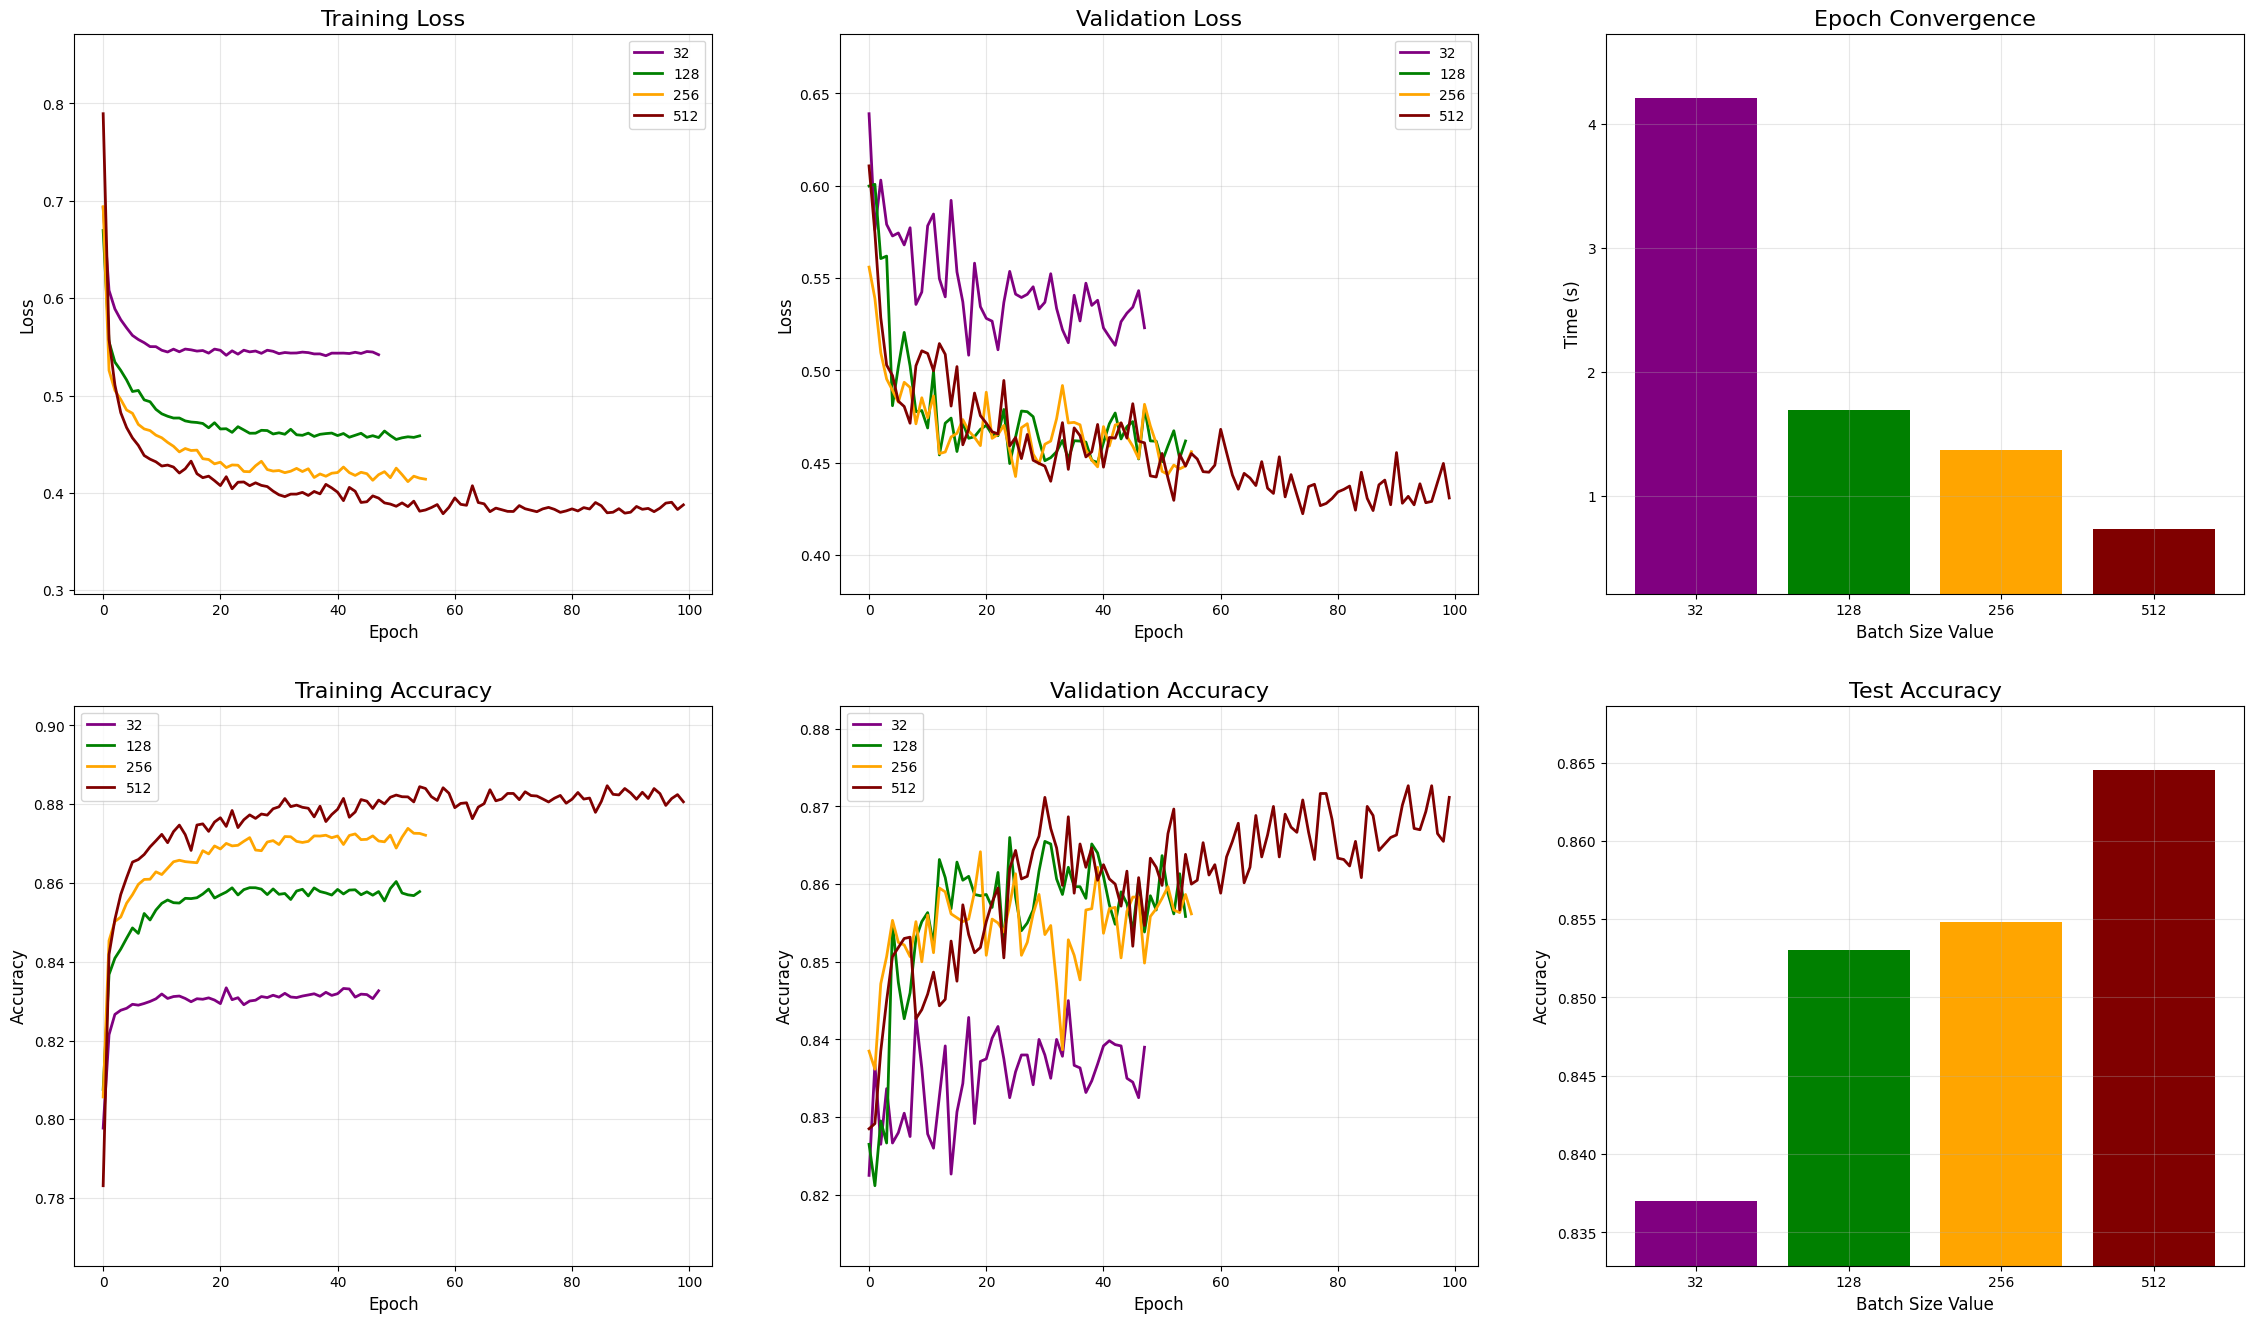

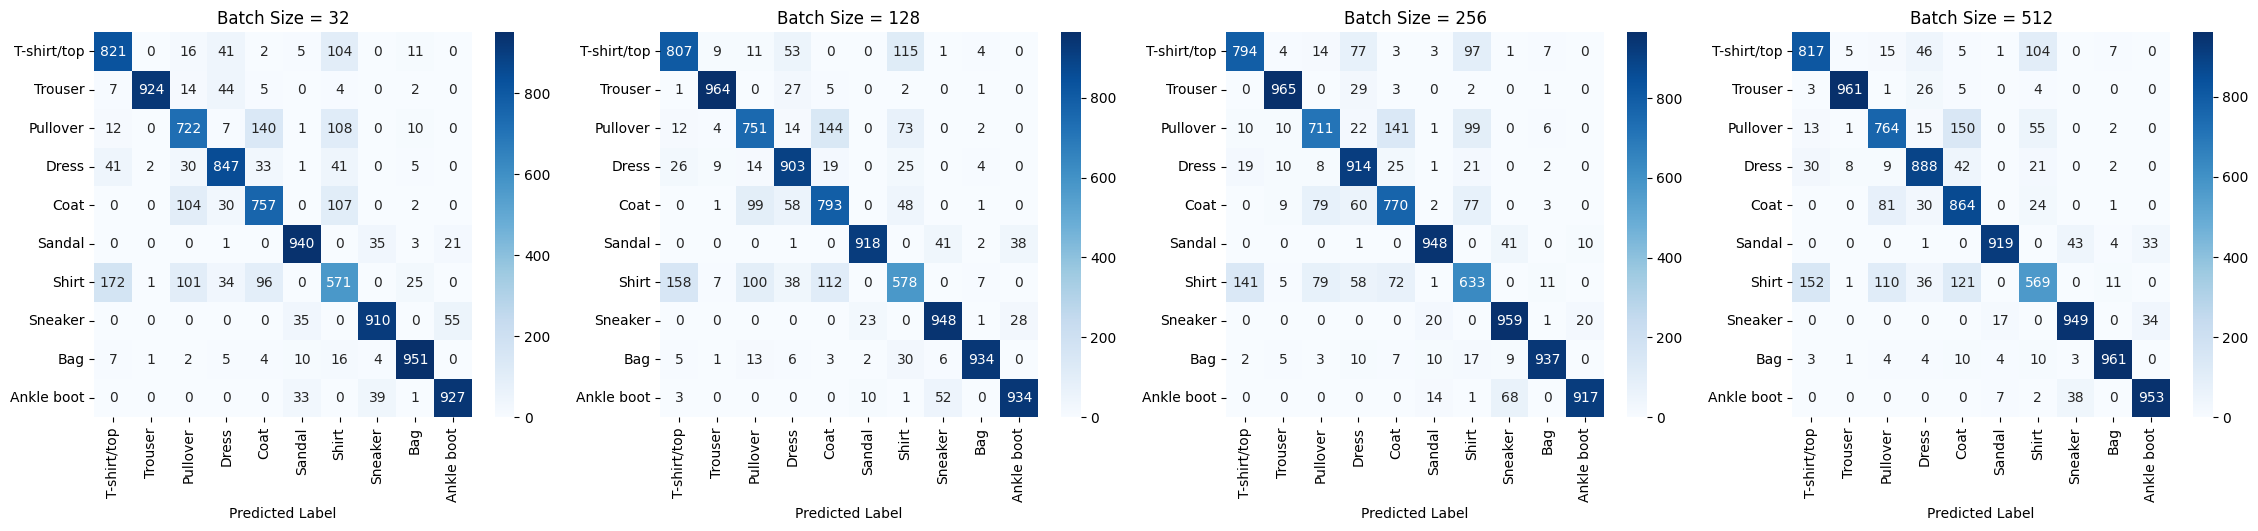

In [26]:
metrics_batch = {}
cms_batch = {}  # Dictionary to store confusion matrices

for bs in batch_size_list:
    print(f"\nTuning Batch Size = {bs}")
    
    # Use chosen_num_layers, chosen_nodes, chosen_dropout, fixed_lr for this tuning
    result = build_train_evaluate(chosen_num_layers, chosen_nodes, chosen_dropout, fixed_lr, bs)
    
    # Store results
    metrics_batch[bs] = result       # Store the entire metrics dictionary
    cms_batch[bs] = result['cm']       # Extract and store the confusion matrix

# Plot performance metrics
viz.plot_metrics(metrics_batch, 'Batch Size', batch_size_list)

# Plot confusion matrix heatmaps
viz.plot_confusion_matrix(cms_batch, 'Batch Size', batch_size_list, class_names)

In [27]:
chosen_batch = 128

#### Results Analysis

Training and validation curves show that zero dropout provides the best balance of learning and generalization for the 1-layer, 128-neuron model. Training loss stabilizes at ~0.5 with zero dropout, versus ~0.55–0.6 for 0.15, 0.3, and 0.45, with the latter showing more variability. Validation loss is lowest at ~0.5 for zero dropout, compared to 0.5–0.55 for 0.15, 0.5–0.6 for 0.3, and 0.55–0.65 for 0.45. Training accuracy peaks at ~0.86 with zero dropout, dropping to ~0.84, ~0.82, and ~0.78 for 0.15, 0.3, and 0.45, respectively. Validation accuracy reaches ~0.85 with zero dropout, versus 0.84–0.85, 0.83–0.84, and 0.81–0.83. I’ll choose zero dropout, converging in 1.8 seconds versus 1.5 seconds for 0.45 (a 17% speedup), minimizing overfitting with optimal efficiency.

Analyzing test accuracy, the zero dropout model achieves the highest score at 0.885, outperforming 0.86 for 0.15, 0.84 for 0.3, and 0.83 for 0.45. The decline with higher dropout aligns with validation instability (e.g., 0.81–0.83 for 0.45), suggesting underfitting, while zero dropout maintains a strong balance of complexity and generalization.

The confusion matrix shows that dropout degrades performance, especially for tricky classes. Shirts misclassified as T-shirts/tops rise from 203 with zero dropout to 209 (3.0% increase), 216 (6.4% increase), and 271 (33.5% increase) with 0.45; pullovers drop from 780 correct with zero dropout to 697 (10.6% worse), 676 (13.3% worse), and 751 (3.7% worse); coats fall from 772 to 789 with 0.45 (2.2% worse). For simpler classes, sandals decrease from 914 to 916 with 0.45 (not significant), sneakers from 969 to 922, and bags from 953 to 938, showing no gains. This indicates dropout adds noise, and zero dropout optimizes the generalization-underfitting balance.

#### Tuning Learning Rate


Tuning Learning Rate = 0.0005

Tuning Learning Rate = 0.001

Tuning Learning Rate = 0.005

Tuning Learning Rate = 0.01


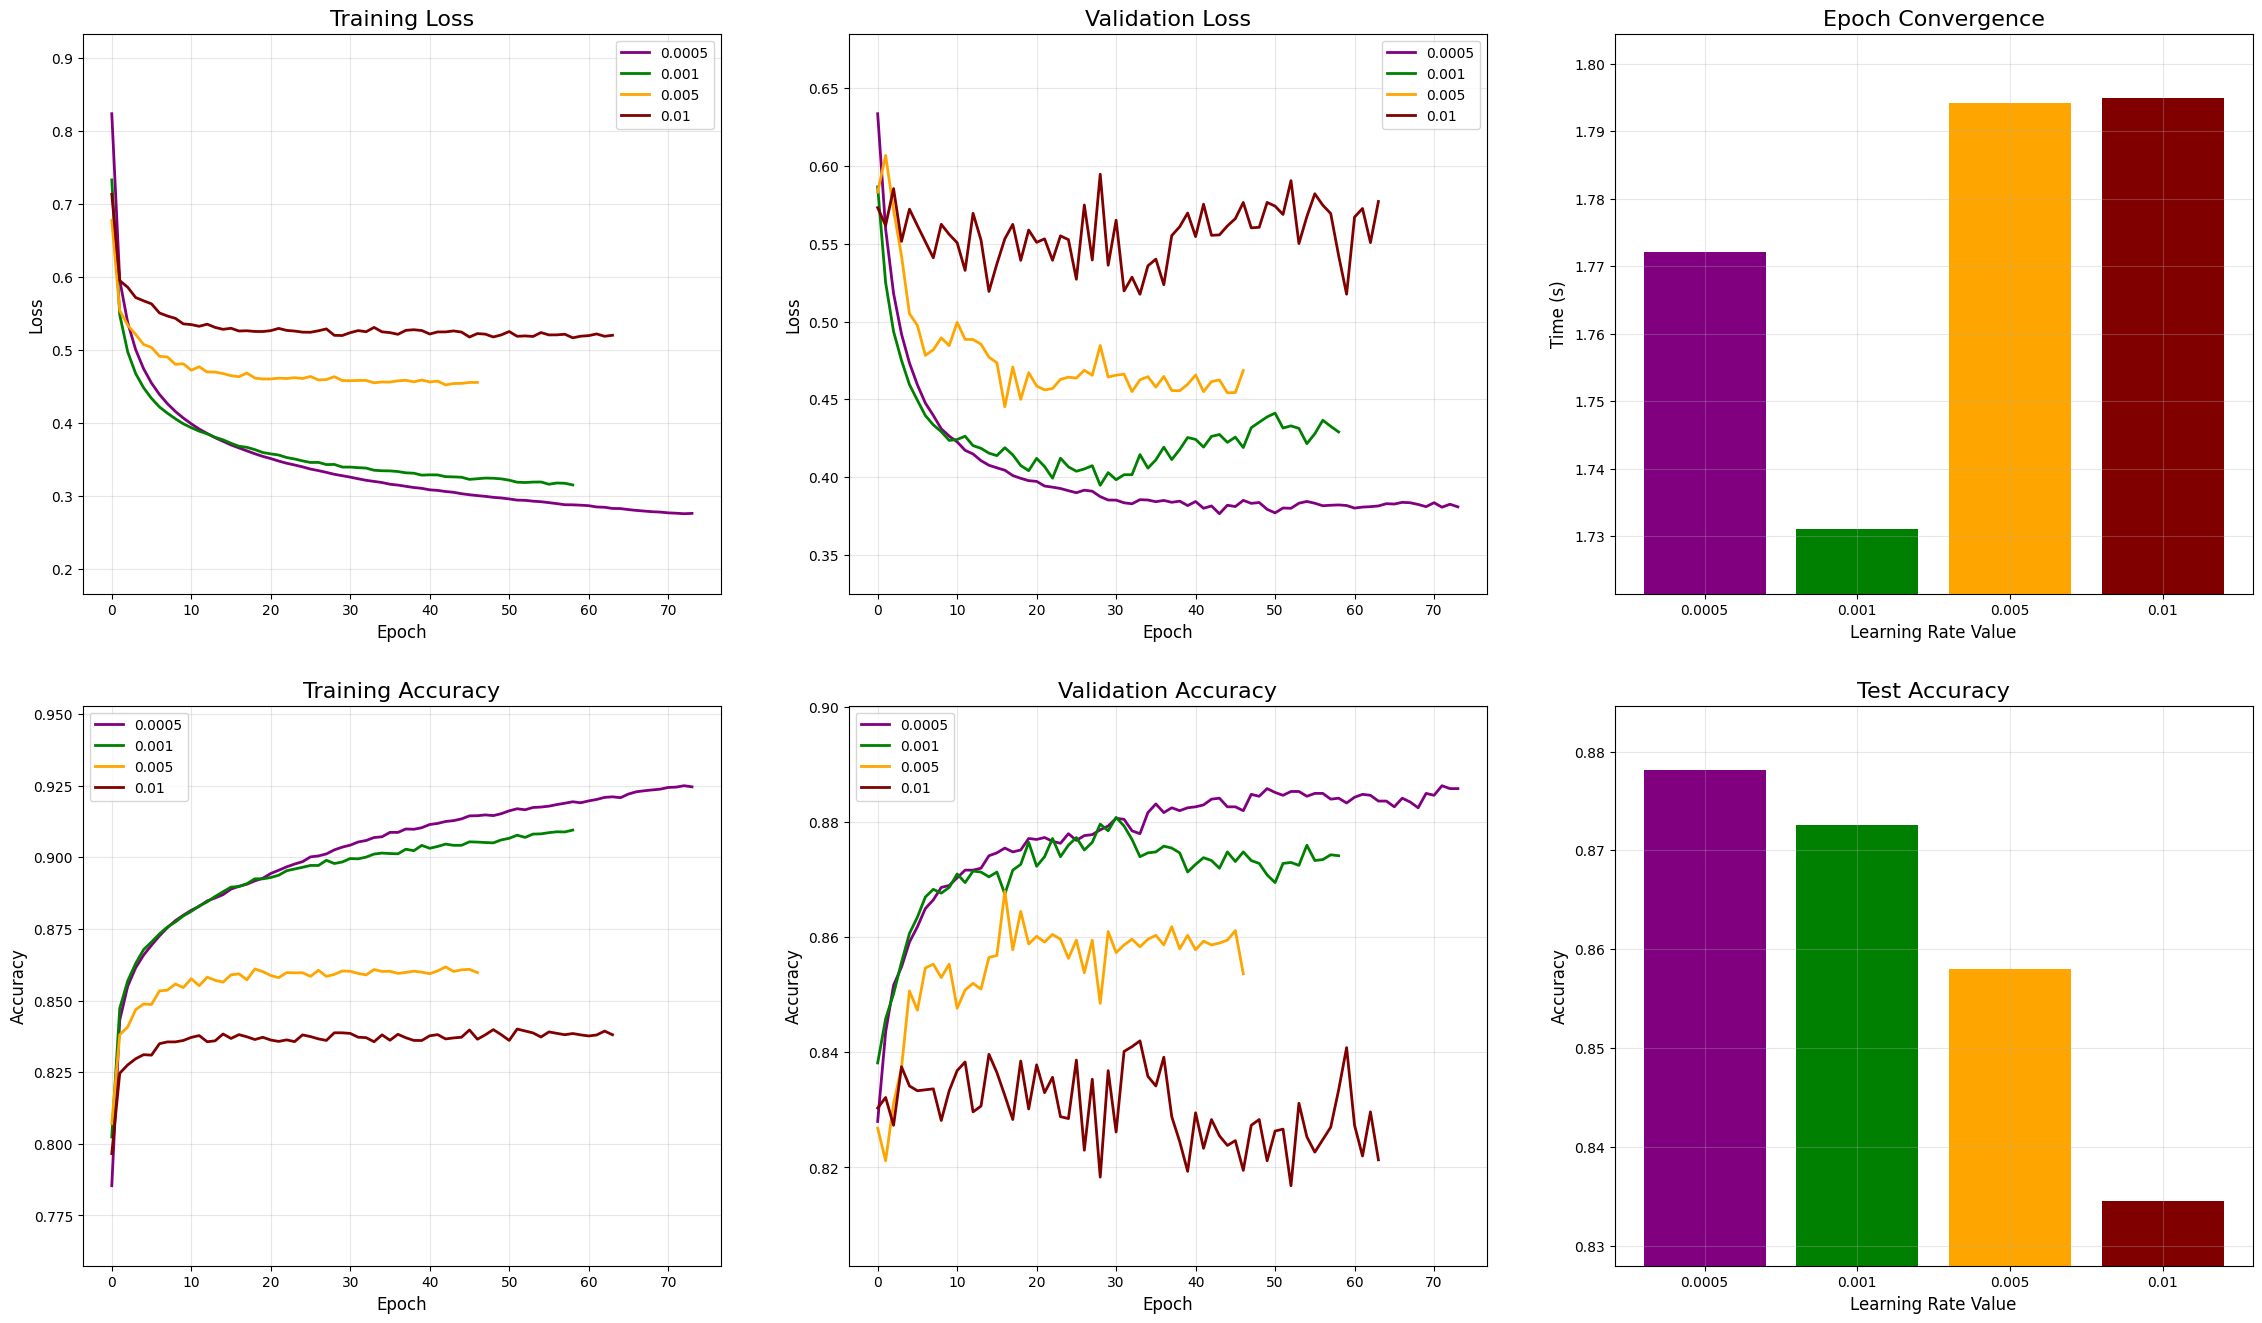

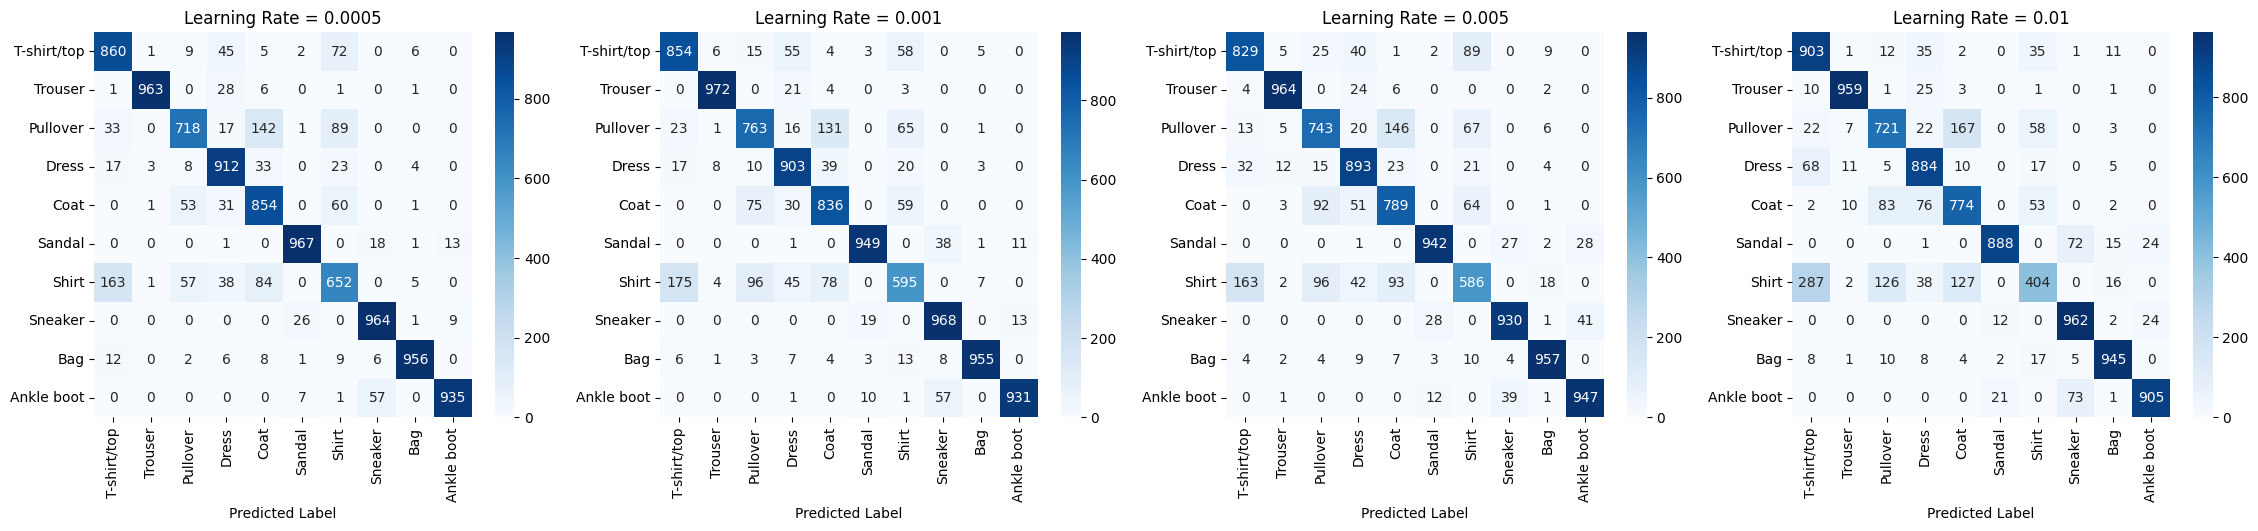

In [28]:
metrics_lr = {}
cms_lr = {}  # Dictionary to store confusion matrices

for lr in lr_list:
    print(f"\nTuning Learning Rate = {lr}")
    
    # Use chosen_num_layers, chosen_nodes, chosen_dropout, chosen_batch for this tuning
    result = build_train_evaluate(chosen_num_layers, chosen_nodes, chosen_dropout, lr, chosen_batch)
    
    # Store results
    metrics_lr[lr] = result       # Store the entire metrics dictionary
    cms_lr[lr] = result['cm']       # Extract and store the confusion matrix

# Plot performance metrics
viz.plot_metrics(metrics_lr, 'Learning Rate', lr_list)

# Plot confusion matrix heatmaps
viz.plot_confusion_matrix(cms_lr, 'Learning Rate', lr_list, class_names)

#### Results Analysis:

he training and validation curves indicate that a learning rate of 0.001 offers the best balance between learning efficiency and generalization. Training loss stabilizes at approximately 0.35 with 0.001, slightly higher than the 0.3 achieved with 0.0005, but it outperforms the 0.45 for 0.005 and 0.5 for 0.01, which exhibit greater fluctuations at higher rates. Validation loss stabilizes at around 0.42 for 0.001, closely following the 0.4 of 0.0005, while rising to 0.45-0.55 for 0.005 and 0.45-0.65 for 0.01, suggesting better stability with lower rates. Training accuracy peaks at 0.925 with 0.0005, while validation accuracy reaches 0.88 for 0.001, indicating a potential overfit on training data with 0.0005, whereas 0.001 maintains a more balanced score between training and validation. Additionally the learning rate of 0.001 is signficantly faster which is another reason for prioritizing it over 0.0005.


The confusion matrices highlight that 0.001 is the best in classifying tricky categories. Pullovers achieve a peak of 763 correct classifications with 0.001, outperforming 718 with 0.0005 (6.2% worse), 743 with 0.005 (2.6% worse), and 721 with 0.01 (5.5% worse). For shirts, 0.001 records 595 correct classifications, compared to 652 with 0.0005 (8.7% increase), 586 with 0.005 (1.5% decrease), and 404 with 0.01 (32.0% decrease). It also maintains strong results for coats (836 vs. 854 for 0.0005, 2.1% worse), sandals (949 vs. 967, 1.9% worse), sneakers (968), and bags (955), with minimal variation across rates.

In [ ]:
chosen_lr = 0.001

#### Final Model with Optimal Parameters


Training Final Model
Final Test Accuracy: 0.8749


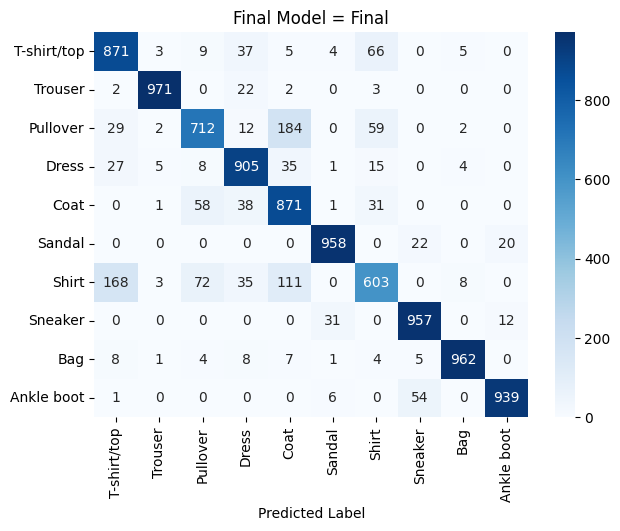

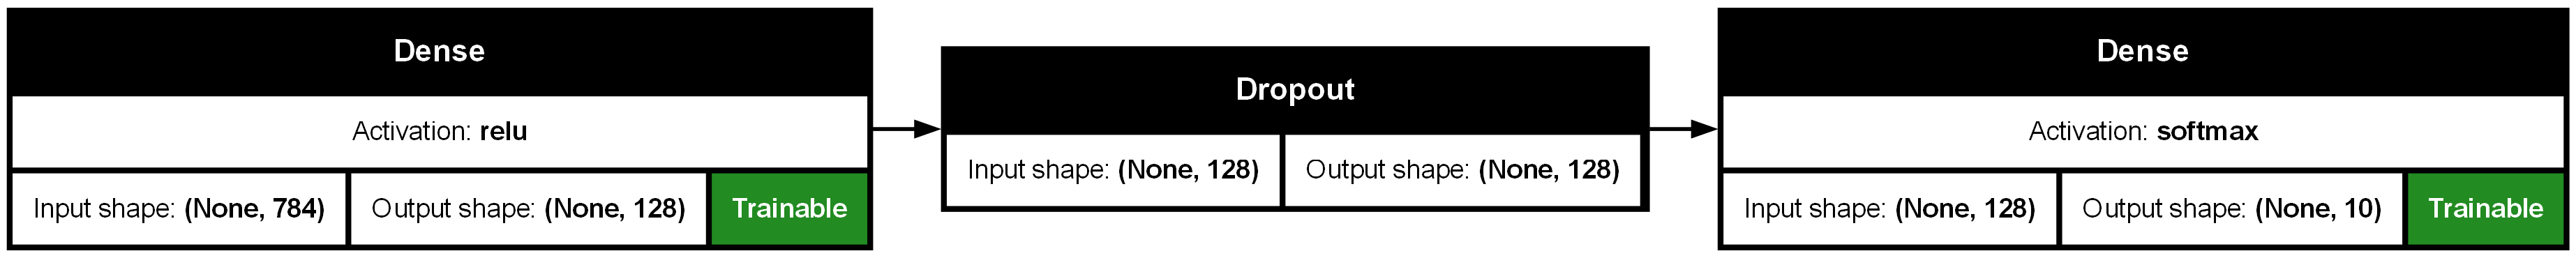

In [30]:
print("\nTraining Final Model")

# Build the final model with chosen hyperparameters
final_builder = ModelBuilder(chosen_num_layers, chosen_nodes, chosen_dropout, chosen_lr)
final_model = final_builder.build()

# Train the final model
history = final_model.fit(
    x_train, y_train,
    epochs=100, batch_size=chosen_batch,
    validation_split=0.1,
    callbacks=callbacks.EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
        ),
    verbose=0
)

# Evaluate the final model
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Generate final confusion matrix
y_pred = np.argmax(final_model.predict(x_test, verbose=0), axis=1)
cm_final = confusion_matrix(y_test, y_pred)

# Store confusion matrix for final model
cms_final = {"Final": cm_final}

# Plot final confusion matrix
viz.plot_confusion_matrix(cms_final, "Final Model", ["Final"], class_names)

# Visualize the final model architecture
plot_model(
    final_model, show_shapes=True,
    rankdir="LR", show_trainable=True,
    show_layer_activations=True
)


## Question 2: Adaline and Madaline 


#### Introduction

In the field of artificial neural networks, **Adaline** and **Madaline** are two classic and important models that are known as pioneers of machine learning.

- **Adaline** is a single-layer perceptron model that uses a linear activation function to process data. Unlike the simple perceptron, which uses a step function for decision-making, Adaline uses the **Mean Squared Error (MSE)** loss function and the **Least Mean Squares (LMS)** method to update the weights. This makes Adaline better at learning linear patterns.

- **Madaline**, which stands for **Multiple Adaptive Linear Neurons**, was introduced as a multilayer version of Adaline, capable of modeling more complex problems. The Madaline model was the first multilayer neural network to use a supervised learning algorithm, known as the **Madaline Rule I (MR1)** and **Madaline Rule II (MR2)**, to adjust the weights. This model improved the learning capability of neural networks and was used to solve non-linear problems.

In this task, we will implement and train both Adaline and Madaline models to solve classification problems with both linear and non-linear datasets.


### 2-1. Adaline 

In this section, we will train an **Adaline** model using the **Wine dataset** to distinguish between different types of wine. Specifically:

- **(a)** We will visualize the data using a scatter plot of the first two features: **Alcohol** and **Malic Acid**, then train the Adaline model to distinguish **Class 1** from the others. We will also plot the **Mean Squared Error (MSE)** curve during training.
  
- **(b)** We will then train the Adaline network for **Class 2 vs Non-Class 2** classification and evaluate the performance.

### 2-2. Madaline

In this section, we will implement a Madaline network on a synthetic dataset. First, research and review the MR1 and MR2 algorithms.

For training, use the synthetic dataset as shown in the code below. Train the network using either the MR1 or MR2 algorithm. Then, separate the points using different numbers of neurons (3 neurons, 5 neurons, and 8 neurons). Finally, display the separation accuracy for all cases. (50 points)

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

np.random.seed(42)

X, y = make_gaussian_quantiles(n_samples=300, n_features=2, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, marker='o', edgecolors='k')
plt.title('Nonlinear Separable Data (make_gaussian_quantiles)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
```


## 2.1. Answer

In [2]:
# Import necessary libraries for data handling, modeling, and visualization
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import plot_model  # Imported as in original code

# Suppress TensorFlow and Python warnings to keep output clean
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO and WARNING messages from TensorFlow
warnings.filterwarnings('ignore')         # Ignore Python warnings
tf.get_logger().setLevel('ERROR')         # Further reduce TensorFlow logging verbosity

# Set path for model visualization for Graphviz (important for plot_model to work)
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [10]:
def plot_decision_boundary(X, y_binary, model, title, 
                           feature_names=['Feature 1', 'Feature 2'], 
                           figsize=(5.2, 3.9)):
    """
    Plot the decision boundary and data points for a given dataset and model.
    
    Parameters:
    - X (ndarray): Input features to plot.
    - y_binary (ndarray): Binary labels (0 or 1) for coloring points.
    - model: Trained Adaline model.
    - title (str): Title for the plot.
    - feature_names (list): Names of the two features for axis labels.
    - figsize (tuple): Figure size (width, height).
    """
    # Define padding to extend the grid beyond data points
    padding = 1
    
    # Create a meshgrid for contour plotting
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min() - padding, X[:, 0].max() + padding, 200),
        np.linspace(X[:, 1].min() - padding, X[:, 1].max() + padding, 200)
    )
    
    # Combine grid points into a single array for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict model outputs over the grid
    pred = model.predict(grid, verbose=0).reshape(xx.shape)

    # Set up a new figure for plotting
    plt.figure(figsize=figsize)
    
    # Plot filled contours to show decision regions
    plt.contourf(
        xx, yy, pred,
        levels=np.linspace(pred.min(), pred.max(), 20),
        alpha=0.7, cmap='coolwarm'
    )
    
    # Add a distinct contour line at the decision threshold (0.5)
    plt.contour(
        xx, yy, pred,
        levels=[0.5], colors='black',
        linewidths=2, linestyles='--'
    )
    
    # Scatter plot of the actual data points
    scatter = plt.scatter(
        X[:, 0], X[:, 1], c=y_binary,
        cmap='coolwarm', edgecolors='k',
        s=20, alpha=0.9, label='Data Points'
    )
    
    # Customize the plot with title, labels, and grid
    plt.title(title, fontsize=11, pad=12)
    plt.xlabel(feature_names[0], fontsize=8)
    plt.ylabel(feature_names[1], fontsize=8)
    plt.colorbar(scatter, label='Class Label', pad=0.1)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(loc='upper right', fontsize=6)
    plt.tight_layout()
    
    # Display the plot
    plt.show()

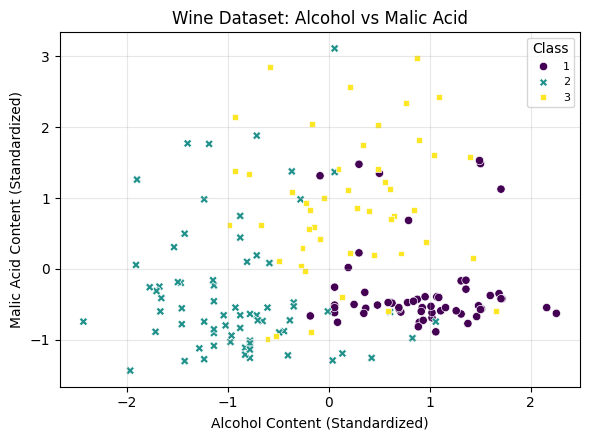

In [4]:
# Load Wine dataset
wine = load_wine()
X = wine.data[:, [0, 1]].astype('float16')  # Using only Alcohol & Malic Acid
y = wine.target.astype('int16') + 1         # Shift class labels from {0,1,2} to {1,2,3}

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Visualize Dataset
plt.figure(figsize=(6, 4.5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=y, palette='viridis', style=y)
plt.title('Wine Dataset: Alcohol vs Malic Acid', fontsize=12)
plt.xlabel('Alcohol Content (Standardized)', fontsize=10)
plt.ylabel('Malic Acid Content (Standardized)', fontsize=10)
plt.legend(title='Class', loc='upper right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Convert labels to binary classification (Class 1 vs Others)
y_train_binary_a = np.where(y_train == 1, 1, 0)
y_test_binary_a = np.where(y_test == 1, 1, 0)

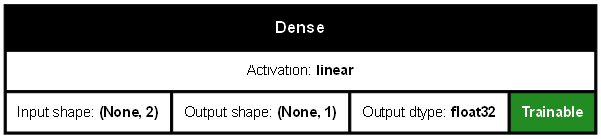

In [7]:
# Define Adaline Model
adaline_a = models.Sequential([
    layers.Dense(1, activation='linear', input_shape=(2,))
])

# Compile Model
adaline_a.compile(optimizer=optimizers.SGD(learning_rate=0.002), loss='mse', metrics=['accuracy'])

# Train Model Using TensorFlow's Built-in Validation Split (20% of Training Data)
history_a = adaline_a.fit(
    X_train, y_train_binary_a,
    epochs=250, batch_size=32,
    validation_split=0.2, 
    callbacks=callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss', save_best_only=True,
        verbose=0),
    verbose=0
)

# Model Architecture Visualization
plot_model(adaline_a, show_shapes=True, show_dtype=True, rankdir="TB", show_layer_activations=True, show_trainable=True, dpi=75)

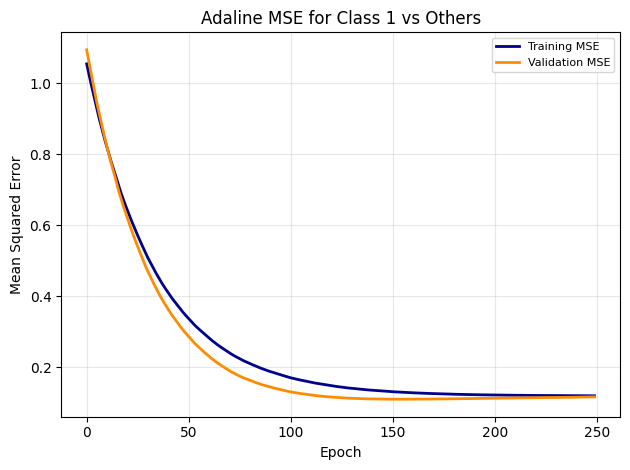


--- Adaline Results for Class 1 vs Others ---
Test Accuracy: 0.8889
Number of Epochs Trained: 250


In [11]:
# Plot MSE Curve for Class 1
plt.figure(figsize=(6.4, 4.8))
plt.plot(history_a.history['loss'], label='Training MSE', color='darkblue', lw=2)
plt.plot(history_a.history['val_loss'], label='Validation MSE', color='darkorange', lw=2)
plt.title('Adaline MSE for Class 1 vs Others', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Predict on Test Data
y_test_pred_a = (adaline_a.predict(X_test, verbose=0) >= 0.5)

# Compute Test Accuracy
test_acc_a = accuracy_score(y_test_binary_a, y_test_pred_a)

# Print Results
print("\n--- Adaline Results for Class 1 vs Others ---")
print(f"Test Accuracy: {test_acc_a:.4f}")
print(f"Number of Epochs Trained: {len(history_a.history['loss'])}")

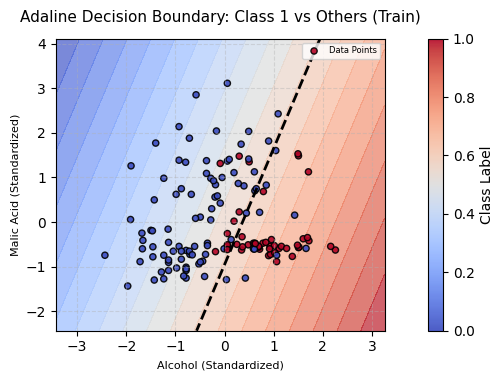

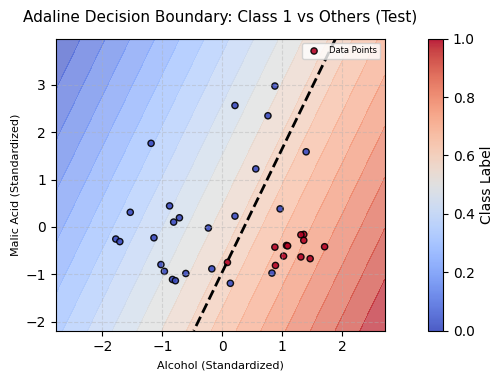

In [12]:
# Plot for Train Data
plot_decision_boundary(
    X_train, y_train_binary_a, adaline_a,
    title='Adaline Decision Boundary: Class 1 vs Others (Train)',
    feature_names=['Alcohol (Standardized)', 'Malic Acid (Standardized)']
)

# Plot for Test Data
plot_decision_boundary(
    X_test, y_test_binary_a, adaline_a,
    title='Adaline Decision Boundary: Class 1 vs Others (Test)',
    feature_names=['Alcohol (Standardized)', 'Malic Acid (Standardized)']
)

In [13]:
# Convert labels to binary classification (Class 2 vs Others)
y_train_binary_b = np.where(y_train == 2, 1, 0)  
y_test_binary_b = np.where(y_test == 2, 1, 0)

In [14]:
# Define Adaline Model
adaline_b = models.Sequential([
    layers.Dense(1, activation='linear', input_shape=(2,))
])

# Compile Model
adaline_b.compile(optimizer=optimizers.SGD(learning_rate=0.002), loss='mse', metrics=['accuracy'])

# Train Model Using TensorFlow's Built-in Validation Split (20% of Training Data)
history_b = adaline_b.fit(
    X_train, y_train_binary_b,
    epochs=250, batch_size=32,
    validation_split=0.2,  # AUTOMATIC VALIDATION SPLIT
    callbacks=callbacks.ModelCheckpoint(
        filepath='best_model_class2.keras',
        monitor='val_loss', save_best_only=True,
        verbose=0
        ),
    verbose=0
)


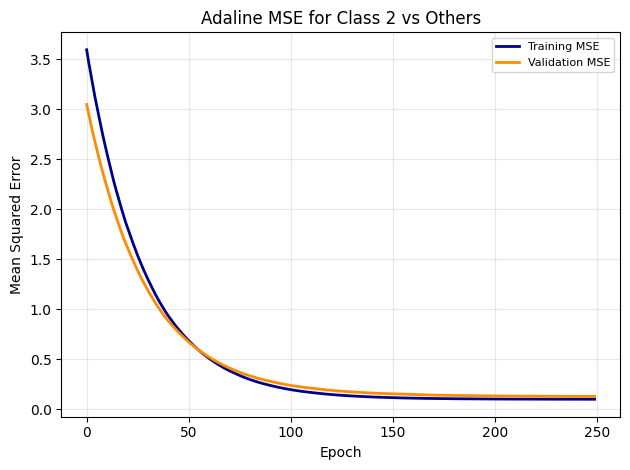


--- Adaline Results for Class 2 vs Others ---
Test Accuracy: 0.8889
Number of Epochs Trained: 250


In [15]:
# Plot MSE Curve for Class 2
plt.figure(figsize=(6.4, 4.8))
plt.plot(history_b.history['loss'], label='Training MSE', color='darkblue', lw=2)
plt.plot(history_b.history['val_loss'], label='Validation MSE', color='darkorange', lw=2)
plt.title('Adaline MSE for Class 2 vs Others', fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Mean Squared Error', fontsize=10)
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Predict on Test Data
y_test_pred_b = (adaline_b.predict(X_test, verbose=0) >= 0.5)

# Compute Test Accuracy
test_acc_b = accuracy_score(y_test_binary_b, y_test_pred_b)

# Print Results
print("\n--- Adaline Results for Class 2 vs Others ---")
print(f"Test Accuracy: {test_acc_b:.4f}")
print(f"Number of Epochs Trained: {len(history_b.history['loss'])}")

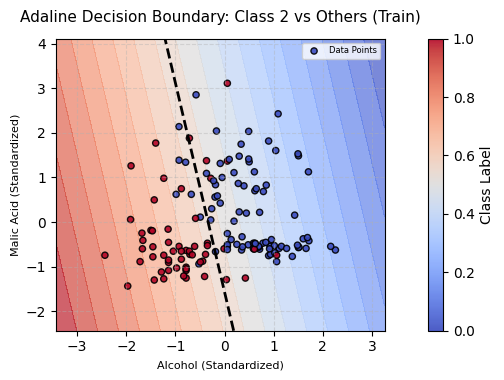

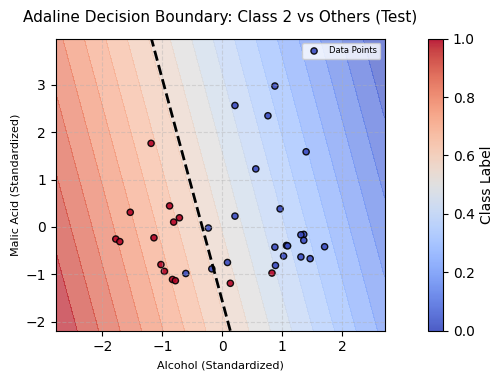

In [16]:
# Plot for Train Data
plot_decision_boundary(
    X_train, y_train_binary_b, adaline_b,
    title='Adaline Decision Boundary: Class 2 vs Others (Train)',
    feature_names=['Alcohol (Standardized)', 'Malic Acid (Standardized)']
)

# Plot for Test Data
plot_decision_boundary(
    X_test, y_test_binary_b, adaline_b,
    title='Adaline Decision Boundary: Class 2 vs Others (Test)',
    feature_names=['Alcohol (Standardized)', 'Malic Acid (Standardized)']
)

## 2.2. Answer

MR1 and MR2 are training algorithm for Madaline networks, which is constructed of multiple Adaline units. 

In MR1, each Adaline is trained independently using the perceptron learning rule: it computes the net output, compares it to the target output, and updates weights and bias only when a misclassification occurs. The network’s final output is determined by a majority vote of all units. While this approach is easier to implement, it does not consider the interactions of units, which may lead to worse overall performance.

On the other hand, MR2 evaluates the network’s overall output first and then identifies the units most responsible for the error—those whose net inputs are closest to the decision boundary—to update their weights. So MR2 only update the single Adaline unit that requires the smallest adjustment rather than all responsible units. This approach considers the effect of units interactions, bit it makes the training process more complex.

In this task I will write a general Madaline class implementing both algorithms using a feature to determine which one to use. Additionally I will train each Model, 3/5/8-Neurons, with 3 different learning rates and for both algorithms, to completely observe and compare each model and each algorithm together.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set random seed for consistent results
np.random.seed(42)

In [2]:
# Generate synthetic dataset with two classes
X, y = make_gaussian_quantiles(
    n_samples=300, n_features=2, n_classes=2, random_state=42 
)

# Split dataset into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Further split training + validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.25, random_state=42
)

# Convert labels from {0, 1} to {-1, 1} for Madaline
y_train = np.where(y_train == 0, -1, 1)
y_val = np.where(y_val == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)

In [3]:
class Madaline:
    def __init__(self, num_units, learning_rate, patience=0, algorithm='MR1'):
        """Initialize the Madaline model with configuration parameters."""
        self.num_units = num_units              # Store the number of Adaline units
        self.learning_rate = learning_rate      # Store the learning rate for weight updates
        self.patience = patience                # Store patience for early stopping (0 == no stopping)
        self.algorithm = algorithm              # Store the training algorithm
        self.weights = None                     # Placeholder for weights, initialized later
        self.biases = None                      # Placeholder for biases, initialized later

    def _initialize_weights(self, n_features):
        """Set up initial weights and biases for all units."""
        self.weights = np.random.randn(self.num_units, n_features) * 0.01       # Initialize weights to small values
        self.biases = np.zeros(self.num_units)                                  # Initialize biases to zero 

    def fit(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        """Train the model with mini-batch gradient descent and early stopping."""
        if self.weights is None:                            # Check if model is not pre-trained
            self._initialize_weights(X_train.shape[1])      # Initialize weights 
    
        # Initialize variables for tracking training progress
        best_val_acc = 0  # Best validation accuracy so far
        patience_counter = 0  # Counter for early stopping
        train_acc_history = []  # List to store training accuracy per epoch
        val_acc_history = []  # List to store validation accuracy per epoch
    
        # Iterate over the specified number of epochs
        for epoch in range(epochs):
            self._train_epoch(X_train, y_train, batch_size)             # Train the model for one epoch
            train_acc = self._compute_accuracy(X_train, y_train)        # Calculate training accuracy 
            val_acc = self._compute_accuracy(X_val, y_val)              # Calculate validation accuracy 
            # Append accuracies to history lists
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            
            # Check if validation accuracy improved
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Check if early stopping is needed
            if self.patience > 0 and patience_counter >= self.patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Return accuracy histories for plotting
        return train_acc_history, val_acc_history

    def _train_epoch(self, X, y, batch_size):
        """Train the model for a single epoch using mini-batches."""
        # Generate shuffled indices for random batch selection
        indices = np.random.permutation(len(X))
        # Apply shuffling to input data and labels
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        # Process the data in batches
        self._process_batches(X_shuffled, y_shuffled, batch_size)

    def _process_batches(self, X_shuffled, y_shuffled, batch_size):
        """Process shuffled data in mini-batches and update weights."""
        # Iterate over the data in steps of batch_size
        for start in range(0, len(X_shuffled), batch_size):
            end = min(start + batch_size, len(X_shuffled))      # Calculate the end index for the current batch
            X_batch = X_shuffled[start:end]                     # Extract the current batch of inputs
            y_batch = y_shuffled[start:end]                     # Extract the current batch of labels
            # Update model weights based on the chosen algorithm    
            self._update_weights(X_batch, y_batch)

    def _update_weights(self, X_batch, y_batch):
        """Apply weight updates based on the specified algorithm."""
        # Check which algorithm to use and call the appropriate method
        if self.algorithm == 'MR1':
            self._update_mr1(X_batch, y_batch)
        elif self.algorithm == 'MR2':
            self._update_mr2(X_batch, y_batch)
        else:
            # Raise an error if an invalid algorithm is specified
            raise ValueError("Algorithm must be 'MR1' or 'MR2'")

    def _compute_accuracy(self, X, y):
        """Calculate prediction accuracy for a given dataset."""
        y_pred = self.predict(X)            # Get predictions for input 
        return accuracy_score(y, y_pred)    # Compute accuracy

    def _check_early_stopping(self, val_acc, best_val_acc, patience_counter):
        """Determine if training should stop based on validation accuracy."""
        # Update best validation accuracy and reset counter if improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc  # This only updates the local variable
            patience_counter = 0
        else:
            patience_counter += 1   # Increment counter if no improvement
        # Return True if patience limit is reached and early stopping is enabled
        return self.patience > 0 and patience_counter >= self.patience
    
    def _compute_net_inputs(self, X):
        """Calculate net inputs (weighted sum + bias) for all units."""
        # Perform matrix multiplication and add biases
        return X @ self.weights.T + self.biases

    def _compute_unit_outputs(self, net_inputs):
        """Apply sign activation function to net inputs."""
        # Handle the case where net_input is exactly 0
        return np.where(net_inputs == 0, 1, np.sign(net_inputs))

    def _update_mr1(self, X_batch, y_batch):
        """Update weights using MR1 algorithm (independent unit training)."""
        # Iterate over each unit in the network
        for unit in range(self.num_units):
            net_input = X_batch @ self.weights[unit] + self.biases[unit]        # Compute net input for the current unit
            misclassified = y_batch * net_input <= 0                            # Identify samples where the unit misclassifies
            # Check if there are any misclassified samples
            if np.any(misclassified):
                # Calculate weight update for misclassified samples
                delta_w = self.learning_rate * np.sum(
                    y_batch[misclassified, np.newaxis] * X_batch[misclassified],
                    axis=0
                )
                # Calculate bias update for misclassified samples
                delta_b = self.learning_rate * np.sum(y_batch[misclassified])

                self.weights[unit] += delta_w       # Update weights
                self.biases[unit] += delta_b        # Update biases

    def _update_mr2(self, X_batch, y_batch):
        """Update weights using MR2 algorithm (closest-to-boundary updates)."""
        net_inputs = self._compute_net_inputs(X_batch)              # Compute net inputs for all units
        unit_outputs = self._compute_unit_outputs(net_inputs)       # Get unit outputs based on net inputs
        sum_outputs = np.sum(unit_outputs, axis=1)                  # Sum outputs across units for majority vote
        predictions = np.where(sum_outputs > 0, 1, -1)              # Predict labels based on majority vote
        misclassified = y_batch * predictions < 0                   # Identify misclassified samples

        # Process updates if there are misclassifications
        if np.any(misclassified):
            abs_net_inputs = np.abs(net_inputs[misclassified])      # Get absolute net inputs for misclassified samples
            selected_units = np.argmin(abs_net_inputs, axis=1)      # Find the unit closest to the decision boundary for each sample
            misclassified_indices = np.where(misclassified)[0]      # Get indices of misclassified samples

            # Update each unit separately
            for unit in range(self.num_units):
                # Check if this unit was selected for any misclassified samples
                unit_selected = (selected_units == unit)
                if np.any(unit_selected):
                    samples_indices = misclassified_indices[unit_selected]  # Get indices of samples where this unit was closest
                    # Compute weight update for these samples
                    delta_w = self.learning_rate * np.sum(
                        y_batch[samples_indices, np.newaxis] * X_batch[samples_indices],
                        axis=0
                    )
                    # Compute bias update for these samples
                    delta_b = self.learning_rate * np.sum(y_batch[samples_indices])

                    self.weights[unit] += delta_w       # Update weights
                    self.biases[unit] += delta_b        # Update biases

    def predict(self, X):
        """Predict labels using majority vote across unit outputs."""
        net_inputs = self._compute_net_inputs(X)                    # Compute net inputs for the input data
        unit_outputs = self._compute_unit_outputs(net_inputs)       # Get outputs for each unit
        sum_outputs = np.sum(unit_outputs, axis=1)                  # Sum outputs across units for majority vote
        return np.where(sum_outputs > 0, 1, -1)                     # Return predictions based on majority vote

In [4]:
def plot_decision_boundary(ax, X, y, model, test_acc, title):
    """Plot decision boundary and training data points on a specified axis."""
    # Define padding for grid boundaries
    padding = 1
    # Create a meshgrid for contour plotting
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min() - padding, X[:, 0].max() + padding, 200),
        np.linspace(X[:, 1].min() - padding, X[:, 1].max() + padding, 200)
    )
    # Combine grid points into a single array for prediction
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict over the grid and reshape for contour
    pred = model.predict(grid).reshape(xx.shape)

    # Plot filled contour for decision regions
    ax.contourf(xx, yy, pred, levels=[-1, 0, 1], alpha=0.7, cmap='coolwarm')
    ax.contour(xx, yy, pred, levels=[0], colors='black', linewidths=2, linestyles='--')     # Add a distinct boundary line at threshold 0
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', s=30)                # Scatter training data points
    
    # Set subplot title with test accuracy
    ax.set_title(f"{title}\nTest Acc: {test_acc:.4f}")
    # Label axes
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.grid(True, linestyle='--', alpha=0.4)

def plot_accuracy_curves(ax, train_acc_history, val_acc_history, test_acc, title):
    """Plot training and validation accuracy curves on a specified axis."""
    # Generate epoch numbers for x-axis
    epochs = range(1, len(train_acc_history) + 1)
    ax.plot(epochs, train_acc_history, 'b-', label='Train Acc')     # Plot training accuracy curve
    ax.plot(epochs, val_acc_history, 'r-', label='Val Acc')         # Plot validation accuracy curve
    
    # Ensure y-axis starts from a sensible value based on data
    min_acc = min(min(train_acc_history), min(val_acc_history), test_acc, 0.5/0.8) * 0.8
    max_acc = max(max(train_acc_history), max(val_acc_history), test_acc) * 1.2
    ax.set_ylim([max(0, min_acc), min(1, max_acc)])

    # Set subplot title
    ax.set_title(f"{title}\nTest Acc: {test_acc:.4f}")
    # Label axes
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)

In [5]:
# Define hyperparameters for experimentation
units_list = [3, 5, 8]          # Unit sizes 
lr_list = [0.01, 0.05, 0.1]     # Learning rates 
epochs = 250                    # Maximum epochs
batch_size = 32                 # Batch size
patience = 100                  # Early stopping
algorithms = ['MR1', 'MR2']     # Algorithm to use ('MR1' or 'MR2')

# Initialize dictionary to store models and their results
models = {}

In [6]:
# Loop for generating models based on configurations
for algorithm in algorithms:
    for units in units_list:
        for lr in lr_list:

            model_name = f"{algorithm.lower()}_units{units}_lr{lr}"     # Create a unique name for this model 

            # Instantiate a new Madaline model
            model = Madaline(
                num_units=units,
                learning_rate=lr,
                patience=patience,
                algorithm=algorithm
            )

            # Store the untrained model with placeholders for results
            models[model_name] = {
                'model': model,
                'train_acc_history': None,
                'val_acc_history': None,
                'test_acc': None
            }

In [7]:
# Train each generated model
for model_name in models.keys():
    print(f"\nTraining {model_name}")
    
    # Retrieve the model instance from the dictionary
    model_data = models[model_name]
    model = model_data['model']
    
    # Train the model and get accuracy histories
    train_acc_history, val_acc_history = model.fit(
        X_train, y_train,
        X_val, y_val,
        epochs, batch_size
    )
    
    y_test_pred = model.predict(X_test)                     # Test predictions 
    test_acc = accuracy_score(y_test, y_test_pred)          # Test accuracy
    
    # Update the dictionary with training results
    models[model_name]['train_acc_history'] = train_acc_history
    models[model_name]['val_acc_history'] = val_acc_history
    models[model_name]['test_acc'] = test_acc


Training mr1_units3_lr0.01
Early stopping at epoch 106

Training mr1_units3_lr0.05
Early stopping at epoch 179

Training mr1_units3_lr0.1
Early stopping at epoch 180

Training mr1_units5_lr0.01
Early stopping at epoch 102

Training mr1_units5_lr0.05
Early stopping at epoch 114

Training mr1_units5_lr0.1
Early stopping at epoch 104

Training mr1_units8_lr0.01
Early stopping at epoch 203

Training mr1_units8_lr0.05
Early stopping at epoch 105

Training mr1_units8_lr0.1
Early stopping at epoch 196

Training mr2_units3_lr0.01
Early stopping at epoch 194

Training mr2_units3_lr0.05
Early stopping at epoch 155

Training mr2_units3_lr0.1
Early stopping at epoch 127

Training mr2_units5_lr0.01
Early stopping at epoch 104

Training mr2_units5_lr0.05
Early stopping at epoch 144

Training mr2_units5_lr0.1
Early stopping at epoch 180

Training mr2_units8_lr0.01
Early stopping at epoch 103

Training mr2_units8_lr0.05
Early stopping at epoch 132

Training mr2_units8_lr0.1
Early stopping at epoch 11

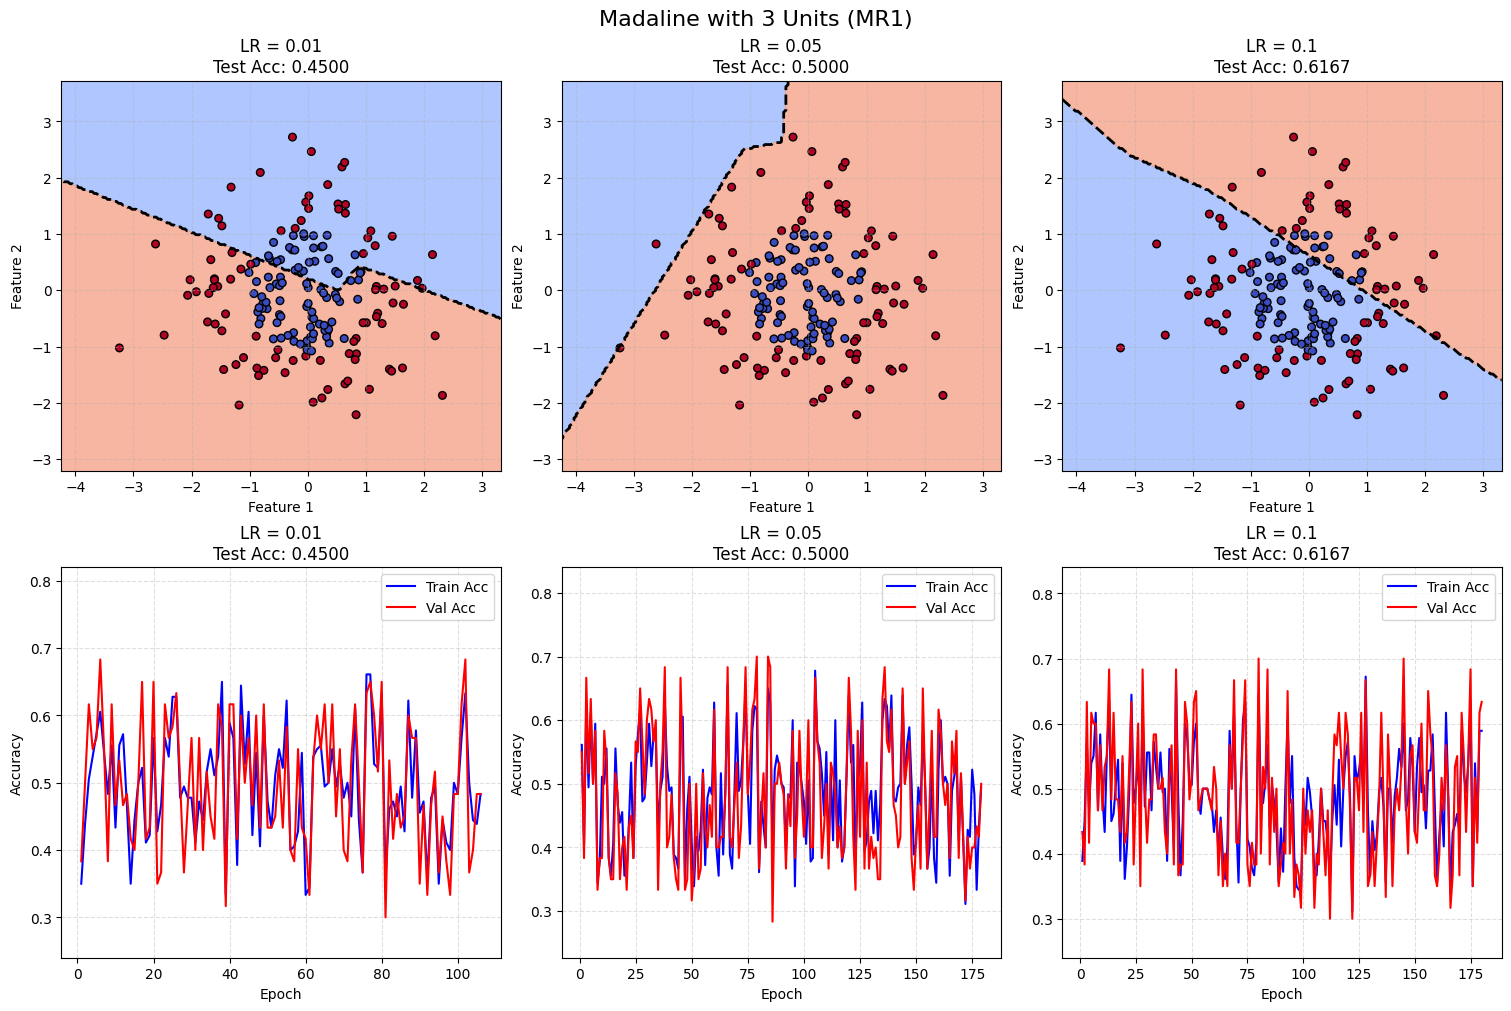

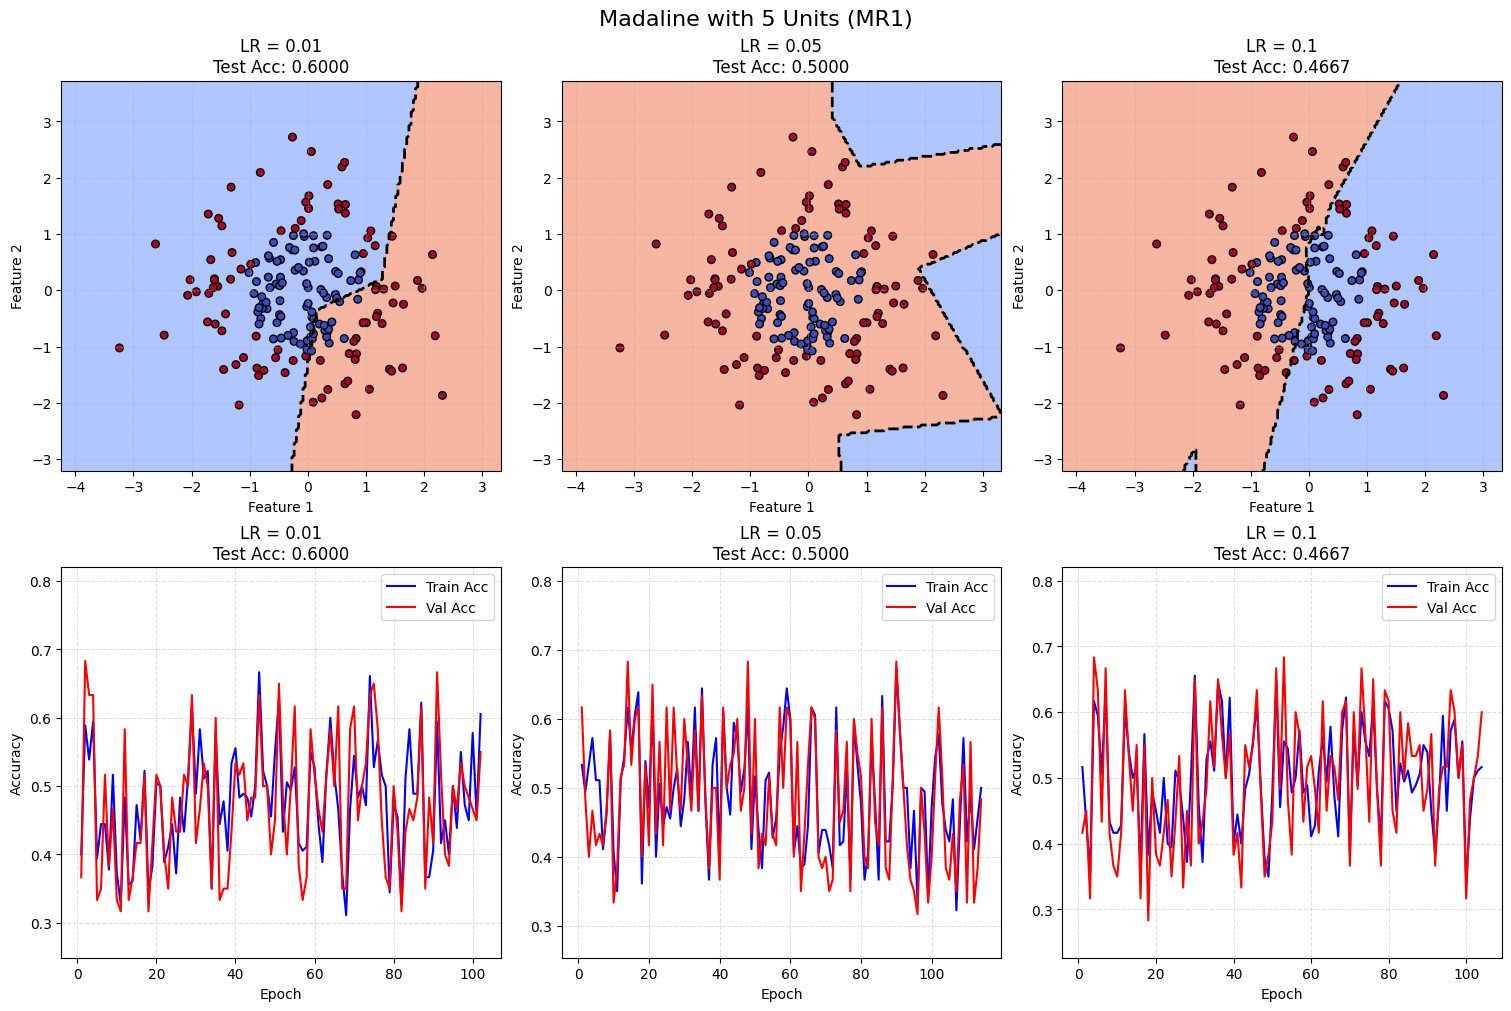

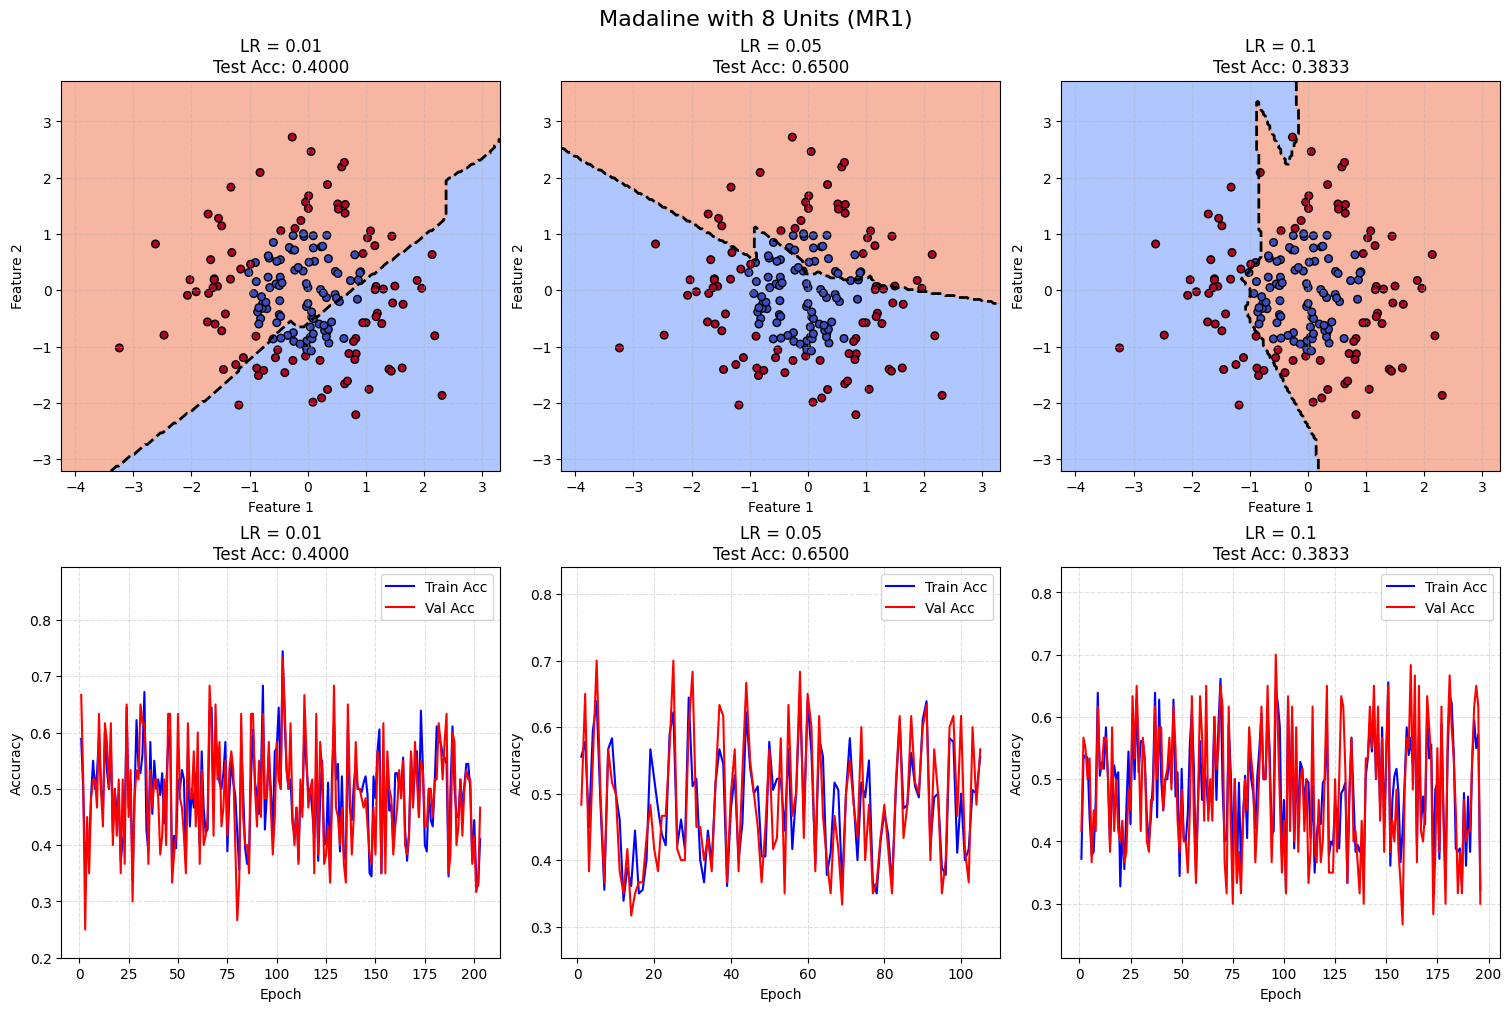

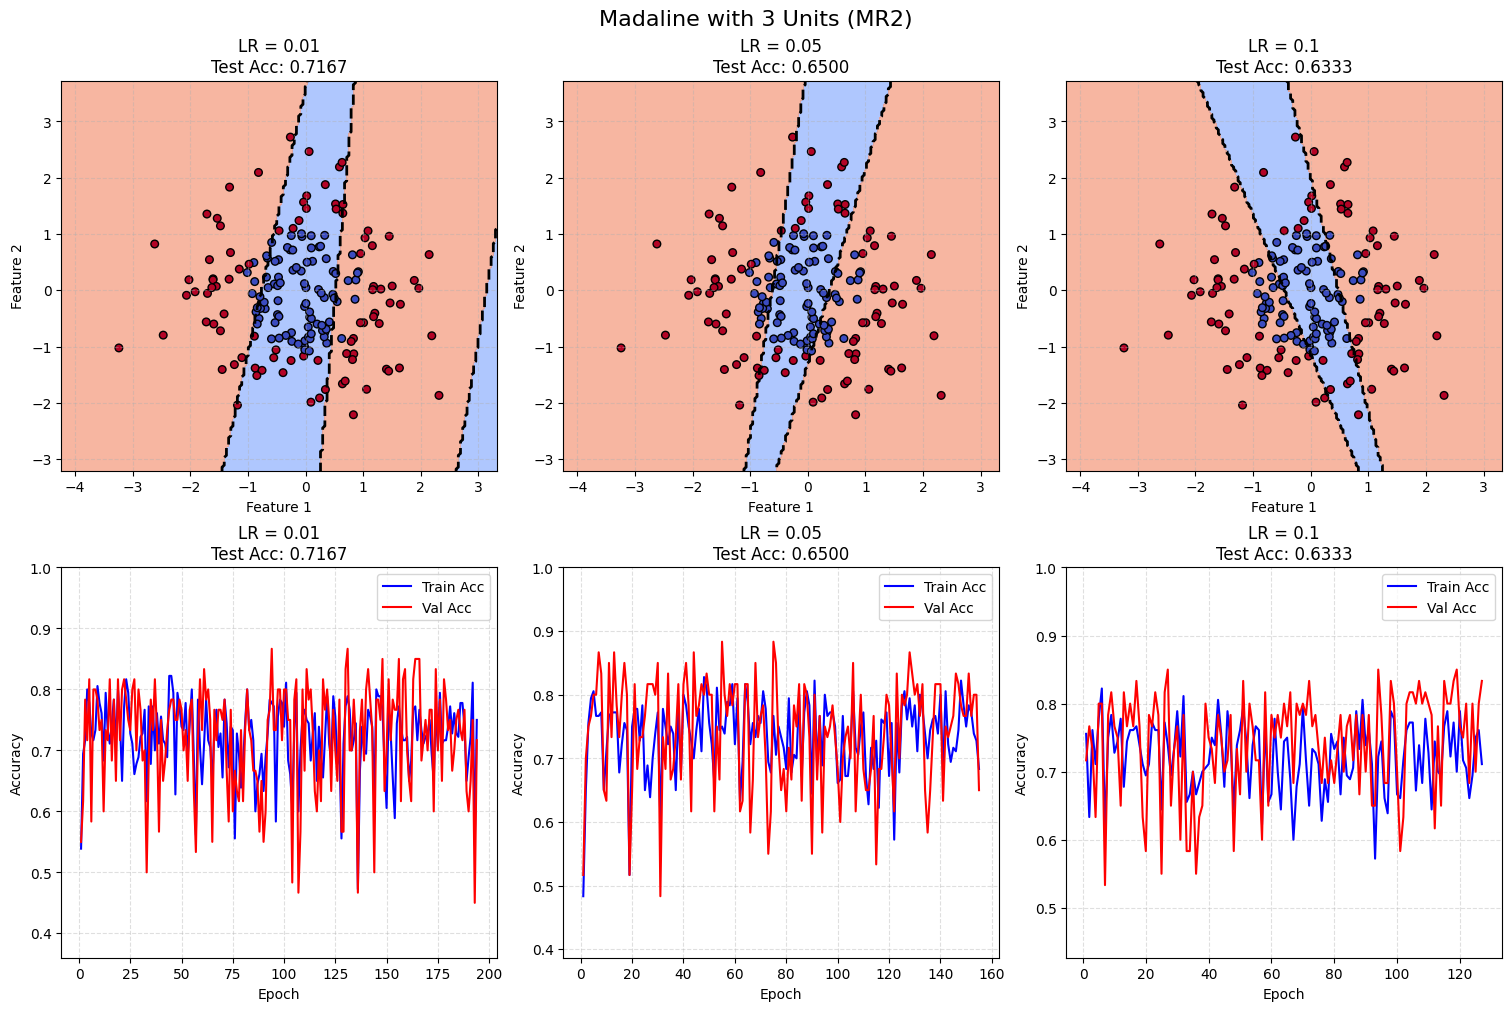

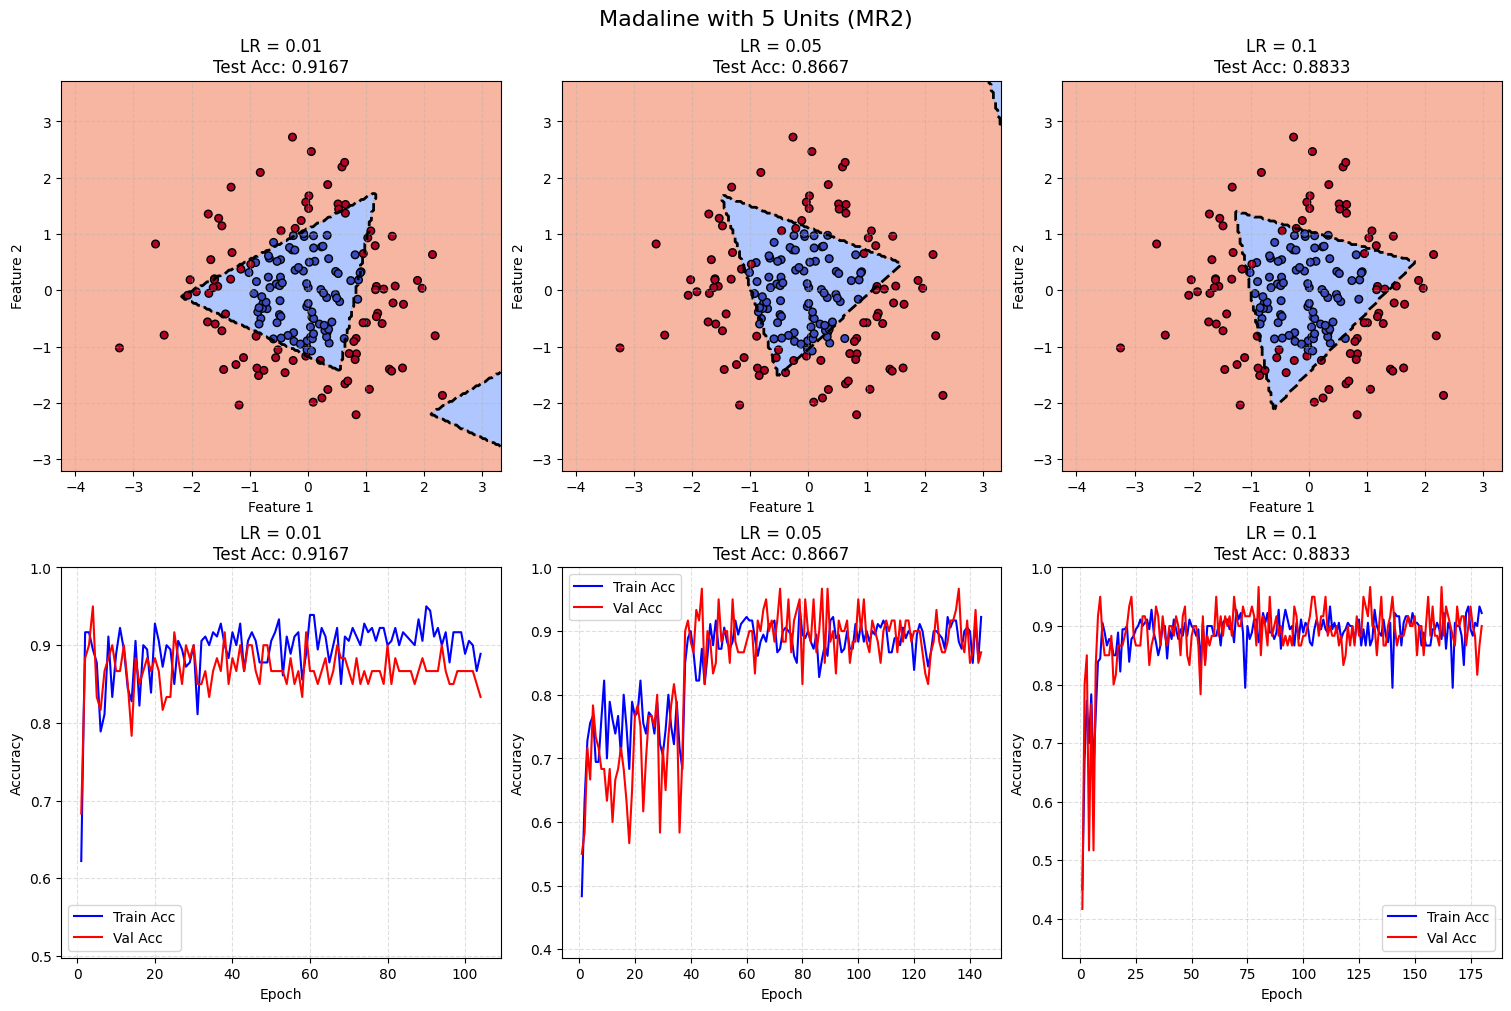

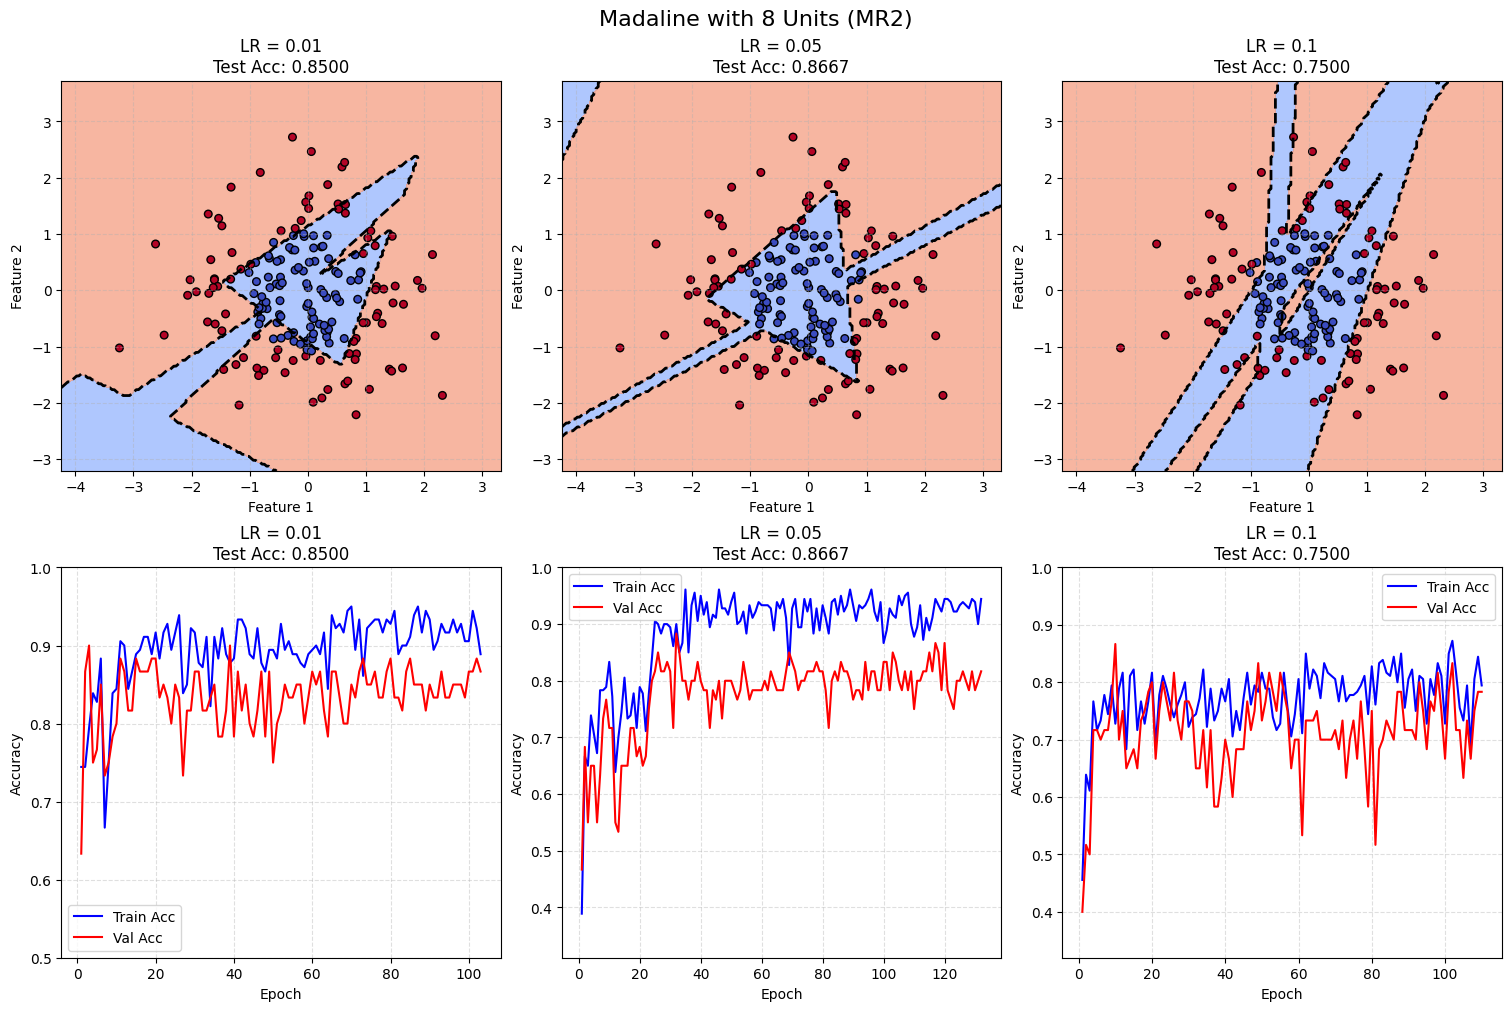

In [8]:
# Loop over algorithms and units
for algorithm in algorithms:
    for units in units_list:
        # Create a figure with two rows of subplots
        fig, axes = plt.subplots(
            2, len(lr_list),            # 2 rows: decision boundary, accuracy curves
            figsize=(15 , 10),          # Figure size for clear visualization
            constrained_layout=True     # Adjust layout to avoid overlap
        )
        # Set a super title for the entire figure
        fig.suptitle(f'Madaline with {units} Units ({algorithm})', fontsize=16)

        # Plot results for each learning rate
        for i, lr in enumerate(lr_list):
            model_name = f"{algorithm.lower()}_units{units}_lr{lr}"      # Construct the model name 
            model_data = models[model_name]                              # Retrieve the model data

            # Plot decision boundary in the top row
            plot_decision_boundary(
                    axes[0, i], X_train, y_train,
                    model_data['model'],model_data['test_acc'],
                    f'LR = {lr}' 
            )

            # Plot accuracy curves in the bottom row
            plot_accuracy_curves(
                axes[1, i], model_data['train_acc_history'],
                model_data['val_acc_history'], model_data['test_acc'],
                f'LR = {lr}' 
            )

        # Display the figure after all subplots are populated
        plt.show()

### Results Analysis:

The MR2 algorithm consistently outperforms MR1 when training Madaline networks, achieving much higher test accuracies (75%–91.67% vs. 40%–65%). The reason behind MR2’s performance is its update strategy—it only adjusts the unit closest to the decision boundary when a sample is misclassified, leading to faster learning and more accurate result. 

The number of units in the network has a significant effect. With just 3 units, the network’s learning ability is unable for finding pattern, leading to moderate accuracy (63%–71% with MR2). Increasing to 5 units we reach the optimal model with the best accuracy (up to 91.67% with MR2 at LR=0.01). However, at 8 units, the model overfits with MR2.

## Question 3: MLP


You are provided with a dataset containing information on house prices. Your task is to build and evaluate machine learning models to predict house prices using a Multi-Layer Perceptron (MLP).

### 3.1. Display Column Count

* Read the file "Question3.csv" into your programming environment.
* Calculate and display the number of missing values (NaNs) in each column of the dataset.

### 3.2. Correlation Matrix

* Create a correlation matrix that visualizes the correlation coefficients between all pairs of features (columns) in the dataset.
* Analyze the correlation matrix and identify which features have the strongest positive and negative correlations with the `price` feature.

### 3.3. Draw Plots

* Generate two plots:
    * A distribution plot (histogram) showing the distribution of the `price` variable. This helps visualize the range, central tendency, and spread of house prices.
    * A scatter plot visualizing the relationship between `price` and the feature that has the highest correlation with `price` (identified in step 2).

### 3.4. Data Preprocessing

* **Date Transformation:**
    * Extract the `month` and `year` components from the `date` column.
    * Create two new columns named `month` and `year` to store these extracted components.
    * Remove the original `date` column from the dataset.
* **Data Splitting:**
    * Divide the dataset into training and validation sets.
    * Allocate 75% of the data for training the model and the remaining 25% for validating its performance.
* **Data Scaling:**
    * Use the `MinMaxScaler` to scale the numerical features in the training and validation sets.
    * Apply the scaler separately to the training and validation sets to prevent data leakage, where information from the validation set influences the scaling of the training set.

### 3.5. Model Implementation

* Construct two different MLP models:
    * **Model 1:** An MLP with a single hidden layer.
    * **Model 2:** An MLP with two hidden layers.
* You are free to choose the number of neurons in each hidden layer based on your understanding of the dataset and MLP architecture.

### 3.6. Model Training

* **Optimizer and Loss Function:**
    * Select an appropriate optimizer to update the model's weights during training.
    * Choose a suitable loss function to measure the difference between predicted and actual house prices.
* **Training and Evaluation:**
    * Train both MLP models (Model 1 and Model 2) using the training data.
    * Determine an appropriate number of training epochs based on the model's learning progress and performance on the validation set.
    * During training, monitor and display the training loss and validation loss curves. These curves help visualize how the model's error changes over epochs and whether it is overfitting or underfitting.

### 3.7. Analysis
Compare the final results and the appropriate number of epochs for both models. Analyze the reasons for the differences. (14 points) Randomly select 5 data points from the validation dataset and predict the price using the better model. (8 points)

## Preliminary Setup

In [11]:
# Import necessary libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.utils import plot_model

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages
warnings.filterwarnings('ignore')         # Suppress Python warnings
tf.get_logger().setLevel('ERROR')         # Further reduce TensorFlow logging

# Set path for model visualization for Graphviz (important for plot_model to work)
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

## 3.1. Answer

In [12]:
# Load the dataset
housing = pd.read_csv("Question3.csv")

# Convert integer and float columns to smaller dtypes for efficiency
housing[housing.select_dtypes("int64").columns] = housing.select_dtypes("int64").astype("int16")
housing[housing.select_dtypes("float64").columns] = housing.select_dtypes("float64").astype("float32")

# Display basic dataset information
print(f"Dataset shape: {housing.shape}")
print("First 10 rows of the dataset:")
display(housing.head(10))


Dataset shape: (21613, 21)
First 10 rows of the dataset:


id             date      price  bedrooms  bathrooms  sqft_living  \
0  32296  20141013T000000   221900.0         3       1.00         1180   
1  26336  20141209T000000   538000.0         3       2.25         2570   
2  -8080  20150225T000000   180000.0         2       1.00          770   
3 -21397  20141209T000000   604000.0         4       3.00         1960   
4 -14082  20150218T000000   510000.0         3       2.00         1680   
5  16614  20140512T000000  1225000.0         4       4.50         5420   
6  -2308  20140627T000000   257500.0         3       2.25         1715   
7 -22770  20150115T000000   291850.0         3       1.50         1060   
8  -8258  20150415T000000   229500.0         3       1.00         1780   
9  14336  20150312T000000   323000.0         3       2.50         1890   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   
5    -29142     1.0           0     0  ...     11        3890           1530   
6      6819     2.0           0     0  ...      7        1715              0   
7      9711     1.0           0     0  ...      7        1060              0   
8      7470     1.0           0     0  ...      7        1050            730   
9      6560     2.0           0     0  ...      7        1890              0   

   yr_built  yr_renovated  zipcode        lat        long  sqft_living15  \
0      1955             0    32642  47.511200 -122.257004           1340   
1      1951          1991    32589  47.721001 -122.319000           1690   
2      1933             0    32492  47.737900 -122.233002           2720   
3      1965             0    32600  47.520802 -122.392998           1360   
4      1987             0    32538  47.616798 -122.044998           1800   
5      2001             0    32517  47.656101 -122.004997           4760   
6      1995             0    32467  47.309700 -122.327003           2238   
7      1963             0    32662  47.409500 -122.315002           1650   
8      1960             0    32610  47.512299 -122.336998           1780   
9      2003             0    32502  47.368401 -122.030998           2390   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  
5      -29142  
6        6819  
7        9711  
8        8113  
9        7570  

[10 rows x 21 columns]

In [13]:
# Display column count and check for missing values
print(f"Number of Columns: {len(housing.columns)}")
print("Missing Values per Column:")
print(housing.isna().sum())

# Display basic statistics
housing.describe()

Number of Columns: 21
Missing Values per Column:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


id         price      bedrooms     bathrooms   sqft_living  \
count  21613.000000  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean     229.545875  5.400881e+05      3.370842      2.114757   2079.899736   
std    18758.399462  3.671272e+05      0.930062      0.770163    918.440897   
min   -32768.000000  7.500000e+04      0.000000      0.000000    290.000000   
25%   -15770.000000  3.219500e+05      3.000000      1.750000   1427.000000   
50%      315.000000  4.500000e+05      3.000000      2.250000   1910.000000   
75%    16692.000000  6.450000e+05      4.000000      2.500000   2550.000000   
max    32766.000000  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  21613.000000  21613.000000  21613.000000  21613.000000  21613.000000   
mean    6674.282793      1.494309      0.007542      0.234303      3.409430   
std     8555.327904      0.539989      0.086517      0.766318      0.650743   
min   -32764.000000      1.000000      0.000000      0.000000      1.000000   
25%     4558.000000      1.000000      0.000000      0.000000      3.000000   
50%     7200.000000      1.500000      0.000000      0.000000      3.000000   
75%     9696.000000      2.000000      0.000000      0.000000      4.000000   
max    32757.000000      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15    sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000  21613.000000  
mean   32541.939805     47.560051   -122.213898    1986.552492   6558.409476  
std       53.505026      0.138564      0.140828     685.391304   8141.472837  
min    32465.000000     47.155899   -122.518997     399.000000 -32737.000000  
25%    32497.000000     47.471001   -122.328003    1490.000000   4798.000000  
50%    32529.000000     47.571800   -122.230003    1840.000000   7254.000000  
75%    32582.000000     47.678001   -122.125000    2360.000000   9504.000000  
max    32663.000000     47.777599   -121.315002    6210.000000  32700.000000

## 3.2. Answer

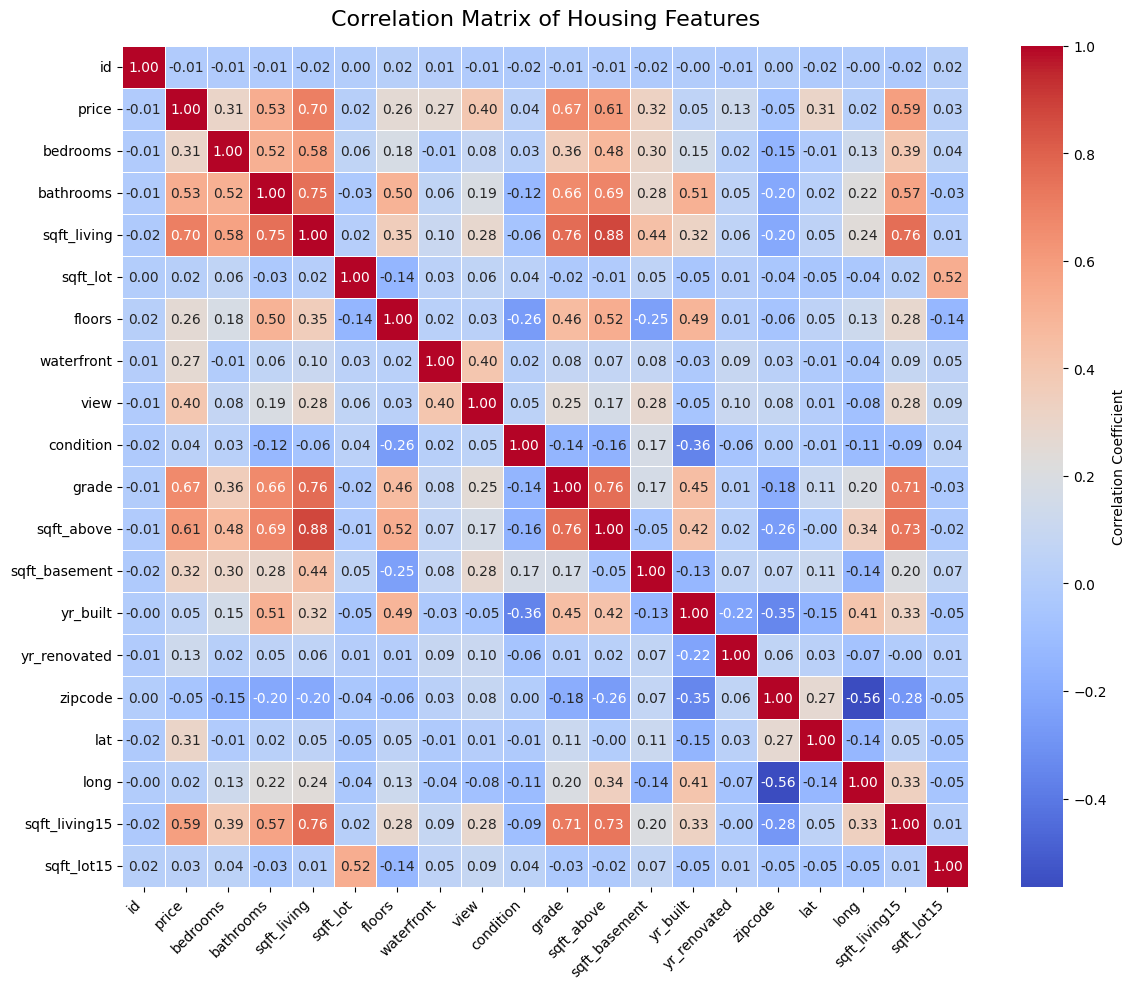


Correlations with price:
  sqft_living: 0.7020
  grade: 0.6674
  sqft_above: 0.6056
  sqft_living15: 0.5854
  bathrooms: 0.5251
  view: 0.3973
  sqft_basement: 0.3238
  bedrooms: 0.3083
  lat: 0.3070
  waterfront: 0.2664
  floors: 0.2568
  yr_renovated: 0.1264
  yr_built: 0.0540
  condition: 0.0364
  sqft_lot15: 0.0331
  long: 0.0216
  sqft_lot: 0.0197
  id: -0.0109
  zipcode: -0.0532

Strongest Positive Correlation: sqft_living (0.7020)
Strongest Negative Correlation: zipcode (-0.0532)


In [14]:
# Select numeric columns to avoid conversion issues
numeric_housing = housing.select_dtypes(include=[np.number])

# Create correlation matrix for numeric features
corr_matrix = numeric_housing.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Housing Features', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Analyze correlations with the target variable ('price')
target_col = 'price'
correlations = corr_matrix[target_col].drop(target_col)
strongest_positive = correlations.idxmax()
strongest_negative = correlations.idxmin()

print(f"\nCorrelations with {target_col}:")
for feature, corr in correlations.sort_values(ascending=False).items():
    print(f"  {feature}: {corr:.4f}")

print(f"\nStrongest Positive Correlation: {strongest_positive} ({correlations[strongest_positive]:.4f})")
print(f"Strongest Negative Correlation: {strongest_negative} ({correlations[strongest_negative]:.4f})")


## 3.3. Answer

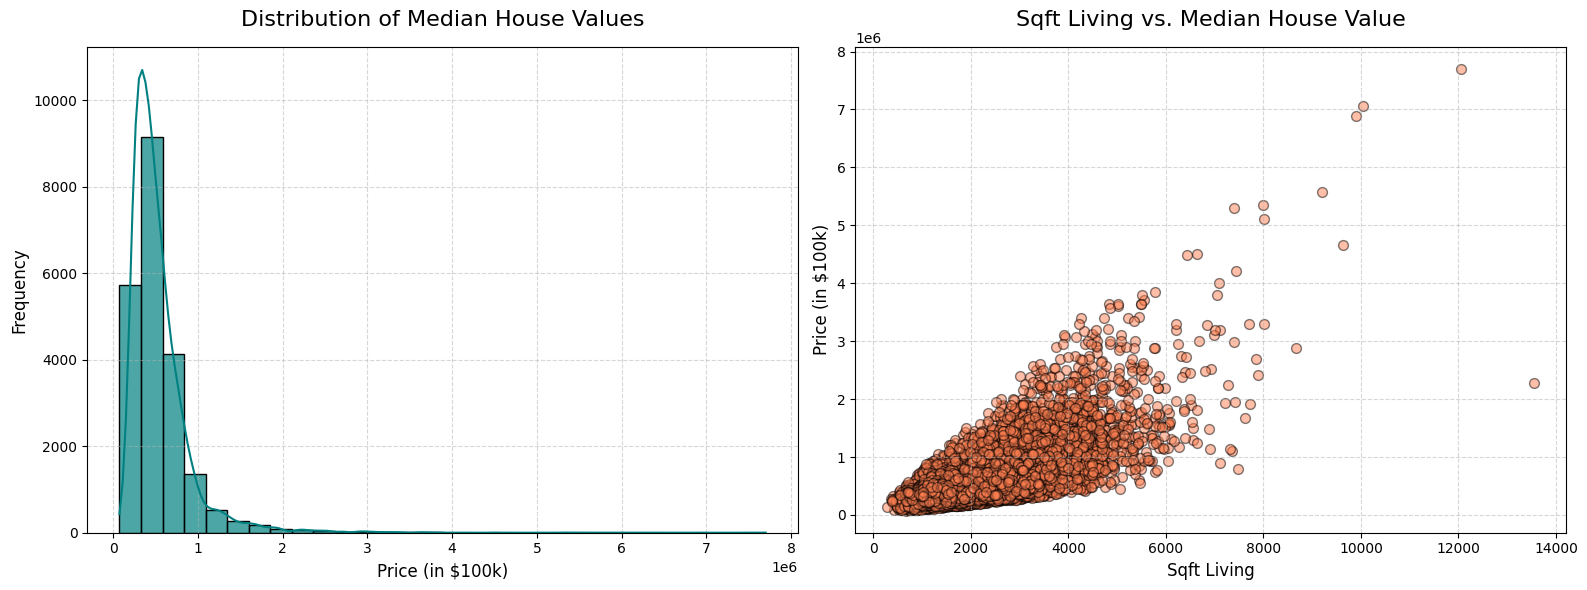

Feature plotted: Sqft Living


In [15]:
# Create a figure with two subplots: one for the distribution and one for the scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram for 'price'
sns.histplot(housing['price'], bins=30, color='teal', edgecolor='black', alpha=0.7, kde=True, ax=ax1)
ax1.set_title('Distribution of Median House Values', fontsize=16, pad=15)
ax1.set_xlabel('Price (in $100k)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# Identify the feature with the highest absolute correlation to 'price'
strongest_absolute = numeric_housing.corr()['price'].abs().drop('price').idxmax()

# Scatter Plot: Price vs. Feature with Highest Correlation
ax2.scatter(housing[strongest_absolute], housing['price'], alpha=0.5, color='coral', edgecolor='k', s=50)
ax2.set_title(f'{strongest_absolute.replace("_", " ").title()} vs. Median House Value', fontsize=16, pad=15)
ax2.set_xlabel(f'{strongest_absolute.replace("_", " ").title()}', fontsize=12)
ax2.set_ylabel('Price (in $100k)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Feature plotted: {strongest_absolute.replace('_', ' ').title()}")

## 3.4. Answer

In [16]:
# Prepare features and target variable
X = numeric_housing.drop('price', axis=1)
y = numeric_housing['price']

# Train-validation split (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features using MinMaxScaler (fit on training data and transform both sets)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## 3.5. Answer

Model 1 Architecture:


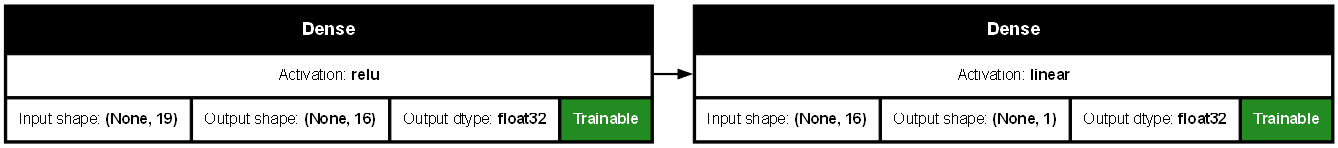


Model 2 Architecture:


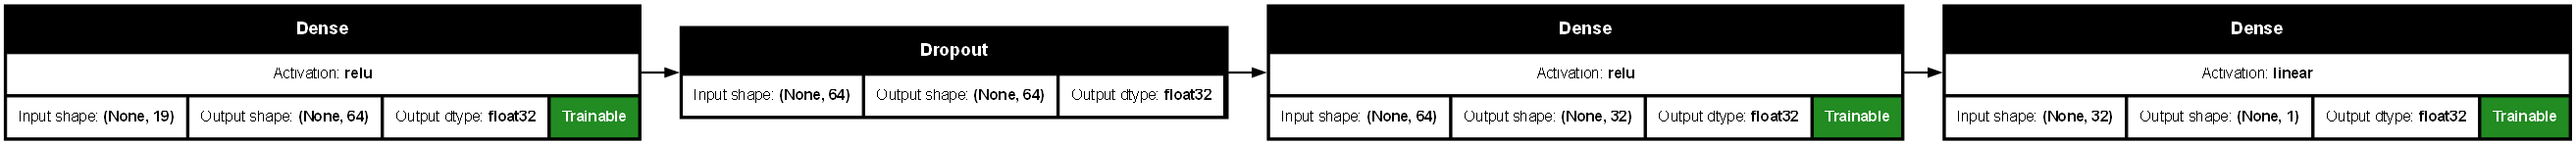

In [17]:
# Model 1: MLP with one hidden layer
model_1 = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(1)  # Output layer for regression
])

# Model 2: MLP with two hidden layers
model_2 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Display model summaries using plot_model
print("Model 1 Architecture:")
display(plot_model(model_1, show_shapes=True, show_dtype=True, rankdir="LR", 
                   show_layer_activations=True, show_trainable=True, dpi=80))
print("\nModel 2 Architecture:")
display(plot_model(model_2, show_shapes=True, show_dtype=True, rankdir="LR", 
                   show_layer_activations=True, show_trainable=True, dpi=80))

## 3.6. Answer

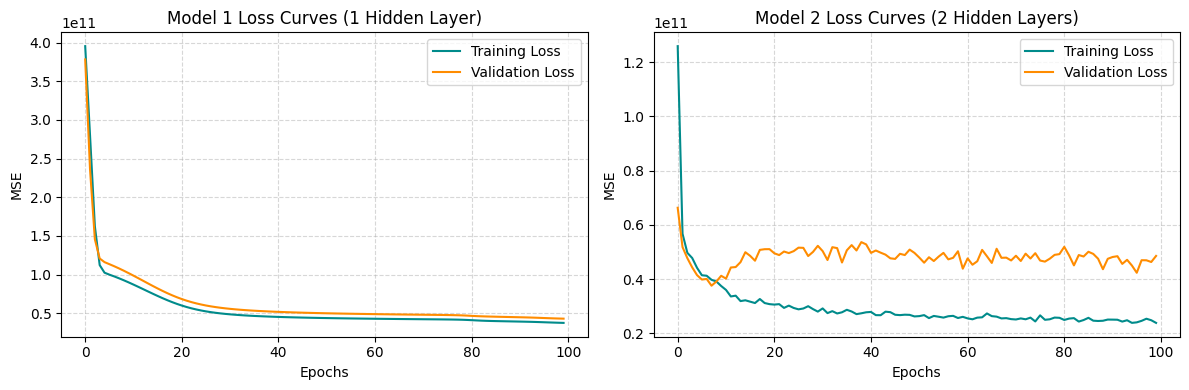

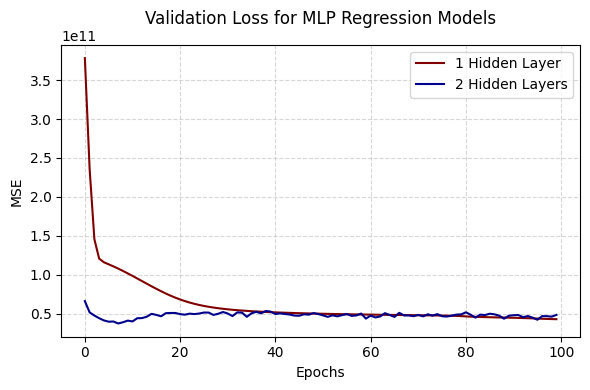

=== Test Performance Metrics ===
Model 1 (1 Hidden Layer) - Test Loss (MSE): 43040305152.0000, Test MAE: 121619.1719
Model 2 (2 Hidden Layers) - Test Loss (MSE): 48530296832.0000, Test MAE: 148979.8906


In [18]:
# Dictionary to store training histories for both models
histories = {}

# Compile models with Adam optimizer, MSE loss, and include 'mae' as a metric
for model, num_layers in zip([model_1, model_2], [1, 2]):
    model.compile(optimizer=optimizers.Adam(learning_rate=0.05), loss='mse', metrics=['mae'])
    histories[f'history_{num_layers}'] = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        validation_data=(X_val_scaled, y_val),
        verbose=0 
    )

# Unpack histories for easier access
history_1 = histories['history_1']
history_2 = histories['history_2']

# Plot training and validation loss curves separately for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Model 1 (1 Hidden Layer) loss curves
axes[0].plot(history_1.history['loss'], label='Training Loss', color='darkcyan')
axes[0].plot(history_1.history['val_loss'], label='Validation Loss', color='darkorange')
axes[0].set_title('Model 1 Loss Curves (1 Hidden Layer)', fontsize=12)
axes[0].set_xlabel('Epochs', fontsize=10)
axes[0].set_ylabel('MSE', fontsize=10)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Model 2 (2 Hidden Layers) loss curves
axes[1].plot(history_2.history['loss'], label='Training Loss', color='darkcyan')
axes[1].plot(history_2.history['val_loss'], label='Validation Loss', color='darkorange')
axes[1].set_title('Model 2 Loss Curves (2 Hidden Layers)', fontsize=12)
axes[1].set_xlabel('Epochs', fontsize=10)
axes[1].set_ylabel('MSE', fontsize=10)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Evaluate (report test performance) on the validation set (serving as our test set)
test_loss_1, test_mae_1 = model_1.evaluate(X_val_scaled, y_val, verbose=0)
test_loss_2, test_mae_2 = model_2.evaluate(X_val_scaled, y_val, verbose=0)

print("=== Test Performance Metrics ===")
print(f"Model 1 (1 Hidden Layer) - Test Loss (MSE): {test_loss_1:.4f}, Test MAE: {test_mae_1:.4f}")
print(f"Model 2 (2 Hidden Layers) - Test Loss (MSE): {test_loss_2:.4f}, Test MAE: {test_mae_2:.4f}")

## 3.7. Answer

Analyzing the results we can see that Model 1, a single hidden layer with 16 neurons, outperformed Model 2, which had two hidden layers with 64 and 32 neurons plus dropout. Model 1 seems to have a better generalization, as indicated by lower test MSE and MAE scores. Its simpler structure prevents overfitting, with validation loss stabilizing after 20-30 epochs and has the same trend of training loss. On the other hand, in Model 2, training loss decreased sharply, but validation loss fluctuated, possibly due to excessive complexity. The high correlation of some variables, such as 0.7020 between `sqft_living` and `price`, is probably the reason that simple model works better.

In [19]:
# Determine the better model based on test performance      
better_model = model_1

# Randomly select 5 data points from the validation set
random_indices = np.random.choice(X_val_scaled.shape[0], size=5, replace=False)
sample_data = X_val_scaled[random_indices]
sample_actual = y_val.iloc[random_indices].values

# Predict house prices for these 5 data points using the better model
sample_predictions = better_model.predict(sample_data)

# Print out the results.
print("Randomly Selected Data Points Predictions:")
for i in range(5):
    print(f"Data Point {i+1}:")
    print(f"  Actual Price: {sample_actual[i]}")
    print(f"  Predicted Price: {sample_predictions[i][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Randomly Selected Data Points Predictions:
Data Point 1:
  Actual Price: 840000.0
  Predicted Price: 879236.12
Data Point 2:
  Actual Price: 230000.0
  Predicted Price: 189056.31
Data Point 3:
  Actual Price: 325000.0
  Predicted Price: 351972.53
Data Point 4:
  Actual Price: 1940000.0
  Predicted Price: 1117835.25
Data Point 5:
  Actual Price: 380000.0
  Predicted Price: 139418.78
